Travail réalisé par Juliette PHILIBERT et Vinciane LE MAGUET en collaboration


In [1]:
import os

from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = 'drive/My Drive/Colab Notebooks/M2I3A/PSTALN/projet'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Recupération des données bibliovid

In [2]:
import json

In [3]:
with open('bibliovid.json') as json_data:
    data_dict = json.load(json_data)

In [4]:
print("Nombres d'article:",len(data_dict))
print("Avec ces informations pour chacun:")
for i in data_dict:
    for cle, val in i.items():
        print(cle)
    break

Nombres d'article: 682
Avec ces informations pour chacun:
id
slug
title
has_other_authors
impact_factor
goals_plain
verbose_date
authors
document_link
specialties
category
journal
link
results
synthesis
strength_of_evidence_details
goals
methods
pubmed_id
doi
abstract
topics
author_list
publication_date


In [5]:
print('Un exemple d\'articles:')
print(data_dict[1])

Un exemple d'articles:
{'id': 756, 'slug': 'optimal-covid-19-epidemic-control-until-vaccine-deployment', 'title': 'Optimal COVID-19 epidemic control until vaccine deployment', 'has_other_authors': True, 'impact_factor': {'id': 4, 'name': 'Indéterminé', 'posts_count': 96, 'color': 'gray', 'order': 4}, 'goals_plain': 'L\'objectif de cette étude est de déterminer des stratégies permettant le contrôle d\'une épidémie limitant au maximum le nombre de morts dûs à cette épidémie, ainsi que le coût associé à cette politique de contrôle. En particulier, l\'article prend en compte l\'augmentation de la mortalité associée à une saturation du système de santé. Différentes stratégies "réalistes" sont également considérées, comme une politique de contrôle mise à jour à intervalles réguliers, une politique de contrôle constante, ou une alternance entre période de contrôle maximal (type confinement) et minimal.', 'verbose_date': '22.07.2020', 'authors': 'Djidjou-Demasse R', 'document_link': 'https://w

In [6]:
print('Comment sont représentés les spécialités')
print(data_dict[28]['specialties'])

Comment sont représentés les spécialités
[{'id': 21, 'name': 'Confinement/Déconfinement'}]


In [7]:
print('Un exemple d\'abstract')
print(data_dict[0]['abstract'])

Un exemple d'abstract
Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitaliz

In [8]:
specialties = {} # dictionnaire id -> specialité
nb_per_spe = {}  # nombres d'articles par spécialité

In [9]:
ind_spe = 0
for article in data_dict:
    for spe in article['specialties']:
        if spe['name'] not in specialties.keys():
            specialties[spe['name']] = ind_spe
            nb_per_spe[spe['name']] = 0
            ind_spe += 1
        nb_per_spe[spe['name']] += 1

In [11]:
LABELS = list(specialties.keys())
LABELS

['Anesthésie-Réanimation',
 'Infectiologie',
 'Transversale',
 'Immunité',
 'Virologie',
 'Confinement/Déconfinement',
 'Pédiatrie',
 'Pneumologie',
 'Gynécologie Obstétrique',
 'Gériatrie',
 'Cardiologie et maladies métaboliques',
 'Hygiène',
 'Hépato-gastro-entérologie',
 'Neurologie',
 'Radiologie',
 'Dermatologie',
 'Hématologie',
 'Psychiatrie',
 'Néphrologie']

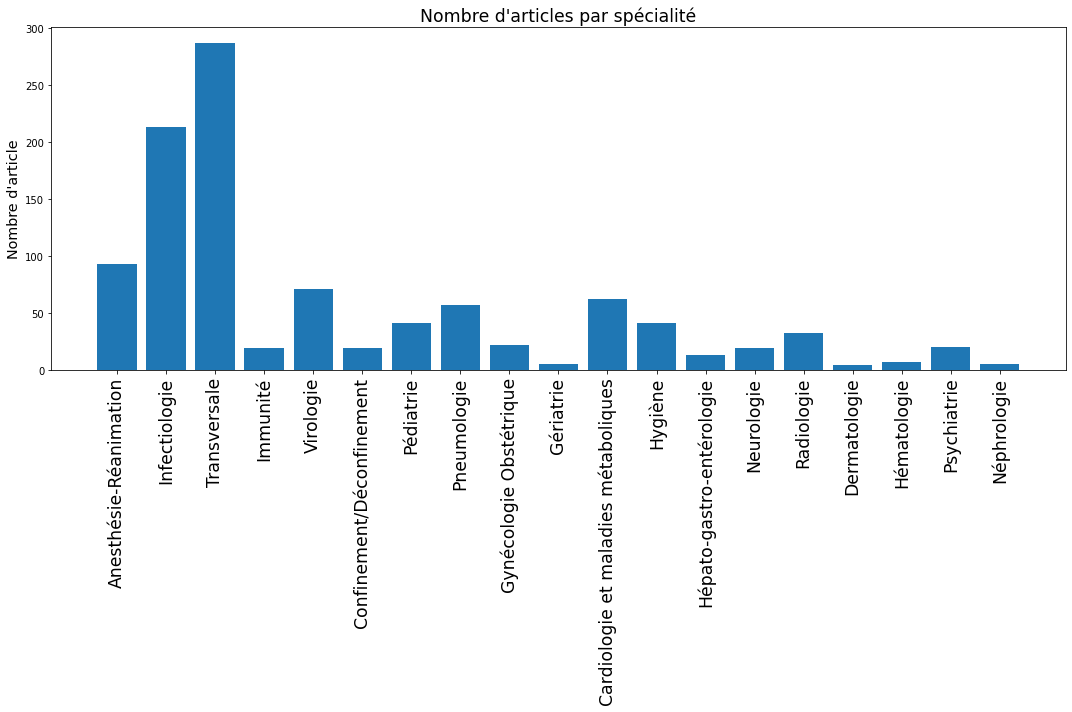

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(15,10))
plt.bar(np.arange(19), nb_per_spe.values())
plt.title('Nombre d\'articles par spécialité',size='xx-large')
plt.ylabel('Nombre d\'article',size='x-large')
plt.xticks(np.arange(19), nb_per_spe.keys(), rotation='vertical',size='xx-large')
plt.tight_layout()
fig.savefig('nbre_par_spe.png')
plt.show()

On remarque que certaines spécialités sont très peu représentés (Dermatologie, Gériatrie, Néphrologie), ce qui risque de poser problèmes pour des modèles entrainés depuis 0.

Au contraire, nous avons beaucoup d'exemples pour la spécialité "Transversale", et ce n'est sûrement pas très pertinent car cette spécialité va finalement en englober plusieurs et cela risque de "brouiller" nos classifieurs. On pourrait par exemple mettre la spécialité Transversale si on a déjà prédit 2 spécialité pour l'article.

# Préparation des données

On va récupérer les données qui nous intéresse.

In [12]:
import utils
texts, Y = utils.get_data(data_dict, get_abstract = False)

In [ ]:
print("y shape:",Y.shape)

y shape: (682, 19)


On soupçonne la spécialité nommée "transversale" d'induire en erreur nos classifieurs, nous créons donc un Y_modif dans lequel cette catégories est mise à 0 dans le cas où il y a moins de 2 classes.

In [13]:
import numpy as np

cptr = 0
Y_modif = np.array(Y)
for i in range(len(Y_modif)):
  if Y_modif[i][2] == 1. and np.sum(Y_modif[i]) < 2:
    Y_modif[i][2] = 0.
    cptr += 1
print(cptr, " exmples modifiés")

175  exmples modifiés


In [14]:
print(len(LABELS))
print("y shape:",Y.shape)
print("y shape avec transversale modifiée:",Y_modif.shape)

19
18
y shape: (682, 19)
y shape sans transversale: (682, 18)
y shape avec transversale modifiée: (682, 19)


Sur les 682 articles que l'on a, on en a 207 qui n'ont pas d'abstract. On va tenter dans un premier temps de prédire la classe seulement avec le titre afin que toutes les données fassent à peu près la même longueur.

Nous allons utiliser les représentations CountVectorizer et TfidVectorizer.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect.fit(texts)
vect2 = TfidfVectorizer(stop_words="english", max_features=2000, min_df=1)  #max_df
vect2.fit(texts)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=2000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [16]:
print("TfidVectorizer")
print("Vocabulary size: {}".format(len(vect2.vocabulary_)))
print("Vocabulary content:\n {}".format(vect2.vocabulary_))

TfidVectorizer
Vocabulary size: 1792
Vocabulary content:
 {'body': 220, 'mass': 978, 'index': 809, 'risk': 1411, 'intubation': 868, 'death': 420, 'sars': 1429, 'cov': 391, 'infection': 821, 'retrospective': 1399, 'cohort': 307, 'study': 1566, 'optimal': 1120, 'covid': 393, '19': 21, 'epidemic': 559, 'control': 359, 'vaccine': 1725, 'deployment': 439, 'contact': 348, 'rate': 1319, 'equilibrium': 565, 'view': 1750, 'hydroxychloroquine': 744, 'treatment': 1673, 'prophylaxis': 1278, 'non': 1092, 'human': 739, 'primates': 1254, 'infectivity': 824, 'profile': 1266, 'correction': 378, 'mrna': 1039, 'preliminary': 1241, 'report': 1376, 'pathophysiology': 1155, 'transmission': 1665, 'diagnosis': 463, 'coronavirus': 376, 'disease': 483, '2019': 25, 'review': 1404, 'introductions': 866, 'early': 520, 'spread': 1529, 'france': 671, '24': 32, 'january': 888, '23': 31, 'march': 972, '2020': 27, 'opensafely': 1118, 'factors': 623, 'associated': 178, '17': 20, 'million': 1014, 'patients': 1157, 'model

In [17]:
bag_of_words = vect.transform(texts)
bag_of_words2 = vect2.transform(texts)

## Séparation test / train

In [70]:
from sklearn.model_selection import train_test_split
## avec 'Transversale'
X_train, X_test, y_train, y_test = train_test_split(bag_of_words2, Y, test_size=0.2, random_state=42)#, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## avec 'Transversale' modifiée
X_train, X_test, y_train_modif, y_test_modif = train_test_split(bag_of_words2, Y_modif, test_size=0.2, random_state=42)#, stratify=y)
X_train, X_valid, y_train_modif, y_valid_modif = train_test_split(X_train, y_train_modif, test_size=0.1, random_state=42)

In [71]:
print(X_train.shape, y_train.shape, y_train_modif.shape)
print(X_valid.shape, y_valid.shape, y_valid_modif.shape)
print(X_test.shape, y_test.shape, y_test_modif.shape)

(490, 1792) (490, 19) (490, 18) (490, 19)
(55, 1792) (55, 19) (55, 18) (55, 19)
(137, 1792) (137, 19) (137, 18) (137, 19)


# Multi-Label Classifiers

### Knn
On va d'abord tester avec les modèles sk-learn qui nous permettent de traiter les problèmes multi-label. Ci-dessous les modèles sont entrainés seulement avec les titres des articles avec une représentation TFid. Nous avons tester aussi avec les abstract et/ ou la représentation CountVectorizer mais c'était moins bon (voir résultats dans rapport).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
k_range = list(range(1,15))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 3, scoring = 'f1_micro')
grid.fit(X_train,y_train)

print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.4530529128535257
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')


In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
score = f1_score(y_test,y_pred , average='micro',zero_division=0)
score

0.47230320699708456

In [ ]:
KNN = {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
KNN

{'f1-macro': 0.3651784324114907,
 'f1-micro': 0.47230320699708456,
 'f1-samples': 0.4233576642335766,
 'f1-weighted': 0.460829595665916}

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forestClf = RandomForestClassifier()
forestClf.fit(X_train,y_train)
forestPredictions = forestClf.predict(X_test)
print(f1_score(y_test,forestPredictions , average='samples',zero_division=0))

0.3581508515815085


In [ ]:
RandomForest= {'f1-micro':score, 'f1-macro':f1_score(y_test,y_pred , average='macro',zero_division=0),'f1-weighted': f1_score(y_test,y_pred , average='weighted',zero_division=0),'f1-samples':f1_score(y_test,y_pred , average='samples',zero_division=0)}
RandomForest

{'f1-macro': 0.17046623714922368,
 'f1-micro': 0.4153284671532846,
 'f1-samples': 0.4153284671532846,
 'f1-weighted': 0.34355182231069625}

In [ ]:
scores_tfid = pd.DataFrame(index=['KNN', 'Random Forest'], columns=['f1-micro', 'f1-macro','f1-weighted','f1-samples'])
scores_tfid.loc['KNN'] = pd.Series(KNN)
scores_tfid.loc['Random Forest'] = pd.Series(RandomForest)
scores_tfid

,f1-micro,f1-macro,f1-weighted,f1-samples
KNN,0.472303,0.365178,0.46083,0.423358
Random Forest,0.415328,0.170466,0.343552,0.415328


#### GridSearch MLP, Random Forest, Knn

Quelques tests avec d'autres classifieurs multi-labels.

In [ ]:
pip install scikit-multilearn --upgrade

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from skmultilearn.adapt import MLkNN
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from IPython.display import display

In [ ]:
#grid
names = ["Arbre de décision", "Forêt", "Knn", "MLP", "Bagging", "boosting", "Lin SVC"]#, "MLknn"]
classifiers = [
DecisionTreeClassifier(),
RandomForestClassifier(),
KNeighborsClassifier( metric='minkowski'),
MLPClassifier(max_iter=10000),
OneVsRestClassifier(BaggingClassifier(n_jobs=-1)),
OneVsRestClassifier(GradientBoostingClassifier()),
OneVsRestClassifier(LinearSVC(), n_jobs=-1),
# MLkNN()
]
parameters = [{"criterion":("gini", "entropy")},
              {"criterion":("gini", "entropy"), "n_estimators":(100, 150, 200)}, 
              {"n_neighbors":(1, 5), "p":(1,2), "weights":("uniform", "distance")},
              {"alpha":(0.00001, 0.0001, 0.001)},
              {}, 
              {},
              {}
          # {"k":(1, 10, 20)},
          ]
#boucle
bparam = []
bscore_train = []
bscore_test = []
auc_score = []

for name, clf, param in zip(names, classifiers, parameters):
    classif = GridSearchCV(clf, param, cv = 3,
                       scoring=make_scorer(f1_score, average='micro'))

    #score
    classif.fit(X_train, y_train)
    bparam.append(classif.best_params_)
    bscore_train.append(classif.best_score_) 
    bscore_test.append(classif.score(X_test, y_test)) 

#dataframe
classifier_names = pd.Series(names)
best_param = pd.Series(bparam)
best_score_train = pd.Series(bscore_train)
best_score_test = pd.Series(bscore_test)
df = pd.DataFrame({ 'Classifieurs': classifier_names, 
                 'Meilleur paramètre': best_param, 
                 'Meilleur score': best_score_train,
                 'F1-score (généralisation)': best_score_test,
                 })
display(df)

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:75: UserWarning: Label not 15 is present in all training examples.
  str(classes[c]))


,Classifieurs,Meilleur paramètre,Meilleur score,F1-score (généralisation)
0,Arbre de décision,{'criterion': 'gini'},0.401894,0.422392
1,Forêt,"{'criterion': 'gini', 'n_estimators': 200}",0.362304,0.391304
2,Knn,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.418332,0.444444
3,MLP,{'alpha': 0.0001},0.431186,0.408408
4,Bagging,{},0.395103,0.376238
5,boosting,{},0.422717,0.357827
6,MNB,{},0.172625,0.179592
7,Lin SVC,{},0.396065,0.380952


### Prédictions des classes une par une : stratégie one vs rest

On fait une régréssion logistique binaire pour tous les labels pour prédire si oui ou non on aura ce label pour ce texte. (inspiré de https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

On suppose donc ici qu'il n'y a pas de corrélation entre les labels.

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

In [ ]:
amelioration = 0
degradation = 0
for label in range(len(LABELS)):
    print('**Label {} **'.format(LABELS[label]))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train[:,label])
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    acc = accuracy_score(y_test[:,label], prediction)
    dict_res_y[LABELS[label][:11]] = {'Accuracy': float("{:0.2f}".format(acc)),'Data train nb': np.shape(np.where(y_train[:,label]==1))[1] ,'Nb of true labeled in test': np.shape(np.where(y_test[:,label]==1))[1] }

    # Training logistic regression model on train data
    LogReg_pipeline.fit(X_train, y_train_modif[:,label])
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(X_test)
    acc_modif = accuracy_score(y_test_modif[:,label], prediction)
    dict_res_ymodif[LABELS[label][:11]] = {'Accuracy': float("{:0.2f}".format(acc_modif)),'Data train nb': np.shape(np.where(y_train[:,label]==1))[1] ,'Nb of true labeled in test': np.shape(np.where(y_test[:,label]==1))[1] }

res_one_vs_rest = pd.DataFrame().from_dict(dict_res, orient='index')
res_one_vs_rest_modif = pd.DataFrame().from_dict(dict_res_modif, orient='index')
display(res_one_vs_rest)
display(res_one_vs_rest_modif)


Nous obtenons donc 19 classifieurs (1 pour chaque spécialité) expert sur sa spécialité, mais finalement ça ne parait pas pertinent car il y a des spécialités où il y a trop peu de données, le classifieur ne peut pas apprendre grand chose de cette manière. Nous n'irons donc pas plus loin pour cette approche.

Nous nous demandons si la spécialité 'Transversale' ne pose pas problème étant donnée que ce n'est pas une spécialité et qu'elle n'aura pas vraiment de mots spécifiques mais plutôt un ensemble de mots d'un peu toute les spécialités et même des mots d'autres discipline.

Nous allons donc voir ce qu'il se passe si on enlève cette spécialité.

## Petit Test de performance sans la spécialité transversale

Il nous faut donc re-transformer les données:

In [ ]:
Y_tronque = np.delete(Y, 2, axis=1)
LABELS_tronque = np.delete(LABELS, 2)
cptr = 0
Y_modif = np.array(Y)
for i in range(len(Y_modif)):
  if Y_modif[i][2] == 1. and np.sum(Y_modif[i]) < 2:
    Y_modif[i][2] = 0.
    cptr += 1
print(cptr, " exemples modifiés")

175  exemples modifiés


In [ ]:
print("y shape sans transversale:",Y_tronque.shape)
print("y shape avec transversale modifiée:",Y_modif.shape)
X_train, X_test, y_train_modif, y_test_modif = train_test_split(bag_of_words2, Y_tronque, test_size=0.2, random_state=42)#, stratify=y)
X_train, X_valid, y_train_modif, y_valid_modif = train_test_split(X_train, y_train_modif, test_size=0.1, random_state=42)

y shape sans transversale: (682, 18)
y shape avec transversale modifiée: (682, 19)


In [ ]:
k_range = list(range(1,15))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv = 3, scoring = 'f1_micro')
grid.fit(X_train,y_train_modif)
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
score = f1_score(y_pred,y_test_modif , average='micro',zero_division=0)
score

0.40143369175627236

Nous avions 0.47 en f1-micro pour KNN avec la spécialité Transversale, nous perdons en performances (0.40) en enlevant cette spécialité finalement. (nous avons regardé dans des tests non présentés dans ce notebook les performances avec Random Forest et même les classifieurs binaires et dans tous les cas nous perdons en performances).

## Conclusion

Les classifieurs "classiques" multilabels ne nous permettent pas d'avoir de bons résultats au vu du manque de certaines données. Nous allons maintenant tester et nous concentrer sur des méthodes deep, comme par exemple le modèle BioBert déjà pré-entrainé sur des données médicales qui permet (il parait), de bons résultats même avec très peu de données.

# BioBert et RNN
## Construction des Data loaders

In [13]:
import numpy as np
import keras

titre, titre_abstract, spe = [],[],[] 


for article in data_dict:
    t = article['title'] 
    titre.append(t)
    if 'abstract' in article.keys():
        t += ' '
        t += str(article['abstract'])
    titre_abstract.append(t[:512])
    temp = []
    for s in article['specialties']:
      temp.append(s['name'])
    spe.append(temp)
print(len(titre))  
print(len(titre_abstract))
print(len(spe))
print(spe[:5])

682
682
682
[['Anesthésie-Réanimation', 'Infectiologie'], ['Infectiologie'], ['Infectiologie'], ['Transversale', 'Infectiologie'], ['Infectiologie']]


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(spe)
classes = mlb.classes_
classes

train_texts_t, test_texts_t, train_texts_ta, test_texts_ta, y_train, y_test, train_labels, test_labels = train_test_split(titre,titre_abstract, spe, y_bin, test_size=0.25, random_state=42)
train_texts_t, valid_texts_t, train_texts_ta, valid_texts_ta, y_train, y_valid, train_labels, valid_labels = train_test_split(train_texts_t, train_texts_ta, y_train, train_labels, test_size=0.2, random_state=42)

In [ ]:
b = bidict(vectorizer.vocabulary_)
for i, name in enumerate(mlb.classes_):
  top_10 = lr.estimators_[i].coef_[0].argsort()[-10:]
  print('Top 10 for label ', name, ':\t\t')
  for j in range(10):
    print(b.inverse[top_10[j]], end=', ')
  print()

In [15]:
!pip -q install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

def bert_text_to_ids(sentence):
  return torch.tensor(tokenizer.encode(sentence, add_special_tokens=True))


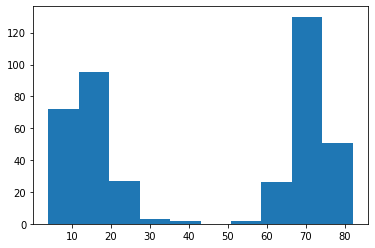

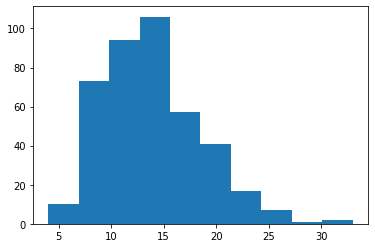

In [17]:
from matplotlib import pyplot as plt
plt.hist([len(text.split()) for text in train_texts_ta])
plt.show()
plt.hist([len(text.split()) for text in train_texts_t])
plt.show()

In [18]:
import collections
import torch
label_vocab = collections.defaultdict(lambda: len(label_vocab))
MAXLEN = 80
batch_size = 32
hidden_size = 128
embed_size = 128
DEVICE = torch.device('cuda')

def prepare_texts(texts, labels):
  X = torch.LongTensor(len(texts), MAXLEN).fill_(tokenizer.pad_token_id)
  for i, text in enumerate(texts):
    indexed_tokens = bert_text_to_ids(text)
    length = min([MAXLEN, len(indexed_tokens)])
    X[i,:length] = indexed_tokens[:length]
  
  Y = torch.tensor(labels).long()
  return X.to(DEVICE), Y.to(DEVICE)

X_train_ta, y_train = prepare_texts(train_texts_ta, train_labels)
X_valid_ta, y_valid = prepare_texts(valid_texts_ta, valid_labels)
X_test_ta, y_test = prepare_texts(test_texts_ta, test_labels)

X_train_t, y_train = prepare_texts(train_texts_t, train_labels)
X_valid_t, y_valid = prepare_texts(valid_texts_t, valid_labels)
X_test_t, y_test = prepare_texts(test_texts_t, test_labels)

In [19]:
print(X_train_ta.shape, X_test_ta.shape, X_valid_ta.shape)
print(X_train_t.shape, X_test_t.shape, X_valid_t.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

torch.Size([408, 80]) torch.Size([171, 80]) torch.Size([103, 80])
torch.Size([408, 80]) torch.Size([171, 80]) torch.Size([103, 80])
torch.Size([408, 19]) torch.Size([171, 19]) torch.Size([103, 19])


In [20]:
from torch.utils.data import TensorDataset, DataLoader
##titres+abstracts
train_set_ta = TensorDataset(X_train_ta, y_train)
valid_set_ta = TensorDataset(X_valid_ta, y_valid)
test_set_ta = TensorDataset(X_test_ta, y_test)
##titres
train_set_t = TensorDataset(X_train_t, y_train)
valid_set_t = TensorDataset(X_valid_t, y_valid)
test_set_t = TensorDataset(X_test_t, y_test)

##titres+abstracts
train_loader_ta = DataLoader(train_set_ta, batch_size=batch_size, shuffle=True)
valid_loader_ta = DataLoader(valid_set_ta, batch_size=batch_size)
test_loader_ta = DataLoader(test_set_ta, batch_size=batch_size)
##titres
train_loader_t = DataLoader(train_set_t, batch_size=batch_size, shuffle=True)
valid_loader_t = DataLoader(valid_set_t, batch_size=batch_size)
test_loader_t = DataLoader(test_set_t, batch_size=batch_size)

## RNN Classifier

### class RNN classifier 

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [32]:
class RNNClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(tokenizer.vocab_size, embed_size, padding_idx=tokenizer.pad_token_id)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.decision = nn.Linear(1 * 2 * hidden_size, len(LABELS))
    self.to(DEVICE)
  
  def forward(self, x):
    embed = self.embed(x)
    output, hidden = self.rnn(embed) 
    drop = self.dropout(hidden.transpose(0, 1).reshape(x.shape[0], -1))
    return torch.softmax(self.decision(drop),1)

rnn_model = RNNClassifier()
with torch.no_grad():
  print(rnn_model(X_train_ta[:3]).shape)

torch.Size([3, 19])


### Performance et entraînement RNN classifier 

Reprise du notebook sur litcovid pour les fonctions de performances et de fit en multi label

In [33]:
def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * len(LABELS)
            num += len(y)

    f_score = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return total_loss / num, correct / num_comp, accu_score, f_score

In [34]:
def multi_hot(y_pred, seuil=2e-1):
    """binarize prediction using threshold
    """
    res = torch.zeros(y_pred.shape[0], y_pred.shape[1])#.int()
    res[torch.arange(y_pred.shape[0]), torch.argmax(y_pred, dim=1)] = 1
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] > seuil:
                res[i,j] = 1
    return res.to(DEVICE)

In [35]:
def fit_rnn(model, train_loader, val_loader, epochs, lr=1e-3, seuil=2e-1): 
    criterion = CrossEntropyLossOneHot
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, val_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

In [36]:
# history_rnnclassif_ta = fit_rnn(rnn_model, train_loader_ta,  valid_loader_ta, 10)
# history_rnnclassif_t = fit_rnn(rnn_model, train_loader_t,  valid_loader_t, 10)

### Tests pour la paramétrisation

In [37]:
def print_history_test(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    plt.figure()
    if losses:
      plt.subplot(131)
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
    
    if [f_micro]:
      plt.subplot(133)
      plt.plot(x,hist['f_micro'])
      plt.xlabel('Epoch')
      plt.ylabel('f_score mean')
      plt.show()


In [39]:
lr_tab = np.array([ 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12, 1e-13])
seuil_tab = np.arange(0.,0.5,0.01)

max_ta = 0.
lr_max_ta = 0.
seuil_max_ta = 0.
max_ta_2 = 0.
lr_max_ta_2 = 0.
seuil_max_ta_2 = 0.
max_t = 0.
lr_max_t = 0.
seuil_max_t = 0.
max_t_2 = 0.
lr_max_t_2 = 0.
seuil_max_t_2 = 0.

for seuil in seuil_tab:
  for lr in lr_tab:
    history_ta = fit_rnn(rnn_model, train_loader_ta, valid_loader_ta, 3, lr=lr, seuil=seuil)
    history_t = fit_rnn(rnn_model, train_loader_t, valid_loader_t, 3, lr=lr, seuil=seuil)
    titre = 'seuil : ' + str(seuil) + ' , lr : ' + str(lr)
    print(titre)
    # print_history_test(history)
    _,_,_,score_ta = perf(bert_model, test_loader_ta, seuil=seuil)
    _,_,_,score_t = perf(bert_model, test_loader_t, seuil=seuil)
    f_score_ta = np.mean(history_ta['f_micro'])
    f_score_t = np.mean(history_t['f_micro'])
    if max_ta < f_score_ta:
      history_temp_ta = history_ta
      max_ta = f_score_ta
      lr_max_ta = lr
      seuil_max_ta = seuil
    if max_ta_2 < score_ta:
      history_temp_ta_2 = history_ta
      max_ta_2 = score_ta
      lr_max_ta_2 = lr
      seuil_max_ta_2 = seuil
    if max_t < f_score_t:
      history_temp_t = history_t
      max_t = f_score_t
      lr_max_t = lr
      seuil_max_t = seuil
    if max_t_2 < score_t:
      history_temp_t_2 = history_t
      max_t_2 = score_t
      lr_max_t_2 = lr
      seuil_max_t_2 = seuil

print("\n\n___________________________\n\n")
print("titres + abstracts")
print("Meilleur f_score :", max_ta, " avec un seuil de", seuil_max_ta, " et un learning rate de", lr_max_ta)
print("Meilleur f_score perf :", max_ta_2, " avec un seuil de", seuil_max_ta_2, " et un learning rate de", lr_max_ta_2)
# print_history_test(history_temp_ta)
# print_history_test(history_temp_ta_2)

print("titres ")
print("Meilleur f_score :", max_t, " avec un seuil de", seuil_max_t, " et un learning rate de", lr_max_t)
print("Meilleur f_score perf :", max_t_2, " avec un seuil de", seuil_max_t_2, " et un learning rate de", lr_max_t_2)
# print_history_test(history_temp_t)
# print_history_test(history_temp_t_2)


100%|██████████| 13/13 [00:00<00:00, 105.04it/s]


epoch : 0	 - train loss : 3.1326059640622606	 - val loss : 3.7158745700873217	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 115.72it/s]


epoch : 1	 - train loss : 3.1276805354099646	 - val loss : 3.7159477530173883	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.86it/s]


epoch : 2	 - train loss : 3.1325478273279526	 - val loss : 3.7160547497203047	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 112.05it/s]


epoch : 0	 - train loss : 3.2269635480992935	 - val loss : 3.7355364086558516	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.89it/s]


epoch : 1	 - train loss : 3.2283528271843407	 - val loss : 3.734734544476259	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.2418823429182466	 - val loss : 3.733768944601411	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 0	 - train loss : 3.123851869620529	 - val loss : 3.7140909028284756	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 1	 - train loss : 3.1276820500691733	 - val loss : 3.7140947175257413	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 2	 - train loss : 3.128253787171607	 - val loss : 3.714129383124194	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 105.39it/s]


epoch : 0	 - train loss : 3.232136277591481	 - val loss : 3.733858127038456	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 114.71it/s]


epoch : 1	 - train loss : 3.235630521587297	 - val loss : 3.733711613034739	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.239607006895776	 - val loss : 3.733685539764108	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 105.61it/s]


epoch : 0	 - train loss : 3.126849978577857	 - val loss : 3.713984813505006	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 112.06it/s]


epoch : 1	 - train loss : 3.1156596950456206	 - val loss : 3.713984961648589	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 117.04it/s]


epoch : 2	 - train loss : 3.125895387986127	 - val loss : 3.7139867764074825	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 116.01it/s]


epoch : 0	 - train loss : 3.235095678591261	 - val loss : 3.733692428440724	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.23it/s]


epoch : 1	 - train loss : 3.214301296308929	 - val loss : 3.7336911321843713	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.210193166545793	 - val loss : 3.733687595256324	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 111.38it/s]


epoch : 0	 - train loss : 3.1320520662793925	 - val loss : 3.7139751841721025	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.69it/s]


epoch : 1	 - train loss : 3.119889932520249	 - val loss : 3.7139753693515813	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 112.54it/s]


epoch : 2	 - train loss : 3.1332906274234547	 - val loss : 3.7139755174951645	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 111.77it/s]


epoch : 0	 - train loss : 3.222935844870175	 - val loss : 3.733688280420396	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 108.04it/s]


epoch : 1	 - train loss : 3.213715160594267	 - val loss : 3.7336878359896466	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.240711530049642	 - val loss : 3.7336875026665846	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.18it/s]


epoch : 0	 - train loss : 3.12921890557981	 - val loss : 3.713974739741353	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 108.90it/s]


epoch : 1	 - train loss : 3.1067559298347023	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 112.56it/s]


epoch : 2	 - train loss : 3.1056214687871	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 106.40it/s]


epoch : 0	 - train loss : 3.2139080272001377	 - val loss : 3.733687576738376	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.20it/s]


epoch : 1	 - train loss : 3.2235174740062043	 - val loss : 3.733687576738376	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.2288538614908853	 - val loss : 3.7336875026665846	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.07it/s]


epoch : 0	 - train loss : 3.1152665942322972	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 115.50it/s]


epoch : 1	 - train loss : 3.1266240138633576	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 2	 - train loss : 3.1204884286020316	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 106.59it/s]


epoch : 0	 - train loss : 3.232017161799412	 - val loss : 3.7336875026665846	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 114.11it/s]


epoch : 1	 - train loss : 3.242406639398313	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.229923734477922	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 101.03it/s]


epoch : 0	 - train loss : 3.128280901441387	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 99.65it/s]


epoch : 1	 - train loss : 3.121239362978468	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 110.62it/s]


epoch : 2	 - train loss : 3.1278373680862726	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 105.67it/s]


epoch : 0	 - train loss : 3.2244711109236177	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.24it/s]


epoch : 1	 - train loss : 3.2302041147269454	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.228812161613913	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.07it/s]


epoch : 0	 - train loss : 3.116746621973374	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 114.60it/s]


epoch : 1	 - train loss : 3.113831931469487	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 112.98it/s]


epoch : 2	 - train loss : 3.128239126766429	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 108.92it/s]


epoch : 0	 - train loss : 3.2258795943914675	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 105.46it/s]


epoch : 1	 - train loss : 3.219046630111395	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.2192299412746057	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 111.07it/s]


epoch : 0	 - train loss : 3.1173057182162416	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 109.22it/s]


epoch : 1	 - train loss : 3.128454619762944	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.08it/s]


epoch : 2	 - train loss : 3.117288121990129	 - val loss : 3.7139748138131448	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 111.71it/s]


epoch : 0	 - train loss : 3.2264173545089423	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



100%|██████████| 13/13 [00:00<00:00, 113.19it/s]


epoch : 1	 - train loss : 3.2313596688064874	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303



epoch : 2	 - train loss : 3.2278634613635493	 - val loss : 3.7336873545230014	 - precision :0.07920286152273888	 - all good precision : 0.0	 - f-score micro : 0.146780303030303
seuil : 0.0 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.52it/s]


epoch : 0	 - train loss : 3.1197823169184664	 - val loss : 3.714527463450015	 - precision :0.28206438426162495	 - all good precision : 0.0	 - f-score micro : 0.17401528512639625



100%|██████████| 13/13 [00:00<00:00, 115.61it/s]


epoch : 1	 - train loss : 3.1188803841085995	 - val loss : 3.714596572431546	 - precision :0.28206438426162495	 - all good precision : 0.0	 - f-score micro : 0.17401528512639625



100%|██████████| 13/13 [00:00<00:00, 115.32it/s]


epoch : 2	 - train loss : 3.125135010364009	 - val loss : 3.714760011839635	 - precision :0.2825753704649974	 - all good precision : 0.0	 - f-score micro : 0.17411764705882354



100%|██████████| 13/13 [00:00<00:00, 114.19it/s]


epoch : 0	 - train loss : 3.2304970423380532	 - val loss : 3.7344682934214766	 - precision :0.29994890137966274	 - all good precision : 0.0	 - f-score micro : 0.17668269230769232



100%|██████████| 13/13 [00:00<00:00, 114.58it/s]


epoch : 1	 - train loss : 3.2213372997209135	 - val loss : 3.733621930613101	 - precision :0.2963719979560552	 - all good precision : 0.0	 - f-score micro : 0.17594254937163376



epoch : 2	 - train loss : 3.216176631403904	 - val loss : 3.7329493217097904	 - precision :0.2963719979560552	 - all good precision : 0.0	 - f-score micro : 0.17594254937163376
seuil : 0.01 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.13it/s]


epoch : 0	 - train loss : 3.1075612984451593	 - val loss : 3.713279464869823	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 113.40it/s]


epoch : 1	 - train loss : 3.102031202877269	 - val loss : 3.7132798352287812	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 110.37it/s]


epoch : 2	 - train loss : 3.119661985659132	 - val loss : 3.7132930940794715	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 116.25it/s]


epoch : 0	 - train loss : 3.2127947152829637	 - val loss : 3.733113927748597	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 115.18it/s]


epoch : 1	 - train loss : 3.2374019996792662	 - val loss : 3.733047411279771	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.2114186006433822	 - val loss : 3.7329455255304724	 - precision :0.2968829841594277	 - all good precision : 0.0	 - f-score micro : 0.17604790419161678
seuil : 0.01 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.44it/s]


epoch : 0	 - train loss : 3.102850502612544	 - val loss : 3.713143820901519	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 105.91it/s]


epoch : 1	 - train loss : 3.1135733174342737	 - val loss : 3.7131447097630175	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 109.79it/s]


epoch : 2	 - train loss : 3.111920899035884	 - val loss : 3.713148246691065	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 111.79it/s]


epoch : 0	 - train loss : 3.209221166722915	 - val loss : 3.7329673211551406	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 1	 - train loss : 3.20597095115512	 - val loss : 3.732962969437386	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.2240551780251896	 - val loss : 3.7329578029299246	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 0	 - train loss : 3.1095446792303347	 - val loss : 3.71314635786038	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 119.25it/s]


epoch : 1	 - train loss : 3.102369458067651	 - val loss : 3.7131468022911296	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 115.82it/s]


epoch : 2	 - train loss : 3.091915074516745	 - val loss : 3.713146691183442	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 111.69it/s]


epoch : 0	 - train loss : 3.222697463690066	 - val loss : 3.732960136191359	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 114.37it/s]


epoch : 1	 - train loss : 3.2087227503458657	 - val loss : 3.732959413991391	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.21769931269627	 - val loss : 3.732958599201684	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.23it/s]


epoch : 0	 - train loss : 3.1069174373851105	 - val loss : 3.7131459875014223	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 1	 - train loss : 3.1144263697605505	 - val loss : 3.713145894911683	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 111.62it/s]


epoch : 2	 - train loss : 3.110333143496046	 - val loss : 3.7131459689834743	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 116.97it/s]


epoch : 0	 - train loss : 3.2329228345085594	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 116.59it/s]


epoch : 1	 - train loss : 3.2190883299883675	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.2235574909285005	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 112.82it/s]


epoch : 0	 - train loss : 3.112824496100931	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 111.34it/s]


epoch : 1	 - train loss : 3.116010908987008	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 115.37it/s]


epoch : 2	 - train loss : 3.108516637016745	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 113.10it/s]


epoch : 0	 - train loss : 3.225714926626168	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 114.04it/s]


epoch : 1	 - train loss : 3.2089933133592794	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.222641608294319	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.97it/s]


epoch : 0	 - train loss : 3.1258804657879997	 - val loss : 3.7131459319475786	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 116.43it/s]


epoch : 1	 - train loss : 3.1127094754985736	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 2	 - train loss : 3.1150229584937	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 113.08it/s]


epoch : 0	 - train loss : 3.21835527233049	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 112.55it/s]


epoch : 1	 - train loss : 3.2089693406048942	 - val loss : 3.7329584510581006	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.2270786248001397	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.72it/s]


epoch : 0	 - train loss : 3.11644245596493	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 114.57it/s]


epoch : 1	 - train loss : 3.119403652116364	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 2	 - train loss : 3.11531036975337	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 110.98it/s]


epoch : 0	 - train loss : 3.231750619177725	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 110.60it/s]


epoch : 1	 - train loss : 3.207104065838982	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.2127266117170747	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.64it/s]


epoch : 0	 - train loss : 3.1201203290153954	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 116.14it/s]


epoch : 1	 - train loss : 3.1204229616651347	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 112.68it/s]


epoch : 2	 - train loss : 3.1145953010110294	 - val loss : 3.713145950465526	 - precision :0.2815533980582524	 - all good precision : 0.0	 - f-score micro : 0.1739130434782609



100%|██████████| 13/13 [00:00<00:00, 107.33it/s]


epoch : 0	 - train loss : 3.210530898150276	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



100%|██████████| 13/13 [00:00<00:00, 105.44it/s]


epoch : 1	 - train loss : 3.216661808537502	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512



epoch : 2	 - train loss : 3.209195006127451	 - val loss : 3.7329584695760487	 - precision :0.2973939703628002	 - all good precision : 0.0	 - f-score micro : 0.17615338526063512
seuil : 0.01 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.74it/s]


epoch : 0	 - train loss : 3.119887351989746	 - val loss : 3.7129669374632606	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 112.01it/s]


epoch : 1	 - train loss : 3.106941129647049	 - val loss : 3.713168505326058	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21303656597774248



100%|██████████| 13/13 [00:00<00:00, 114.03it/s]


epoch : 2	 - train loss : 3.11237179999258	 - val loss : 3.7134224974993364	 - precision :0.49463464486458864	 - all good precision : 0.0	 - f-score micro : 0.21320604614160701



100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 0	 - train loss : 3.2135784485760857	 - val loss : 3.7337326864594393	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 114.84it/s]


epoch : 1	 - train loss : 3.2324539072373333	 - val loss : 3.7328003818549	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.210731730741613	 - val loss : 3.7321123660189435	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 108.60it/s]


epoch : 0	 - train loss : 3.1127642089245366	 - val loss : 3.7121553698789724	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.19it/s]


epoch : 1	 - train loss : 3.116026523066502	 - val loss : 3.7121952760566788	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 107.85it/s]


epoch : 2	 - train loss : 3.1153609892901253	 - val loss : 3.7121889429184995	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 107.79it/s]


epoch : 0	 - train loss : 3.211373609655044	 - val loss : 3.7323481735673925	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 109.35it/s]


epoch : 1	 - train loss : 3.213272206923541	 - val loss : 3.732260768853345	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.218991560094497	 - val loss : 3.732195974553673	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 112.99it/s]


epoch : 0	 - train loss : 3.106720718682981	 - val loss : 3.7121218338753414	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 115.95it/s]


epoch : 1	 - train loss : 3.1023833143944834	 - val loss : 3.71212377825987	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 108.21it/s]


epoch : 2	 - train loss : 3.1146733901079964	 - val loss : 3.7121256856085028	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 108.15it/s]


epoch : 0	 - train loss : 3.2133539424223057	 - val loss : 3.7322063631224403	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 115.87it/s]


epoch : 1	 - train loss : 3.214723456139658	 - val loss : 3.732198659656117	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.2177310644411574	 - val loss : 3.7321909376718465	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.06it/s]


epoch : 0	 - train loss : 3.104121357786889	 - val loss : 3.7121099823886907	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 115.73it/s]


epoch : 1	 - train loss : 3.0905309564927044	 - val loss : 3.7121103897835446	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 111.21it/s]


epoch : 2	 - train loss : 3.113464860355153	 - val loss : 3.712110463855336	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 109.86it/s]


epoch : 0	 - train loss : 3.2017301297655294	 - val loss : 3.732192882056375	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 114.18it/s]


epoch : 1	 - train loss : 3.209429834403244	 - val loss : 3.732192419107678	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.2087247885909735	 - val loss : 3.7321921783743552	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 112.59it/s]


epoch : 0	 - train loss : 3.1114799836102653	 - val loss : 3.7121096861015244	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 105.73it/s]


epoch : 1	 - train loss : 3.0947599037020814	 - val loss : 3.7121096861015244	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 111.97it/s]


epoch : 2	 - train loss : 3.1108288297466204	 - val loss : 3.7121096861015244	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 115.15it/s]


epoch : 0	 - train loss : 3.2165206460391773	 - val loss : 3.7321920672666677	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 115.13it/s]


epoch : 1	 - train loss : 3.214957648632573	 - val loss : 3.7321922894820427	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.1946628514458153	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.18it/s]


epoch : 0	 - train loss : 3.1083578969918046	 - val loss : 3.7121096861015244	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 1	 - train loss : 3.098547187505984	 - val loss : 3.7121096490656287	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.78it/s]


epoch : 2	 - train loss : 3.1214501811008826	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.18it/s]


epoch : 0	 - train loss : 3.2119385214412914	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 113.41it/s]


epoch : 1	 - train loss : 3.202608239416983	 - val loss : 3.73219204874872	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.2139591516232957	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.82it/s]


epoch : 0	 - train loss : 3.1139317119822785	 - val loss : 3.7121096490656287	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 1	 - train loss : 3.0894192340327242	 - val loss : 3.7121096490656287	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 118.33it/s]


epoch : 2	 - train loss : 3.105571241939769	 - val loss : 3.7121096490656287	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.35it/s]


epoch : 0	 - train loss : 3.2210783303952684	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 115.20it/s]


epoch : 1	 - train loss : 3.206496799693388	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.214793971940583	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.97it/s]


epoch : 0	 - train loss : 3.117585443982891	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 113.49it/s]


epoch : 1	 - train loss : 3.0894833920048734	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 109.35it/s]


epoch : 2	 - train loss : 3.1110636206234203	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 116.33it/s]


epoch : 0	 - train loss : 3.198246114394244	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 1	 - train loss : 3.2184530706966625	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.2210688871495865	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 112.12it/s]


epoch : 0	 - train loss : 3.098736660153258	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 113.20it/s]


epoch : 1	 - train loss : 3.0987455143648037	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 110.70it/s]


epoch : 2	 - train loss : 3.0867186340631223	 - val loss : 3.7121096675835767	 - precision :0.49412365866121616	 - all good precision : 0.0	 - f-score micro : 0.21428571428571427



100%|██████████| 13/13 [00:00<00:00, 113.84it/s]


epoch : 0	 - train loss : 3.2178511152080462	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



100%|██████████| 13/13 [00:00<00:00, 115.43it/s]


epoch : 1	 - train loss : 3.202108719769646	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067



epoch : 2	 - train loss : 3.2157758450975606	 - val loss : 3.732192030230772	 - precision :0.5038323965252938	 - all good precision : 0.0	 - f-score micro : 0.21503637833468067
seuil : 0.02 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.31it/s]


epoch : 0	 - train loss : 3.102542278813381	 - val loss : 3.713154024290807	 - precision :0.5835462442514052	 - all good precision : 0.0	 - f-score micro : 0.23617619493908157



100%|██████████| 13/13 [00:00<00:00, 116.25it/s]


epoch : 1	 - train loss : 3.112928727093865	 - val loss : 3.7130200654557606	 - precision :0.5830352580480327	 - all good precision : 0.0	 - f-score micro : 0.2359550561797753



100%|██████████| 13/13 [00:00<00:00, 110.13it/s]


epoch : 2	 - train loss : 3.1017061869303384	 - val loss : 3.71306143455135	 - precision :0.5835462442514052	 - all good precision : 0.0	 - f-score micro : 0.23617619493908157



100%|██████████| 13/13 [00:00<00:00, 115.46it/s]


epoch : 0	 - train loss : 3.2012778356963514	 - val loss : 3.7327213472532996	 - precision :0.5886561062851303	 - all good precision : 0.0	 - f-score micro : 0.23841059602649006



100%|██████████| 13/13 [00:00<00:00, 117.16it/s]


epoch : 1	 - train loss : 3.2113102931602326	 - val loss : 3.7314110542964007	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.2129037333469763	 - val loss : 3.731060509542817	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 118.32it/s]


epoch : 0	 - train loss : 3.094713435453527	 - val loss : 3.71114238257547	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 1	 - train loss : 3.0872509900261376	 - val loss : 3.711155085887724	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 111.16it/s]


epoch : 2	 - train loss : 3.097824582866594	 - val loss : 3.711137493837227	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 111.96it/s]


epoch : 0	 - train loss : 3.194448097079408	 - val loss : 3.7311915980959403	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 3.2160658368877337	 - val loss : 3.7311350072471843	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.220848326589547	 - val loss : 3.7310532690251916	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.11it/s]


epoch : 0	 - train loss : 3.105801563636929	 - val loss : 3.7110283120164596	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 117.48it/s]


epoch : 1	 - train loss : 3.083766955955356	 - val loss : 3.711031237852226	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 109.49it/s]


epoch : 2	 - train loss : 3.0969939512365006	 - val loss : 3.7110301267753525	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 113.87it/s]


epoch : 0	 - train loss : 3.21152307472977	 - val loss : 3.7310580281377996	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 117.44it/s]


epoch : 1	 - train loss : 3.212152312783634	 - val loss : 3.731053213471348	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.2084999458462584	 - val loss : 3.731046732189586	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.15it/s]


epoch : 0	 - train loss : 3.0980851416494333	 - val loss : 3.711010979217233	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 112.41it/s]


epoch : 1	 - train loss : 3.092155980128868	 - val loss : 3.7110112014326075	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 116.11it/s]


epoch : 2	 - train loss : 3.0944758957507563	 - val loss : 3.7110116828992528	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 107.58it/s]


epoch : 0	 - train loss : 3.193721285053328	 - val loss : 3.7310464359024196	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 116.38it/s]


epoch : 1	 - train loss : 3.203336753097235	 - val loss : 3.7310464173844715	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.2025533189960553	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 112.41it/s]


epoch : 0	 - train loss : 3.089873407401291	 - val loss : 3.7110102014634214	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 114.30it/s]


epoch : 1	 - train loss : 3.0949489369111904	 - val loss : 3.7110102384993175	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 113.38it/s]


epoch : 2	 - train loss : 3.0837686389100316	 - val loss : 3.7110103496070046	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 113.42it/s]


epoch : 0	 - train loss : 3.203548150904038	 - val loss : 3.731045324825546	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 112.56it/s]


epoch : 1	 - train loss : 3.195442405401492	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.205524126688639	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 106.10it/s]


epoch : 0	 - train loss : 3.0830554214178347	 - val loss : 3.7110102014634214	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 114.82it/s]


epoch : 1	 - train loss : 3.0984031265857173	 - val loss : 3.711010312571109	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 2	 - train loss : 3.086776808196423	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 108.75it/s]


epoch : 0	 - train loss : 3.2130451389387544	 - val loss : 3.731045324825546	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 113.50it/s]


epoch : 1	 - train loss : 3.1964605181824925	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.2018738540948606	 - val loss : 3.731045324825546	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.99it/s]


epoch : 0	 - train loss : 3.1015158260569855	 - val loss : 3.711010312571109	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 116.48it/s]


epoch : 1	 - train loss : 3.0970608767341163	 - val loss : 3.711010312571109	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 110.46it/s]


epoch : 2	 - train loss : 3.105232837153416	 - val loss : 3.711010312571109	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 115.61it/s]


epoch : 0	 - train loss : 3.209601888469621	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 117.90it/s]


epoch : 1	 - train loss : 3.202810100480622	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.1995810153437594	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.64it/s]


epoch : 0	 - train loss : 3.104120030122645	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 112.28it/s]


epoch : 1	 - train loss : 3.0962215124392043	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 117.26it/s]


epoch : 2	 - train loss : 3.087163719476438	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 115.94it/s]


epoch : 0	 - train loss : 3.2005283131318936	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 1	 - train loss : 3.205870216968013	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.2028103061750826	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 111.29it/s]


epoch : 0	 - train loss : 3.083698459700042	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 117.38it/s]


epoch : 1	 - train loss : 3.0839870490279853	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 115.10it/s]


epoch : 2	 - train loss : 3.090419619691138	 - val loss : 3.7110102755352132	 - precision :0.5825242718446602	 - all good precision : 0.0	 - f-score micro : 0.23573433115060802



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 0	 - train loss : 3.2066103804345225	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



100%|██████████| 13/13 [00:00<00:00, 107.23it/s]


epoch : 1	 - train loss : 3.216076738694135	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378



epoch : 2	 - train loss : 3.20202215980081	 - val loss : 3.7310453988973378	 - precision :0.5871231476750127	 - all good precision : 0.0	 - f-score micro : 0.23773584905660378
seuil : 0.03 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 0	 - train loss : 3.1049146839216646	 - val loss : 3.711224472638473	 - precision :0.6791006642820644	 - all good precision : 0.0	 - f-score micro : 0.2697674418604651



100%|██████████| 13/13 [00:00<00:00, 117.10it/s]


epoch : 1	 - train loss : 3.088850077460794	 - val loss : 3.711511037882092	 - precision :0.6791006642820644	 - all good precision : 0.0	 - f-score micro : 0.2697674418604651



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 2	 - train loss : 3.085769410226859	 - val loss : 3.711600664749886	 - precision :0.6796116504854369	 - all good precision : 0.0	 - f-score micro : 0.27008149010477295



100%|██████████| 13/13 [00:00<00:00, 109.16it/s]


epoch : 0	 - train loss : 3.192077131832347	 - val loss : 3.7327663829025712	 - precision :0.6791006642820644	 - all good precision : 0.0	 - f-score micro : 0.26635514018691586



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 1	 - train loss : 3.1918322432274913	 - val loss : 3.731339649089332	 - precision :0.6780786918753193	 - all good precision : 0.0	 - f-score micro : 0.2657342657342658



epoch : 2	 - train loss : 3.202621890049355	 - val loss : 3.730369197512136	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 0	 - train loss : 3.1077932095995138	 - val loss : 3.709916309245582	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 1	 - train loss : 3.0597413941925646	 - val loss : 3.709961400448697	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 111.05it/s]


epoch : 2	 - train loss : 3.0808880375880823	 - val loss : 3.7099743074583778	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 0	 - train loss : 3.2030839546054017	 - val loss : 3.730439084247478	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 115.20it/s]


epoch : 1	 - train loss : 3.2106408044403674	 - val loss : 3.7303469759746664	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.2054227754181506	 - val loss : 3.730235072015559	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 0	 - train loss : 3.081637737797756	 - val loss : 3.7098198862909113	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 111.49it/s]


epoch : 1	 - train loss : 3.0922525256287816	 - val loss : 3.709819738147328	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 113.19it/s]


epoch : 2	 - train loss : 3.0890219819312	 - val loss : 3.70982244176772	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.57it/s]


epoch : 0	 - train loss : 3.202030331480737	 - val loss : 3.730259423117036	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 1	 - train loss : 3.193089017681047	 - val loss : 3.730247923471395	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.199223705366546	 - val loss : 3.7302444976510354	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 111.55it/s]


epoch : 0	 - train loss : 3.066905620051365	 - val loss : 3.7098127568809733	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 114.60it/s]


epoch : 1	 - train loss : 3.0744337568096087	 - val loss : 3.7098128865066085	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 2	 - train loss : 3.073112543891458	 - val loss : 3.709813497598889	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.94it/s]


epoch : 0	 - train loss : 3.2011955111634496	 - val loss : 3.7302440347023382	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 111.53it/s]


epoch : 1	 - train loss : 3.204156800812366	 - val loss : 3.730243479163901	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.2066738091263116	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.80it/s]


epoch : 0	 - train loss : 3.077296911501417	 - val loss : 3.7098111828554026	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 116.56it/s]


epoch : 1	 - train loss : 3.078657580356972	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 114.40it/s]


epoch : 2	 - train loss : 3.0876075146245023	 - val loss : 3.709811238409246	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 3.195735127318139	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 117.06it/s]


epoch : 1	 - train loss : 3.204191394880706	 - val loss : 3.730242331051132	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.199227725758272	 - val loss : 3.730242331051132	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.87it/s]


epoch : 0	 - train loss : 3.069714434006635	 - val loss : 3.7098111828554026	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 1	 - train loss : 3.094620330660951	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 2	 - train loss : 3.083747209287157	 - val loss : 3.7098111828554026	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 113.30it/s]


epoch : 0	 - train loss : 3.198429874345368	 - val loss : 3.730242331051132	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 1	 - train loss : 3.1939962985468844	 - val loss : 3.7302423125331843	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.2018488341686773	 - val loss : 3.730242331051132	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.81it/s]


epoch : 0	 - train loss : 3.0828370860978667	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 1	 - train loss : 3.0920503653732	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.11it/s]


epoch : 2	 - train loss : 3.0818101284550687	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 0	 - train loss : 3.1959191303627166	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 113.82it/s]


epoch : 1	 - train loss : 3.2039110333311793	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.204026409223968	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 107.02it/s]


epoch : 0	 - train loss : 3.0748960083606196	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 111.16it/s]


epoch : 1	 - train loss : 3.0835677128212127	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.50it/s]


epoch : 2	 - train loss : 3.085965642742082	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 111.16it/s]


epoch : 0	 - train loss : 3.1914162729300704	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 113.97it/s]


epoch : 1	 - train loss : 3.196217293832816	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.1951220269296683	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.60it/s]


epoch : 0	 - train loss : 3.065768466276281	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 1	 - train loss : 3.0638266357721067	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 115.11it/s]


epoch : 2	 - train loss : 3.078265863306382	 - val loss : 3.7098111643374545	 - precision :0.6760347470618293	 - all good precision : 0.0	 - f-score micro : 0.2678983833718245



100%|██████████| 13/13 [00:00<00:00, 113.69it/s]


epoch : 0	 - train loss : 3.196647101757573	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 1	 - train loss : 3.1990825802672145	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345



epoch : 2	 - train loss : 3.1964400235344383	 - val loss : 3.73024234956908	 - precision :0.6775677056719469	 - all good precision : 0.0	 - f-score micro : 0.26542491268917345
seuil : 0.04 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.31it/s]


epoch : 0	 - train loss : 3.077061653137207	 - val loss : 3.7100800449408373	 - precision :0.7358201328564129	 - all good precision : 0.0	 - f-score micro : 0.292749658002736



100%|██████████| 13/13 [00:00<00:00, 116.01it/s]


epoch : 1	 - train loss : 3.0743554059196923	 - val loss : 3.7104789585743134	 - precision :0.7358201328564129	 - all good precision : 0.0	 - f-score micro : 0.292749658002736



100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 2	 - train loss : 3.078674035913804	 - val loss : 3.7105805850723415	 - precision :0.7358201328564129	 - all good precision : 0.0	 - f-score micro : 0.292749658002736



100%|██████████| 13/13 [00:00<00:00, 112.02it/s]


epoch : 0	 - train loss : 3.1919343424778357	 - val loss : 3.7305848945691746	 - precision :0.7312212570260603	 - all good precision : 0.0	 - f-score micro : 0.28532608695652173



100%|██████████| 13/13 [00:00<00:00, 115.15it/s]


epoch : 1	 - train loss : 3.1934890560075346	 - val loss : 3.7297270321151585	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955



epoch : 2	 - train loss : 3.202380142959894	 - val loss : 3.7292779348428966	 - precision :0.7296882984159427	 - all good precision : 0.0	 - f-score micro : 0.28416779431664413
seuil : 0.05 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.83it/s]


epoch : 0	 - train loss : 3.0763192457311295	 - val loss : 3.7087926216495846	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 115.19it/s]


epoch : 1	 - train loss : 3.0708680620380475	 - val loss : 3.7088289723812955	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 113.06it/s]


epoch : 2	 - train loss : 3.0739201003429937	 - val loss : 3.7088794523072472	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 113.27it/s]


epoch : 0	 - train loss : 3.1878799363678576	 - val loss : 3.7294532998094283	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955



100%|██████████| 13/13 [00:00<00:00, 110.84it/s]


epoch : 1	 - train loss : 3.1831797431497013	 - val loss : 3.729368246874763	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.1885066873887005	 - val loss : 3.7293282295893695	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 111.83it/s]


epoch : 0	 - train loss : 3.0691827325259937	 - val loss : 3.708711568591664	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 116.41it/s]


epoch : 1	 - train loss : 3.0693944295247397	 - val loss : 3.7087154203248254	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 115.13it/s]


epoch : 2	 - train loss : 3.073767755545822	 - val loss : 3.708717549888833	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 112.63it/s]


epoch : 0	 - train loss : 3.185463699640012	 - val loss : 3.729342488409246	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955



100%|██████████| 13/13 [00:00<00:00, 114.09it/s]


epoch : 1	 - train loss : 3.18089043860342	 - val loss : 3.729334044225008	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955



epoch : 2	 - train loss : 3.1979378344965914	 - val loss : 3.7293218964511907	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955
seuil : 0.05 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 111.73it/s]


epoch : 0	 - train loss : 3.0799706028956995	 - val loss : 3.708698939351202	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 117.52it/s]


epoch : 1	 - train loss : 3.0676077861411897	 - val loss : 3.708699124530681	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 117.14it/s]


epoch : 2	 - train loss : 3.0861977969898895	 - val loss : 3.7086990319409416	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 0	 - train loss : 3.1806063184551165	 - val loss : 3.72932102610764	 - precision :0.7307102708226878	 - all good precision : 0.0	 - f-score micro : 0.28493894165535955



100%|██████████| 13/13 [00:00<00:00, 112.33it/s]


epoch : 1	 - train loss : 3.196608954784917	 - val loss : 3.7293206001948382	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.1823362836650775	 - val loss : 3.7293196928153916	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 0	 - train loss : 3.076828208624148	 - val loss : 3.708696920894882	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 1	 - train loss : 3.069070535547593	 - val loss : 3.708696920894882	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 2	 - train loss : 3.06252711426978	 - val loss : 3.7086969949666737	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 110.65it/s]


epoch : 0	 - train loss : 3.188739103429458	 - val loss : 3.7293196928153916	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 1	 - train loss : 3.1844012690525427	 - val loss : 3.7293196187436	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.180783888872932	 - val loss : 3.7293196187436	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.58it/s]


epoch : 0	 - train loss : 3.071960954105153	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 112.53it/s]


epoch : 1	 - train loss : 3.089988689796597	 - val loss : 3.7086969949666737	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 2	 - train loss : 3.060805732128667	 - val loss : 3.7086969764487256	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 112.67it/s]


epoch : 0	 - train loss : 3.1884334601607978	 - val loss : 3.729319600225652	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



100%|██████████| 13/13 [00:00<00:00, 115.73it/s]


epoch : 1	 - train loss : 3.1897467444924748	 - val loss : 3.7293196187436	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.191146364399031	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.51it/s]


epoch : 0	 - train loss : 3.062468584846048	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 112.52it/s]


epoch : 1	 - train loss : 3.064219904880898	 - val loss : 3.7086970505205175	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 116.69it/s]


epoch : 2	 - train loss : 3.069476370717965	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 0	 - train loss : 3.1942095102048387	 - val loss : 3.7293195261538608	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



100%|██████████| 13/13 [00:00<00:00, 114.48it/s]


epoch : 1	 - train loss : 3.1849643856871364	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.1912455839269303	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 0	 - train loss : 3.076810126211129	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 117.10it/s]


epoch : 1	 - train loss : 3.0718628378475414	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 117.29it/s]


epoch : 2	 - train loss : 3.072240156285903	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 113.74it/s]


epoch : 0	 - train loss : 3.1946877498252717	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



100%|██████████| 13/13 [00:00<00:00, 117.08it/s]


epoch : 1	 - train loss : 3.1940822040333465	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.1913452896417356	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 0	 - train loss : 3.0830364975274778	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 116.59it/s]


epoch : 1	 - train loss : 3.0816020591586244	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 115.18it/s]


epoch : 2	 - train loss : 3.078549198075837	 - val loss : 3.708697069038465	 - precision :0.7353091466530404	 - all good precision : 0.0	 - f-score micro : 0.2923497267759563



100%|██████████| 13/13 [00:00<00:00, 114.46it/s]


epoch : 0	 - train loss : 3.184564384759641	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



100%|██████████| 13/13 [00:00<00:00, 111.21it/s]


epoch : 1	 - train loss : 3.1893636853087184	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553



epoch : 2	 - train loss : 3.1809552884569356	 - val loss : 3.729319544671809	 - precision :0.7301992846193153	 - all good precision : 0.0	 - f-score micro : 0.2845528455284553
seuil : 0.05 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.33it/s]


epoch : 0	 - train loss : 3.072911786098106	 - val loss : 3.7098209603318892	 - precision :0.7772100153295861	 - all good precision : 0.0	 - f-score micro : 0.310126582278481



100%|██████████| 13/13 [00:00<00:00, 110.00it/s]


epoch : 1	 - train loss : 3.0726334814931833	 - val loss : 3.709918327701902	 - precision :0.7782319877363311	 - all good precision : 0.0	 - f-score micro : 0.31111111111111106



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 2	 - train loss : 3.0627952089496686	 - val loss : 3.710329555770726	 - precision :0.7797649463464487	 - all good precision : 0.0	 - f-score micro : 0.31259968102073366



100%|██████████| 13/13 [00:00<00:00, 111.69it/s]


epoch : 0	 - train loss : 3.187537062401865	 - val loss : 3.7313735924878166	 - precision :0.7894736842105263	 - all good precision : 0.0	 - f-score micro : 0.3201320132013201



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 1	 - train loss : 3.19852793450449	 - val loss : 3.729746068565591	 - precision :0.7879407256004088	 - all good precision : 0.0	 - f-score micro : 0.3185550082101806



epoch : 2	 - train loss : 3.1742792877496457	 - val loss : 3.729024350064472	 - precision :0.7864077669902912	 - all good precision : 0.0	 - f-score micro : 0.31699346405228757
seuil : 0.06 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 119.41it/s]


epoch : 0	 - train loss : 3.0665164648317824	 - val loss : 3.7083003034869444	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 117.38it/s]


epoch : 1	 - train loss : 3.062693203196806	 - val loss : 3.708303988558575	 - precision :0.7766990291262136	 - all good precision : 0.0	 - f-score micro : 0.30963665086887837



100%|██████████| 13/13 [00:00<00:00, 111.20it/s]


epoch : 2	 - train loss : 3.069190726560705	 - val loss : 3.708340468915921	 - precision :0.7766990291262136	 - all good precision : 0.0	 - f-score micro : 0.30963665086887837



100%|██████████| 13/13 [00:00<00:00, 111.77it/s]


epoch : 0	 - train loss : 3.179289612115598	 - val loss : 3.728894798501024	 - precision :0.7869187531936638	 - all good precision : 0.0	 - f-score micro : 0.3175122749590835



100%|██████████| 13/13 [00:00<00:00, 113.41it/s]


epoch : 1	 - train loss : 3.1811116910448263	 - val loss : 3.7287992829258	 - precision :0.7869187531936638	 - all good precision : 0.0	 - f-score micro : 0.3175122749590835



epoch : 2	 - train loss : 3.1742057987287935	 - val loss : 3.7287141744372914	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 112.94it/s]


epoch : 0	 - train loss : 3.0567716523712756	 - val loss : 3.708094791301246	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 111.15it/s]


epoch : 1	 - train loss : 3.0540753532858456	 - val loss : 3.7080979578703355	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 116.08it/s]


epoch : 2	 - train loss : 3.0752803391101313	 - val loss : 3.7080999578087077	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 114.92it/s]


epoch : 0	 - train loss : 3.185432190988578	 - val loss : 3.728720711272897	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 115.33it/s]


epoch : 1	 - train loss : 3.181272450615378	 - val loss : 3.7287149892269986	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.1615414432450835	 - val loss : 3.728708582017028	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.84it/s]


epoch : 0	 - train loss : 3.068754242915733	 - val loss : 3.70808281018896	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.05it/s]


epoch : 1	 - train loss : 3.05068234836354	 - val loss : 3.7080828472248557	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 111.67it/s]


epoch : 2	 - train loss : 3.0540102042403876	 - val loss : 3.708082884260752	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 0	 - train loss : 3.178627743440516	 - val loss : 3.7287071190991448	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 117.41it/s]


epoch : 1	 - train loss : 3.1767404032688513	 - val loss : 3.72870724872478	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.1889812993068323	 - val loss : 3.7287056006274177	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 110.09it/s]


epoch : 0	 - train loss : 3.0634297950595033	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.52it/s]


epoch : 1	 - train loss : 3.0537789101694144	 - val loss : 3.7080803843377863	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 116.01it/s]


epoch : 2	 - train loss : 3.0614213943481445	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 117.08it/s]


epoch : 0	 - train loss : 3.1702883103314567	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 1	 - train loss : 3.1841537344689463	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.161998150395412	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.04it/s]


epoch : 0	 - train loss : 3.074777790144378	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 117.12it/s]


epoch : 1	 - train loss : 3.057740417181277	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 97.65it/s] 


epoch : 2	 - train loss : 3.0690654492845724	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.51it/s]


epoch : 0	 - train loss : 3.1775266048954984	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 1	 - train loss : 3.1596876593197094	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.1722347783107385	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 0	 - train loss : 3.0571071587356866	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 116.98it/s]


epoch : 1	 - train loss : 3.0598956089393767	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.55it/s]


epoch : 2	 - train loss : 3.0455446243286133	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 113.27it/s]


epoch : 0	 - train loss : 3.1783049153346643	 - val loss : 3.7287058228427923	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 117.01it/s]


epoch : 1	 - train loss : 3.160288922926959	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.172789180980009	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.47it/s]


epoch : 0	 - train loss : 3.0652057236316157	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 113.57it/s]


epoch : 1	 - train loss : 3.063421230690152	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 2	 - train loss : 3.076933636384852	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 116.68it/s]


epoch : 0	 - train loss : 3.1832869473625633	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 117.82it/s]


epoch : 1	 - train loss : 3.1913085077323164	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.166583584804161	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 0	 - train loss : 3.051379839579264	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 1	 - train loss : 3.0700613096648572	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 115.74it/s]


epoch : 2	 - train loss : 3.0619728611964807	 - val loss : 3.7080804028557344	 - precision :0.7756770567194686	 - all good precision : 0.0	 - f-score micro : 0.3086614173228346



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 0	 - train loss : 3.188082919401281	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



100%|██████████| 13/13 [00:00<00:00, 110.01it/s]


epoch : 1	 - train loss : 3.1989405762915517	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046



epoch : 2	 - train loss : 3.1815866021549	 - val loss : 3.728705674699209	 - precision :0.7858967807869187	 - all good precision : 0.0	 - f-score micro : 0.31647634584013046
seuil : 0.06 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.79it/s]


epoch : 0	 - train loss : 3.0648043950398765	 - val loss : 3.7086736067984867	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 113.13it/s]


epoch : 1	 - train loss : 3.0595023959290746	 - val loss : 3.709122667034853	 - precision :0.8206438426162493	 - all good precision : 0.0	 - f-score micro : 0.33898305084745767



100%|██████████| 13/13 [00:00<00:00, 102.75it/s]


epoch : 2	 - train loss : 3.0565715116613053	 - val loss : 3.7091185190145253	 - precision :0.8201328564128768	 - all good precision : 0.0	 - f-score micro : 0.33834586466165417



100%|██████████| 13/13 [00:00<00:00, 109.61it/s]


epoch : 0	 - train loss : 3.178955209021475	 - val loss : 3.7293918572583244	 - precision :0.8308635666836995	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35477582846003897



100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 1	 - train loss : 3.159552162768794	 - val loss : 3.7285776230895404	 - precision :0.830352580480327	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35408560311284043



epoch : 2	 - train loss : 3.1789159400790346	 - val loss : 3.727814387349249	 - precision :0.8308635666836995	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35477582846003897
seuil : 0.07 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.38it/s]


epoch : 0	 - train loss : 3.047928062139773	 - val loss : 3.707222207078656	 - precision :0.8191108840061319	 - all good precision : 0.0	 - f-score micro : 0.33707865168539325



100%|██████████| 13/13 [00:00<00:00, 116.38it/s]


epoch : 1	 - train loss : 3.0578850016874424	 - val loss : 3.7072315030884972	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 111.80it/s]


epoch : 2	 - train loss : 3.0532081080418005	 - val loss : 3.7072455026571034	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 0	 - train loss : 3.174705093982173	 - val loss : 3.7278763854387895	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 115.82it/s]


epoch : 1	 - train loss : 3.178713181439568	 - val loss : 3.727800091493477	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1806926353304994	 - val loss : 3.727697779831377	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 114.91it/s]


epoch : 0	 - train loss : 3.0563417883480297	 - val loss : 3.7070195466569325	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 117.18it/s]


epoch : 1	 - train loss : 3.0326797634947535	 - val loss : 3.7070243983592803	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 114.85it/s]


epoch : 2	 - train loss : 3.052588556327072	 - val loss : 3.707027287159151	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 0	 - train loss : 3.1657532897650027	 - val loss : 3.7276983538877615	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 112.79it/s]


epoch : 1	 - train loss : 3.170320323869294	 - val loss : 3.7276907615291264	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1805524452059877	 - val loss : 3.7276801692629324	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.08it/s]


epoch : 0	 - train loss : 3.0491197436463597	 - val loss : 3.7070038989909646	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 1	 - train loss : 3.052655425726199	 - val loss : 3.7070042508319743	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 117.05it/s]


epoch : 2	 - train loss : 3.06400437448539	 - val loss : 3.707004158242235	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 114.24it/s]


epoch : 0	 - train loss : 3.1761530053381826	 - val loss : 3.7276809470167436	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 1	 - train loss : 3.1814690103717878	 - val loss : 3.7276791507757983	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1598634719848633	 - val loss : 3.7276776508220193	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.64it/s]


epoch : 0	 - train loss : 3.029156348284553	 - val loss : 3.7070021768218107	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 1	 - train loss : 3.052170884375479	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 117.32it/s]


epoch : 2	 - train loss : 3.05180949790805	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 115.26it/s]


epoch : 0	 - train loss : 3.1845536699482038	 - val loss : 3.7276778545194458	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 110.23it/s]


epoch : 1	 - train loss : 3.1612423354504156	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1793658686619177	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.30it/s]


epoch : 0	 - train loss : 3.0602582669725606	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 116.41it/s]


epoch : 1	 - train loss : 3.0704240424960267	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 114.89it/s]


epoch : 2	 - train loss : 3.0601123922011433	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 113.43it/s]


epoch : 0	 - train loss : 3.1623989741007485	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 1	 - train loss : 3.170204330893124	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1678031846588732	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.24it/s]


epoch : 0	 - train loss : 3.0435818316889742	 - val loss : 3.7070019546064357	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 113.13it/s]


epoch : 1	 - train loss : 3.0467155119952034	 - val loss : 3.7070019546064357	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 110.89it/s]


epoch : 2	 - train loss : 3.0433196647494447	 - val loss : 3.7070019546064357	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 111.97it/s]


epoch : 0	 - train loss : 3.1810889524572037	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 112.76it/s]


epoch : 1	 - train loss : 3.1808728423773074	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1734515545414945	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 112.53it/s]


epoch : 0	 - train loss : 3.054669417586981	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 111.54it/s]


epoch : 1	 - train loss : 3.0560944127101526	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 115.01it/s]


epoch : 2	 - train loss : 3.0395602431951785	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 110.42it/s]


epoch : 0	 - train loss : 3.1637289757822074	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 114.19it/s]


epoch : 1	 - train loss : 3.1682254379870844	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.1757375118779203	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.87it/s]


epoch : 0	 - train loss : 3.0482478983262005	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 1	 - train loss : 3.048544117048675	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 110.06it/s]


epoch : 2	 - train loss : 3.0470426783842197	 - val loss : 3.7070020286782275	 - precision :0.8196218702095044	 - all good precision : 0.0	 - f-score micro : 0.3377110694183865



100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 3.1773973539763807	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 1	 - train loss : 3.1672512503231274	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875



epoch : 2	 - train loss : 3.177281903285606	 - val loss : 3.7276779285912376	 - precision :0.8313745528870721	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35546875
seuil : 0.07 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.23it/s]


epoch : 0	 - train loss : 3.0502071006625306	 - val loss : 3.707027546410422	 - precision :0.8426162493612672	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3529411764705882



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 1	 - train loss : 3.0644736570470474	 - val loss : 3.7074057199422596	 - precision :0.8421052631578947	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3494736842105263



100%|██████████| 13/13 [00:00<00:00, 112.61it/s]


epoch : 2	 - train loss : 3.0541665320302926	 - val loss : 3.707700933067544	 - precision :0.8426162493612672	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3529411764705882



100%|██████████| 13/13 [00:00<00:00, 112.21it/s]


epoch : 0	 - train loss : 3.173378551707548	 - val loss : 3.7270222265743516	 - precision :0.8487480838017374	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3620689655172414



100%|██████████| 13/13 [00:00<00:00, 115.84it/s]


epoch : 1	 - train loss : 3.163272838966519	 - val loss : 3.7256630832709154	 - precision :0.8487480838017374	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3620689655172414



epoch : 2	 - train loss : 3.172014741336598	 - val loss : 3.7248001839350726	 - precision :0.8492590700051099	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3655913978494624
seuil : 0.08 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 108.38it/s]


epoch : 0	 - train loss : 3.0432369755763635	 - val loss : 3.705022645228117	 - precision :0.8426162493612672	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35833333333333334



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 1	 - train loss : 3.047469176498114	 - val loss : 3.705070254872146	 - precision :0.8426162493612672	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35833333333333334



100%|██████████| 13/13 [00:00<00:00, 116.22it/s]


epoch : 2	 - train loss : 3.058749367209042	 - val loss : 3.7051021242604674	 - precision :0.8426162493612672	 - all good precision : 0.009708737864077669	 - f-score micro : 0.35833333333333334



100%|██████████| 13/13 [00:00<00:00, 110.14it/s]


epoch : 0	 - train loss : 3.1675734987445905	 - val loss : 3.724848349117538	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 113.58it/s]


epoch : 1	 - train loss : 3.153465037252389	 - val loss : 3.7247801475154545	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.1640242127811207	 - val loss : 3.7247199456668594	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 117.16it/s]


epoch : 0	 - train loss : 3.0479732214235793	 - val loss : 3.704911759756144	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 1	 - train loss : 3.039677470338111	 - val loss : 3.7049142041252656	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 112.48it/s]


epoch : 2	 - train loss : 3.042367467693254	 - val loss : 3.7049201483865386	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 114.77it/s]


epoch : 0	 - train loss : 3.1607892466526404	 - val loss : 3.7247327415688525	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 114.43it/s]


epoch : 1	 - train loss : 3.163345449111041	 - val loss : 3.724729926840773	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.1566458122403014	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 107.68it/s]


epoch : 0	 - train loss : 3.037164949903301	 - val loss : 3.704902019315553	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 109.74it/s]


epoch : 1	 - train loss : 3.0342650881000592	 - val loss : 3.704902685961677	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 114.15it/s]


epoch : 2	 - train loss : 3.0337071325264726	 - val loss : 3.704903093356531	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 112.41it/s]


epoch : 0	 - train loss : 3.168030907126034	 - val loss : 3.724720001220703	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 116.75it/s]


epoch : 1	 - train loss : 3.166904561659869	 - val loss : 3.724719538272006	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.162371915929458	 - val loss : 3.7247188901438295	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 112.89it/s]


epoch : 0	 - train loss : 3.04419553046133	 - val loss : 3.704901482295064	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 115.28it/s]


epoch : 1	 - train loss : 3.0433773339963426	 - val loss : 3.704901482295064	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 2	 - train loss : 3.0418217602898094	 - val loss : 3.7049014082232725	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 109.84it/s]


epoch : 0	 - train loss : 3.177432135039685	 - val loss : 3.7247190382874127	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 111.47it/s]


epoch : 1	 - train loss : 3.16131591796875	 - val loss : 3.7247189642156213	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.1758115057851755	 - val loss : 3.7247189642156213	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 0	 - train loss : 3.038099737728343	 - val loss : 3.7049014082232725	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 112.07it/s]


epoch : 1	 - train loss : 3.0440925523346545	 - val loss : 3.7049014082232725	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 2	 - train loss : 3.04133015052945	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 3.1685558206894817	 - val loss : 3.7247189642156213	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 107.02it/s]


epoch : 1	 - train loss : 3.16584701164096	 - val loss : 3.7247189642156213	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.155122719559015	 - val loss : 3.724718982733569	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.78it/s]


epoch : 0	 - train loss : 3.0411619672588275	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 117.02it/s]


epoch : 1	 - train loss : 3.0346535888372683	 - val loss : 3.7049014082232725	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 117.46it/s]


epoch : 2	 - train loss : 3.0356128169041052	 - val loss : 3.7049014082232725	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 110.39it/s]


epoch : 0	 - train loss : 3.164480817084219	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 114.50it/s]


epoch : 1	 - train loss : 3.1505961698644303	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.166180367563285	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 0	 - train loss : 3.0383067785524855	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 1	 - train loss : 3.047410478778914	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 111.25it/s]


epoch : 2	 - train loss : 3.052892853231991	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 114.42it/s]


epoch : 0	 - train loss : 3.1506342794380937	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 112.64it/s]


epoch : 1	 - train loss : 3.167747104869169	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.167480431351007	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.13it/s]


epoch : 0	 - train loss : 3.040310074301327	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 113.16it/s]


epoch : 1	 - train loss : 3.0555500703699447	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 112.25it/s]


epoch : 2	 - train loss : 3.0413273830039826	 - val loss : 3.7049014267412206	 - precision :0.8431272355646398	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3590814196242172



100%|██████████| 13/13 [00:00<00:00, 114.53it/s]


epoch : 0	 - train loss : 3.162225704567105	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



100%|██████████| 13/13 [00:00<00:00, 117.09it/s]


epoch : 1	 - train loss : 3.1713314430386412	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276



epoch : 2	 - train loss : 3.156884043824439	 - val loss : 3.724719001251517	 - precision :0.8497700562084823	 - all good precision : 0.009708737864077669	 - f-score micro : 0.3663793103448276
seuil : 0.08 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.39it/s]


epoch : 0	 - train loss : 3.044910056918275	 - val loss : 3.7042687054976677	 - precision :0.8589678078691876	 - all good precision : 0.019417475728155338	 - f-score micro : 0.35813953488372097



100%|██████████| 13/13 [00:00<00:00, 116.46it/s]


epoch : 1	 - train loss : 3.0463051889456954	 - val loss : 3.7049624618974706	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.18it/s]


epoch : 2	 - train loss : 3.035831900203929	 - val loss : 3.7055069266013727	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.50it/s]


epoch : 0	 - train loss : 3.145139825110342	 - val loss : 3.725760154353762	 - precision :0.86152273888605	 - all good precision : 0.019417475728155338	 - f-score micro : 0.35629453681710216



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 1	 - train loss : 3.1486367992326323	 - val loss : 3.724276718584079	 - precision :0.86152273888605	 - all good precision : 0.019417475728155338	 - f-score micro : 0.35629453681710216



epoch : 2	 - train loss : 3.1531956055585075	 - val loss : 3.723574629107725	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.22it/s]


epoch : 0	 - train loss : 3.043785188712326	 - val loss : 3.703732796085691	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 1	 - train loss : 3.034581315283682	 - val loss : 3.703775276258154	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 2	 - train loss : 3.0406128939460304	 - val loss : 3.703805793836279	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.77it/s]


epoch : 0	 - train loss : 3.1485452838972505	 - val loss : 3.7235687033644	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 110.47it/s]


epoch : 1	 - train loss : 3.1519915449853038	 - val loss : 3.723544037457809	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.1537641637465534	 - val loss : 3.723532204489106	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.68it/s]


epoch : 0	 - train loss : 3.0206520978142235	 - val loss : 3.7035893560613244	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 117.00it/s]


epoch : 1	 - train loss : 3.017406949809953	 - val loss : 3.7035930596509026	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.39it/s]


epoch : 2	 - train loss : 3.0246226553823434	 - val loss : 3.7035986891070616	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 112.33it/s]


epoch : 0	 - train loss : 3.149890563067268	 - val loss : 3.7235492965550097	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 115.11it/s]


epoch : 1	 - train loss : 3.1484123491773417	 - val loss : 3.7235426671296645	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.1624270420448455	 - val loss : 3.72353770431963	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 116.11it/s]


epoch : 0	 - train loss : 3.0219520681044636	 - val loss : 3.7035886708972523	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.78it/s]


epoch : 1	 - train loss : 3.0390829011505724	 - val loss : 3.7035886894152004	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.61it/s]


epoch : 2	 - train loss : 3.0327049610661527	 - val loss : 3.70358939309722	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 112.96it/s]


epoch : 0	 - train loss : 3.1573860318053004	 - val loss : 3.723539074647774	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 114.35it/s]


epoch : 1	 - train loss : 3.155246005338781	 - val loss : 3.7235385746631806	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.156457919700473	 - val loss : 3.7235371302632454	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.40it/s]


epoch : 0	 - train loss : 3.0341132481892905	 - val loss : 3.703587652410118	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.02it/s]


epoch : 1	 - train loss : 3.0426240060843672	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 114.01it/s]


epoch : 2	 - train loss : 3.0278379028918696	 - val loss : 3.703587652410118	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.39it/s]


epoch : 0	 - train loss : 3.1494646072387695	 - val loss : 3.7235374265504113	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 1	 - train loss : 3.1596073449826707	 - val loss : 3.7235372598888805	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.143550611009785	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.21it/s]


epoch : 0	 - train loss : 3.046242807425705	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 112.91it/s]


epoch : 1	 - train loss : 3.0300637600468656	 - val loss : 3.7035876338921705	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 116.76it/s]


epoch : 2	 - train loss : 3.020234164069681	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 113.83it/s]


epoch : 0	 - train loss : 3.1513616337495693	 - val loss : 3.723537333960672	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 109.81it/s]


epoch : 1	 - train loss : 3.167025603500067	 - val loss : 3.723537148781193	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.1518118802238915	 - val loss : 3.7235371858170887	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.91it/s]


epoch : 0	 - train loss : 3.0238211575676415	 - val loss : 3.7035876338921705	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 117.53it/s]


epoch : 1	 - train loss : 3.0300142624798942	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 112.57it/s]


epoch : 2	 - train loss : 3.030603464911966	 - val loss : 3.7035876338921705	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 0	 - train loss : 3.1654771356021656	 - val loss : 3.7235371858170887	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 111.49it/s]


epoch : 1	 - train loss : 3.1523777830834483	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.158019869935279	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 112.06it/s]


epoch : 0	 - train loss : 3.0307782865038106	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 1	 - train loss : 3.036650900747262	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 114.97it/s]


epoch : 2	 - train loss : 3.0321570003733918	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 109.93it/s]


epoch : 0	 - train loss : 3.1645307166903627	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 114.91it/s]


epoch : 1	 - train loss : 3.142330337973202	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.16087111304788	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 109.05it/s]


epoch : 0	 - train loss : 3.0298024532841703	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 1	 - train loss : 3.036378131193273	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 113.88it/s]


epoch : 2	 - train loss : 3.0278476640289904	 - val loss : 3.7035876153742224	 - precision :0.85947879407256	 - all good precision : 0.019417475728155338	 - f-score micro : 0.358974358974359



100%|██████████| 13/13 [00:00<00:00, 107.54it/s]


epoch : 0	 - train loss : 3.152769462735045	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



100%|██████████| 13/13 [00:00<00:00, 114.04it/s]


epoch : 1	 - train loss : 3.151998332902497	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572



epoch : 2	 - train loss : 3.1601835138657512	 - val loss : 3.7235371117452973	 - precision :0.8620337250894226	 - all good precision : 0.019417475728155338	 - f-score micro : 0.3571428571428572
seuil : 0.09 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.32it/s]


epoch : 0	 - train loss : 3.0275218440037146	 - val loss : 3.704065600645195	 - precision :0.8717424629535002	 - all good precision : 0.04854368932038835	 - f-score micro : 0.361323155216285



100%|██████████| 13/13 [00:00<00:00, 116.43it/s]


epoch : 1	 - train loss : 3.0164530137005974	 - val loss : 3.704346703094186	 - precision :0.8717424629535002	 - all good precision : 0.04854368932038835	 - f-score micro : 0.361323155216285



100%|██████████| 13/13 [00:00<00:00, 117.33it/s]


epoch : 2	 - train loss : 3.025379704494102	 - val loss : 3.704642656937386	 - precision :0.8717424629535002	 - all good precision : 0.04854368932038835	 - f-score micro : 0.361323155216285



100%|██████████| 13/13 [00:00<00:00, 111.89it/s]


epoch : 0	 - train loss : 3.155148337869083	 - val loss : 3.723911359472182	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 115.93it/s]


epoch : 1	 - train loss : 3.1559031243417777	 - val loss : 3.723801066574541	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.142933303234624	 - val loss : 3.7229737587345455	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 110.50it/s]


epoch : 0	 - train loss : 3.0177559198117723	 - val loss : 3.7029302282240786	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 113.28it/s]


epoch : 1	 - train loss : 3.028377738653445	 - val loss : 3.7029658937917174	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 2	 - train loss : 3.015565703896915	 - val loss : 3.703044706177943	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 117.32it/s]


epoch : 0	 - train loss : 3.1480442682902017	 - val loss : 3.72303097919353	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 114.49it/s]


epoch : 1	 - train loss : 3.136931849460976	 - val loss : 3.723052589638719	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.147373162063898	 - val loss : 3.72297916597533	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 112.95it/s]


epoch : 0	 - train loss : 3.019191826091093	 - val loss : 3.7029261727934903	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.45it/s]


epoch : 1	 - train loss : 3.026187728433048	 - val loss : 3.7029306911727757	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.78it/s]


epoch : 2	 - train loss : 3.018811973870969	 - val loss : 3.7029335244188033	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 114.71it/s]


epoch : 0	 - train loss : 3.1575783187267827	 - val loss : 3.7229979987283355	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 111.76it/s]


epoch : 1	 - train loss : 3.160888391382554	 - val loss : 3.722989017523608	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.150970926471785	 - val loss : 3.722982406616211	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.28it/s]


epoch : 0	 - train loss : 3.024306615193685	 - val loss : 3.7029143398247877	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 1	 - train loss : 3.036831837074429	 - val loss : 3.702914413896579	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.57it/s]


epoch : 2	 - train loss : 3.0160308725693645	 - val loss : 3.7029151731324426	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 111.95it/s]


epoch : 0	 - train loss : 3.1595768274045457	 - val loss : 3.722982425134159	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 114.67it/s]


epoch : 1	 - train loss : 3.1463004841524014	 - val loss : 3.7229816473803474	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.1308946048512176	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 112.67it/s]


epoch : 0	 - train loss : 3.021371972327139	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 1	 - train loss : 3.0120785470102347	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 113.76it/s]


epoch : 2	 - train loss : 3.0223568000045478	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 110.40it/s]


epoch : 0	 - train loss : 3.15300131779091	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 111.21it/s]


epoch : 1	 - train loss : 3.1435787350523707	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.1530723571777344	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.00it/s]


epoch : 0	 - train loss : 3.0102407418045343	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 110.23it/s]


epoch : 1	 - train loss : 3.002632346807742	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 108.85it/s]


epoch : 2	 - train loss : 3.0366164936738858	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 111.83it/s]


epoch : 0	 - train loss : 3.142566531312232	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 113.66it/s]


epoch : 1	 - train loss : 3.1576628030515184	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.1437133340274586	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 111.87it/s]


epoch : 0	 - train loss : 3.014056168350519	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 3.0135610430848363	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 2	 - train loss : 3.022774939443551	 - val loss : 3.702913228747914	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 111.64it/s]


epoch : 0	 - train loss : 3.1554906321506873	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 112.49it/s]


epoch : 1	 - train loss : 3.1364511415070178	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.137500445048014	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.99it/s]


epoch : 0	 - train loss : 3.0076485802145565	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 1	 - train loss : 3.027211077073041	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 2	 - train loss : 3.0228476804845474	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.48it/s]


epoch : 0	 - train loss : 3.134607258964987	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 111.47it/s]


epoch : 1	 - train loss : 3.1473132301779354	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.143783157947017	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.76it/s]


epoch : 0	 - train loss : 3.0254333439995262	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 109.58it/s]


epoch : 1	 - train loss : 3.012982536764706	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 115.86it/s]


epoch : 2	 - train loss : 3.017490162568934	 - val loss : 3.7029132102299664	 - precision :0.8712314767501278	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3636363636363636



100%|██████████| 13/13 [00:00<00:00, 113.21it/s]


epoch : 0	 - train loss : 3.1389854842541265	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



100%|██████████| 13/13 [00:00<00:00, 113.09it/s]


epoch : 1	 - train loss : 3.1425185671039655	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173



epoch : 2	 - train loss : 3.146731451445935	 - val loss : 3.7229810548060147	 - precision :0.8727644353602453	 - all good precision : 0.04854368932038835	 - f-score micro : 0.35658914728682173
seuil : 0.1 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.49it/s]


epoch : 0	 - train loss : 3.0154161266252104	 - val loss : 3.702581164906326	 - precision :0.8829841594276955	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3827493261455526



100%|██████████| 13/13 [00:00<00:00, 117.99it/s]


epoch : 1	 - train loss : 3.012578328450521	 - val loss : 3.703172924449143	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 109.64it/s]


epoch : 2	 - train loss : 3.0143348282458735	 - val loss : 3.7035192285926595	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 119.27it/s]


epoch : 0	 - train loss : 3.1505262337478936	 - val loss : 3.723808770040864	 - precision :0.8829841594276955	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3760217983651227



100%|██████████| 13/13 [00:00<00:00, 117.82it/s]


epoch : 1	 - train loss : 3.1370572669833314	 - val loss : 3.7227165444383346	 - precision :0.8829841594276955	 - all good precision : 0.04854368932038835	 - f-score micro : 0.3760217983651227



epoch : 2	 - train loss : 3.136888578826306	 - val loss : 3.7217182418675097	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.67it/s]


epoch : 0	 - train loss : 3.0072902043660483	 - val loss : 3.701706228904354	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 116.33it/s]


epoch : 1	 - train loss : 3.0079863305185355	 - val loss : 3.7017929299363814	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 111.52it/s]


epoch : 2	 - train loss : 3.013027452955059	 - val loss : 3.7017916707159246	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 110.74it/s]


epoch : 0	 - train loss : 3.1379980012482287	 - val loss : 3.7216369851121627	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 114.52it/s]


epoch : 1	 - train loss : 3.1389392217000327	 - val loss : 3.7215706908587114	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.1437161296021703	 - val loss : 3.721430250741903	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 101.85it/s]


epoch : 0	 - train loss : 3.012374803131702	 - val loss : 3.701502124082695	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 103.94it/s]


epoch : 1	 - train loss : 3.003595109079398	 - val loss : 3.7015078461285933	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 111.16it/s]


epoch : 2	 - train loss : 2.9905865239162073	 - val loss : 3.701513716318075	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 110.05it/s]


epoch : 0	 - train loss : 3.1408486085779526	 - val loss : 3.721431843285422	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 112.27it/s]


epoch : 1	 - train loss : 3.1386397118661917	 - val loss : 3.7214291026291337	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.13728489595301	 - val loss : 3.721421121393593	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.86it/s]


epoch : 0	 - train loss : 3.0045988793466605	 - val loss : 3.701489976308878	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 113.72it/s]


epoch : 1	 - train loss : 3.010426409104291	 - val loss : 3.7014901059345133	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 115.99it/s]


epoch : 2	 - train loss : 3.0166275361004997	 - val loss : 3.701490494811419	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 115.15it/s]


epoch : 0	 - train loss : 3.13838425804587	 - val loss : 3.7214228065268506	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 113.08it/s]


epoch : 1	 - train loss : 3.137433837441837	 - val loss : 3.7214223991319972	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.136218697417016	 - val loss : 3.721422065808935	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 2.997538678786334	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 113.23it/s]


epoch : 1	 - train loss : 3.0120654386632584	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 113.68it/s]


epoch : 2	 - train loss : 3.017748842052385	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 113.87it/s]


epoch : 0	 - train loss : 3.122268732856302	 - val loss : 3.721422065808935	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 112.91it/s]


epoch : 1	 - train loss : 3.1422201605404125	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.1359089309094	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 112.92it/s]


epoch : 0	 - train loss : 3.0096397212907378	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 114.24it/s]


epoch : 1	 - train loss : 3.000089121799843	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 111.77it/s]


epoch : 2	 - train loss : 3.0060049318799784	 - val loss : 3.7014894022524936	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 114.22it/s]


epoch : 0	 - train loss : 3.1428546344532684	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 111.55it/s]


epoch : 1	 - train loss : 3.134912883534151	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.130472463719985	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 0	 - train loss : 3.0180633488823387	 - val loss : 3.7014894022524936	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 109.79it/s]


epoch : 1	 - train loss : 3.0025250490973976	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 115.47it/s]


epoch : 2	 - train loss : 3.001144512026918	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 115.52it/s]


epoch : 0	 - train loss : 3.1342803543689204	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 119.91it/s]


epoch : 1	 - train loss : 3.122704188028971	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.1308230044795016	 - val loss : 3.7214219361832996	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.71it/s]


epoch : 0	 - train loss : 3.017669771231857	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 119.13it/s]


epoch : 1	 - train loss : 3.0063748640172623	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 113.75it/s]


epoch : 2	 - train loss : 3.014315362070121	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 0	 - train loss : 3.1419854257621016	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 1	 - train loss : 3.1271518632477404	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.1357826906092026	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 117.57it/s]


epoch : 0	 - train loss : 3.018598706114526	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 117.62it/s]


epoch : 1	 - train loss : 3.0093063466689167	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 117.22it/s]


epoch : 2	 - train loss : 3.0083875095143036	 - val loss : 3.701489328180702	 - precision :0.882473173224323	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3817204301075269



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 0	 - train loss : 3.121768016441196	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



100%|██████████| 13/13 [00:00<00:00, 116.46it/s]


epoch : 1	 - train loss : 3.1434655470006607	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689



epoch : 2	 - train loss : 3.138086749058144	 - val loss : 3.721422084326883	 - precision :0.883495145631068	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3770491803278689
seuil : 0.11 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.14it/s]


epoch : 0	 - train loss : 3.0203006033803903	 - val loss : 3.7014384223419485	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 104.32it/s]


epoch : 1	 - train loss : 3.008439447365555	 - val loss : 3.70193740696583	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.15it/s]


epoch : 2	 - train loss : 3.009297576605105	 - val loss : 3.70221799091228	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 0	 - train loss : 3.130554292716232	 - val loss : 3.722322149184144	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 114.74it/s]


epoch : 1	 - train loss : 3.122189802281997	 - val loss : 3.7208166029846783	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.125292927611108	 - val loss : 3.7197185257106153	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.07it/s]


epoch : 0	 - train loss : 2.9836407829733456	 - val loss : 3.6998281386292096	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 119.66it/s]


epoch : 1	 - train loss : 2.9917787851071824	 - val loss : 3.6998728039195234	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 112.70it/s]


epoch : 2	 - train loss : 3.0097737031824447	 - val loss : 3.6999005067695694	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 113.21it/s]


epoch : 0	 - train loss : 3.1296203837675205	 - val loss : 3.7200390528706673	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.09it/s]


epoch : 1	 - train loss : 3.1390274459240484	 - val loss : 3.7199034829741544	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1259509067909392	 - val loss : 3.719726414356417	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 114.98it/s]


epoch : 0	 - train loss : 2.9908189399569642	 - val loss : 3.699688642927744	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 109.81it/s]


epoch : 1	 - train loss : 3.0046235626819087	 - val loss : 3.699694402009538	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 117.25it/s]


epoch : 2	 - train loss : 3.00628615360634	 - val loss : 3.6996973833991484	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 119.30it/s]


epoch : 0	 - train loss : 3.122258840822706	 - val loss : 3.719758598549852	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 111.14it/s]


epoch : 1	 - train loss : 3.1234319537293675	 - val loss : 3.7197512098886434	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.120876536649816	 - val loss : 3.71974026578144	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 114.95it/s]


epoch : 0	 - train loss : 2.999128921359193	 - val loss : 3.699686439291945	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.31it/s]


epoch : 1	 - train loss : 2.989298240811217	 - val loss : 3.699686735579111	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.39it/s]


epoch : 2	 - train loss : 3.005163978127872	 - val loss : 3.6996871614919127	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.30it/s]


epoch : 0	 - train loss : 3.13656769546808	 - val loss : 3.7197428582941443	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.80it/s]


epoch : 1	 - train loss : 3.134972329233207	 - val loss : 3.7197411546429384	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1236290277219285	 - val loss : 3.7197404324429706	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.47it/s]


epoch : 0	 - train loss : 2.9940358330221737	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.48it/s]


epoch : 1	 - train loss : 3.0052091935101677	 - val loss : 3.6996857911637684	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.43it/s]


epoch : 2	 - train loss : 2.9894982880237055	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 113.55it/s]


epoch : 0	 - train loss : 3.111899824703441	 - val loss : 3.7197406361403975	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 111.35it/s]


epoch : 1	 - train loss : 3.118213821859921	 - val loss : 3.7197405065147624	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1248763028313133	 - val loss : 3.719740413925023	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.79it/s]


epoch : 0	 - train loss : 2.9946713167078354	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 114.87it/s]


epoch : 1	 - train loss : 3.0006279851876054	 - val loss : 3.699685735609925	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.80it/s]


epoch : 2	 - train loss : 3.0051352931003943	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 112.06it/s]


epoch : 0	 - train loss : 3.1280777688119925	 - val loss : 3.7197403583711792	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 111.33it/s]


epoch : 1	 - train loss : 3.120548341788498	 - val loss : 3.7197404324429706	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.116637117722455	 - val loss : 3.719740413925023	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.71it/s]


epoch : 0	 - train loss : 2.994277748407102	 - val loss : 3.699685883753508	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.60it/s]


epoch : 1	 - train loss : 3.00360247668098	 - val loss : 3.699685883753508	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 111.20it/s]


epoch : 2	 - train loss : 2.9864422667260264	 - val loss : 3.699685883753508	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 114.15it/s]


epoch : 0	 - train loss : 3.117815896576526	 - val loss : 3.7197406361403975	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 113.87it/s]


epoch : 1	 - train loss : 3.1132889354930207	 - val loss : 3.7197406361403975	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1302373549517464	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 106.68it/s]


epoch : 0	 - train loss : 2.984799534666772	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 114.58it/s]


epoch : 1	 - train loss : 2.99137087429271	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 2	 - train loss : 2.9989092957739736	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 115.68it/s]


epoch : 0	 - train loss : 3.1162430632348155	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 112.57it/s]


epoch : 1	 - train loss : 3.1244887557684207	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1221716450709924	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 109.31it/s]


epoch : 0	 - train loss : 2.996423553018009	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 113.31it/s]


epoch : 1	 - train loss : 3.0010485929601334	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 104.79it/s]


epoch : 2	 - train loss : 2.99822006038591	 - val loss : 3.6996858096817165	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 113.07it/s]


epoch : 0	 - train loss : 3.1313864577050303	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



100%|██████████| 13/13 [00:00<00:00, 114.49it/s]


epoch : 1	 - train loss : 3.1297662959379307	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916



epoch : 2	 - train loss : 3.1252114539052926	 - val loss : 3.7197404879968143	 - precision :0.884517118037813	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37912087912087916
seuil : 0.12 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 117.24it/s]


epoch : 0	 - train loss : 3.0141952365052465	 - val loss : 3.699958004997772	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 117.00it/s]


epoch : 1	 - train loss : 2.994595808141372	 - val loss : 3.700570930555029	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 2	 - train loss : 2.9981491051468194	 - val loss : 3.7009315490722656	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 115.76it/s]


epoch : 0	 - train loss : 3.1364770216100357	 - val loss : 3.7199808139245487	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 104.93it/s]


epoch : 1	 - train loss : 3.118426285538019	 - val loss : 3.7187923690647753	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.117088299171597	 - val loss : 3.718412047450982	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.05it/s]


epoch : 0	 - train loss : 2.9891209882848404	 - val loss : 3.698637045702888	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 1	 - train loss : 2.994558839236989	 - val loss : 3.698702858489694	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 2	 - train loss : 2.980045412100998	 - val loss : 3.6987648380612863	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 110.23it/s]


epoch : 0	 - train loss : 3.1144101946961644	 - val loss : 3.718696853489552	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 117.00it/s]


epoch : 1	 - train loss : 3.1132453656664083	 - val loss : 3.7185416360503263	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.113988259259392	 - val loss : 3.718450379603117	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 0	 - train loss : 2.982611469194001	 - val loss : 3.698604176345381	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.64it/s]


epoch : 1	 - train loss : 2.981508741191789	 - val loss : 3.6986078428990634	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 111.60it/s]


epoch : 2	 - train loss : 2.987444830875771	 - val loss : 3.6986153241500115	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 0	 - train loss : 3.112616969089882	 - val loss : 3.7184870451399425	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 1	 - train loss : 3.1283467236687157	 - val loss : 3.71847819356085	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.118884759790757	 - val loss : 3.7184645828691503	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.16it/s]


epoch : 0	 - train loss : 2.976758919510187	 - val loss : 3.698604287453068	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.00it/s]


epoch : 1	 - train loss : 2.9878022810992073	 - val loss : 3.69860532445815	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.21it/s]


epoch : 2	 - train loss : 2.9710718229705213	 - val loss : 3.698605509637629	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 106.58it/s]


epoch : 0	 - train loss : 3.117858381832347	 - val loss : 3.718467860545927	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 113.39it/s]


epoch : 1	 - train loss : 3.1150173112457873	 - val loss : 3.718466453181887	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.1160271588493798	 - val loss : 3.718465416176805	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 0	 - train loss : 2.9949135312847064	 - val loss : 3.698604028201798	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 1	 - train loss : 2.9842718348783603	 - val loss : 3.6986039911659017	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 112.39it/s]


epoch : 2	 - train loss : 2.9940108691944793	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 115.40it/s]


epoch : 0	 - train loss : 3.1223284590478038	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 114.58it/s]


epoch : 1	 - train loss : 3.1123692007625805	 - val loss : 3.7184655643203883	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.126654063954073	 - val loss : 3.7184656383921797	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 0	 - train loss : 2.996672359167361	 - val loss : 3.698604028201798	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.14it/s]


epoch : 1	 - train loss : 2.9987219455195406	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 2	 - train loss : 2.991472459306904	 - val loss : 3.6986039911659017	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 0	 - train loss : 3.104413630915623	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 107.78it/s]


epoch : 1	 - train loss : 3.1183613608865177	 - val loss : 3.7184656383921797	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.114327542922076	 - val loss : 3.7184656383921797	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.10it/s]


epoch : 0	 - train loss : 2.992456323960248	 - val loss : 3.698604028201798	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 117.07it/s]


epoch : 1	 - train loss : 2.9858003691130994	 - val loss : 3.698604028201798	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.54it/s]


epoch : 2	 - train loss : 2.9903477313471774	 - val loss : 3.698604028201798	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 106.65it/s]


epoch : 0	 - train loss : 3.12462724423876	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 1	 - train loss : 3.1071037778667376	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.1168366974475337	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 0	 - train loss : 2.9968480315862918	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 115.67it/s]


epoch : 1	 - train loss : 2.990273625242944	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 110.02it/s]


epoch : 2	 - train loss : 2.985207950367647	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 110.12it/s]


epoch : 0	 - train loss : 3.1137456145941043	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 115.03it/s]


epoch : 1	 - train loss : 3.1146462945377125	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.117728121140424	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.34it/s]


epoch : 0	 - train loss : 2.9797422371658624	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 114.17it/s]


epoch : 1	 - train loss : 2.992845946667241	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.14it/s]


epoch : 2	 - train loss : 2.9916697483436736	 - val loss : 3.6986040096838497	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.38095238095238093



100%|██████████| 13/13 [00:00<00:00, 116.93it/s]


epoch : 0	 - train loss : 3.1030250437119427	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



100%|██████████| 13/13 [00:00<00:00, 114.01it/s]


epoch : 1	 - train loss : 3.1161646562464096	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966



epoch : 2	 - train loss : 3.1245996437820733	 - val loss : 3.7184657124639715	 - precision :0.8860500766479305	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37883008356545966
seuil : 0.13 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.97it/s]


epoch : 0	 - train loss : 2.9918990789675246	 - val loss : 3.6991129569636967	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37746478873239436



100%|██████████| 13/13 [00:00<00:00, 117.16it/s]


epoch : 1	 - train loss : 2.971815539341347	 - val loss : 3.699669291672197	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37746478873239436



100%|██████████| 13/13 [00:00<00:00, 117.57it/s]


epoch : 2	 - train loss : 2.9849544412949505	 - val loss : 3.7002644585174265	 - precision :0.8870720490546755	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37746478873239436



100%|██████████| 13/13 [00:00<00:00, 111.61it/s]


epoch : 0	 - train loss : 3.1133360769234453	 - val loss : 3.7210115969759747	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 116.45it/s]


epoch : 1	 - train loss : 3.1051524667178882	 - val loss : 3.7198270779211544	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.121491469588934	 - val loss : 3.7187480000616278	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 0	 - train loss : 2.9765175838096467	 - val loss : 3.698644064005139	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 117.26it/s]


epoch : 1	 - train loss : 2.97411501641367	 - val loss : 3.6986802480753185	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.03it/s]


epoch : 2	 - train loss : 2.976197298835306	 - val loss : 3.698737764821469	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 0	 - train loss : 3.1044129016352633	 - val loss : 3.7189778818667514	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 101.24it/s]


epoch : 1	 - train loss : 3.1116326275993798	 - val loss : 3.7189082914185754	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.100633826910281	 - val loss : 3.7187797583422615	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 0	 - train loss : 2.9759324578677906	 - val loss : 3.69854973357858	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 1	 - train loss : 2.951166788736979	 - val loss : 3.698552011286171	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 117.23it/s]


epoch : 2	 - train loss : 2.978900759827857	 - val loss : 3.698560529542201	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 110.24it/s]


epoch : 0	 - train loss : 3.119294521855373	 - val loss : 3.718794146787773	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 116.17it/s]


epoch : 1	 - train loss : 3.1107628953223134	 - val loss : 3.718782961947247	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.0899068794998468	 - val loss : 3.71877177710672	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 0	 - train loss : 2.9771941876878927	 - val loss : 3.698540030173885	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 116.19it/s]


epoch : 1	 - train loss : 2.9746853136548808	 - val loss : 3.698540400532843	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 119.91it/s]


epoch : 2	 - train loss : 2.968946905697093	 - val loss : 3.6985406597841135	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 113.38it/s]


epoch : 0	 - train loss : 3.1212459826001933	 - val loss : 3.718775221445028	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 111.50it/s]


epoch : 1	 - train loss : 3.1167136734607173	 - val loss : 3.718774036296363	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.0972059474271885	 - val loss : 3.7187728881835938	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 110.87it/s]


epoch : 0	 - train loss : 2.963921453438553	 - val loss : 3.6985393264918653	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 117.20it/s]


epoch : 1	 - train loss : 2.9700672673244104	 - val loss : 3.698539345009813	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 2	 - train loss : 2.965055503097235	 - val loss : 3.698539345009813	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 113.06it/s]


epoch : 0	 - train loss : 3.10669038809982	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 113.47it/s]


epoch : 1	 - train loss : 3.115447306165508	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.118869706696155	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 112.57it/s]


epoch : 0	 - train loss : 2.9712695888444487	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 111.55it/s]


epoch : 1	 - train loss : 2.9881792068481445	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.90it/s]


epoch : 2	 - train loss : 2.9738601983762254	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 114.74it/s]


epoch : 0	 - train loss : 3.1057962903789447	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 112.55it/s]


epoch : 1	 - train loss : 3.105340901543112	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.0977685217763864	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.21it/s]


epoch : 0	 - train loss : 2.9762633267570946	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 1	 - train loss : 2.976175869212431	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 116.28it/s]


epoch : 2	 - train loss : 2.9755581500483492	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 0	 - train loss : 3.100865532370175	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 1	 - train loss : 3.111465182958865	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.109489553114947	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 111.42it/s]


epoch : 0	 - train loss : 2.976226301754222	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 1	 - train loss : 2.9733230927411247	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 113.98it/s]


epoch : 2	 - train loss : 2.979619549769981	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 0	 - train loss : 3.1025427650002873	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 117.22it/s]


epoch : 1	 - train loss : 3.109032294329475	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.1012260399612726	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.33it/s]


epoch : 0	 - train loss : 2.97229237649955	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 119.99it/s]


epoch : 1	 - train loss : 2.9843272227866975	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 117.20it/s]


epoch : 2	 - train loss : 2.96861530752743	 - val loss : 3.698539474635448	 - precision :0.887583035258048	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3785310734463277



100%|██████████| 13/13 [00:00<00:00, 105.34it/s]


epoch : 0	 - train loss : 3.110654307346718	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



100%|██████████| 13/13 [00:00<00:00, 115.62it/s]


epoch : 1	 - train loss : 3.1038914474786496	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245



epoch : 2	 - train loss : 3.118959295983408	 - val loss : 3.718773036327177	 - precision :0.886561062851303	 - all good precision : 0.05825242718446602	 - f-score micro : 0.37640449438202245
seuil : 0.14 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.25it/s]


epoch : 0	 - train loss : 2.9839352065441656	 - val loss : 3.698077822194516	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 114.77it/s]


epoch : 1	 - train loss : 2.9907203562119427	 - val loss : 3.6988137069257716	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.53it/s]


epoch : 2	 - train loss : 2.968199000639074	 - val loss : 3.6996651806877656	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 0	 - train loss : 3.110259299184762	 - val loss : 3.7210573363072665	 - precision :0.888605007664793	 - all good precision : 0.06796116504854369	 - f-score micro : 0.37714285714285717



100%|██████████| 13/13 [00:00<00:00, 113.43it/s]


epoch : 1	 - train loss : 3.101472966811236	 - val loss : 3.7192453921419903	 - precision :0.888605007664793	 - all good precision : 0.06796116504854369	 - f-score micro : 0.37714285714285717



epoch : 2	 - train loss : 3.1033661599252738	 - val loss : 3.7176077759381636	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 112.83it/s]


epoch : 0	 - train loss : 2.9685378168143477	 - val loss : 3.697520357891194	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.63it/s]


epoch : 1	 - train loss : 2.95005942325966	 - val loss : 3.6975518384026094	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.22it/s]


epoch : 2	 - train loss : 2.9620879865160177	 - val loss : 3.697625817604435	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.71it/s]


epoch : 0	 - train loss : 3.0934730230593215	 - val loss : 3.717747012388359	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 116.37it/s]


epoch : 1	 - train loss : 3.086722635755352	 - val loss : 3.717667718535488	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.1014676000557695	 - val loss : 3.717560666278728	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 0	 - train loss : 2.967551680172191	 - val loss : 3.6974652484782693	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 108.66it/s]


epoch : 1	 - train loss : 2.975227580350988	 - val loss : 3.697469359462701	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 2	 - train loss : 2.978151190514658	 - val loss : 3.697472285298468	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 119.33it/s]


epoch : 0	 - train loss : 3.0996491862278357	 - val loss : 3.7175778509343713	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 111.41it/s]


epoch : 1	 - train loss : 3.0900780920888864	 - val loss : 3.7175742584524802	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.0912962707818723	 - val loss : 3.717564980960587	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.69it/s]


epoch : 0	 - train loss : 2.9618230894500135	 - val loss : 3.6974570265094053	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 117.79it/s]


epoch : 1	 - train loss : 2.94116491429946	 - val loss : 3.6974575079760506	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.96it/s]


epoch : 2	 - train loss : 2.969085141724231	 - val loss : 3.6974580449965395	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 115.97it/s]


epoch : 0	 - train loss : 3.1025362388760436	 - val loss : 3.7175669253451153	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 103.37it/s]


epoch : 1	 - train loss : 3.0990517560173485	 - val loss : 3.7175656846426066	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.097481652802112	 - val loss : 3.7175648698528994	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 0	 - train loss : 2.9742842655555877	 - val loss : 3.6974552858223038	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.24it/s]


epoch : 1	 - train loss : 2.9731410905426623	 - val loss : 3.6974552858223038	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 2	 - train loss : 2.969005771711761	 - val loss : 3.697455359894095	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 108.82it/s]


epoch : 0	 - train loss : 3.094563502891391	 - val loss : 3.717564925406743	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 113.26it/s]


epoch : 1	 - train loss : 3.09880843817019	 - val loss : 3.717564925406743	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.105618439468683	 - val loss : 3.717564925406743	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.71it/s]


epoch : 0	 - train loss : 2.9578056522444185	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 1	 - train loss : 2.961078307207893	 - val loss : 3.697455378412043	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.19it/s]


epoch : 2	 - train loss : 2.9556340984269682	 - val loss : 3.697455378412043	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 113.64it/s]


epoch : 0	 - train loss : 3.1008741341385186	 - val loss : 3.7175649994785345	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 115.76it/s]


epoch : 1	 - train loss : 3.109511001437318	 - val loss : 3.717564925406743	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.0958387150483975	 - val loss : 3.7175648513349513	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 107.78it/s]


epoch : 0	 - train loss : 2.9736924638935163	 - val loss : 3.697455378412043	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 111.89it/s]


epoch : 1	 - train loss : 2.946772911969353	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 2	 - train loss : 2.9591423296460917	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.85it/s]


epoch : 0	 - train loss : 3.0945558173983705	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 116.07it/s]


epoch : 1	 - train loss : 3.082373207690669	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.0957363166061103	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.31it/s]


epoch : 0	 - train loss : 2.973124260995902	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 115.93it/s]


epoch : 1	 - train loss : 2.973934210982977	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 113.81it/s]


epoch : 2	 - train loss : 2.971143507489971	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 117.12it/s]


epoch : 0	 - train loss : 3.080147182240206	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 1	 - train loss : 3.1042280571133483	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.095601867226993	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.65it/s]


epoch : 0	 - train loss : 2.9679556266934264	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 117.91it/s]


epoch : 1	 - train loss : 2.9599483901379156	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 2	 - train loss : 2.9532011443493413	 - val loss : 3.697455526555626	 - precision :0.8901379662749106	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3804034582132565



100%|██████████| 13/13 [00:00<00:00, 117.70it/s]


epoch : 0	 - train loss : 3.1138942007924997	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



100%|██████████| 13/13 [00:00<00:00, 111.60it/s]


epoch : 1	 - train loss : 3.102650698493509	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862



epoch : 2	 - train loss : 3.0982631234561695	 - val loss : 3.7175650179964825	 - precision :0.8896269800715381	 - all good precision : 0.06796116504854369	 - f-score micro : 0.3793103448275862
seuil : 0.15 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.68it/s]


epoch : 0	 - train loss : 2.96503901014141	 - val loss : 3.698038471555247	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 117.31it/s]


epoch : 1	 - train loss : 2.9603772069893632	 - val loss : 3.6981500792271884	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.39it/s]


epoch : 2	 - train loss : 2.9544980292226755	 - val loss : 3.698531363774272	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 111.02it/s]


epoch : 0	 - train loss : 3.098323186238607	 - val loss : 3.719663342225899	 - precision :0.8911599386816556	 - all good precision : 0.07766990291262135	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 113.05it/s]


epoch : 1	 - train loss : 3.0932105195288564	 - val loss : 3.7177092172567128	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.084029066796396	 - val loss : 3.716300371781136	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.03it/s]


epoch : 0	 - train loss : 2.9606832242479513	 - val loss : 3.696101401616069	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.44it/s]


epoch : 1	 - train loss : 2.954335324904498	 - val loss : 3.6961826213355202	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 2	 - train loss : 2.958828552096498	 - val loss : 3.696242063948252	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 0	 - train loss : 3.0995917413748946	 - val loss : 3.7162365774506503	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 110.75it/s]


epoch : 1	 - train loss : 3.0702226489197972	 - val loss : 3.7161748386123805	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0917828316782034	 - val loss : 3.716054212699816	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.05it/s]


epoch : 0	 - train loss : 2.9464153588986863	 - val loss : 3.695987775487807	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.71it/s]


epoch : 1	 - train loss : 2.9587635152480183	 - val loss : 3.6959929975491126	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 115.45it/s]


epoch : 2	 - train loss : 2.95806791268143	 - val loss : 3.6959974788925023	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 0	 - train loss : 3.0793953876869353	 - val loss : 3.7160905634315267	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 110.22it/s]


epoch : 1	 - train loss : 3.0901215684180166	 - val loss : 3.7160757490732137	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0854003569659065	 - val loss : 3.7160685270735363	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 108.39it/s]


epoch : 0	 - train loss : 2.9562188316794002	 - val loss : 3.6959849977956236	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 1	 - train loss : 2.95293134801528	 - val loss : 3.6959853681545813	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 113.17it/s]


epoch : 2	 - train loss : 2.9461237963508156	 - val loss : 3.695985960728914	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 113.73it/s]


epoch : 0	 - train loss : 3.0906640408085844	 - val loss : 3.716071786232365	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 114.89it/s]


epoch : 1	 - train loss : 3.0869731155096316	 - val loss : 3.7160706566375437	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0919797186758005	 - val loss : 3.7160693048273474	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 0	 - train loss : 2.955189947988473	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 115.90it/s]


epoch : 1	 - train loss : 2.9507508184395586	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 2	 - train loss : 2.944757854237276	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 112.92it/s]


epoch : 0	 - train loss : 3.088170612559599	 - val loss : 3.7160695270427224	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 112.72it/s]


epoch : 1	 - train loss : 3.0933621724446616	 - val loss : 3.7160694714888787	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.081949084412818	 - val loss : 3.7160694529709306	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 0	 - train loss : 2.9449429044536517	 - val loss : 3.695983905236698	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.55it/s]


epoch : 1	 - train loss : 2.9311606463264015	 - val loss : 3.695983905236698	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.25it/s]


epoch : 2	 - train loss : 2.9509404406828037	 - val loss : 3.695983905236698	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 110.98it/s]


epoch : 0	 - train loss : 3.0932548747343174	 - val loss : 3.7160694529709306	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 117.24it/s]


epoch : 1	 - train loss : 3.078246378431133	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0940987269083657	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.43it/s]


epoch : 0	 - train loss : 2.956570410260967	 - val loss : 3.695983905236698	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 1	 - train loss : 2.9451968623142615	 - val loss : 3.695983905236698	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 117.04it/s]


epoch : 2	 - train loss : 2.9582494099934897	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.92it/s]


epoch : 0	 - train loss : 3.0897274391323912	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 1	 - train loss : 3.091170180077646	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0896694519940544	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.72it/s]


epoch : 0	 - train loss : 2.9587274065204694	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 117.46it/s]


epoch : 1	 - train loss : 2.9538114772123447	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 2	 - train loss : 2.95159771863152	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 117.40it/s]


epoch : 0	 - train loss : 3.0790242400823855	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 115.43it/s]


epoch : 1	 - train loss : 3.088704221388873	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.066950648438697	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.67it/s]


epoch : 0	 - train loss : 2.9516381656422332	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 113.34it/s]


epoch : 1	 - train loss : 2.9423253115485695	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 2	 - train loss : 2.9371047487445905	 - val loss : 3.6959839237546457	 - precision :0.8911599386816556	 - all good precision : 0.05825242718446602	 - f-score micro : 0.3826086956521739



100%|██████████| 13/13 [00:00<00:00, 117.32it/s]


epoch : 0	 - train loss : 3.0896701625749174	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



100%|██████████| 13/13 [00:00<00:00, 114.98it/s]


epoch : 1	 - train loss : 3.092318441353592	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605



epoch : 2	 - train loss : 3.0822415445365157	 - val loss : 3.716069434452983	 - precision :0.8906489524782831	 - all good precision : 0.07766990291262135	 - f-score micro : 0.37790697674418605
seuil : 0.16 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.44it/s]


epoch : 0	 - train loss : 2.9456389090594124	 - val loss : 3.696585164486783	 - precision :0.8947368421052632	 - all good precision : 0.08737864077669903	 - f-score micro : 0.386904761904762



100%|██████████| 13/13 [00:00<00:00, 117.73it/s]


epoch : 1	 - train loss : 2.945885359072218	 - val loss : 3.6968075650409586	 - precision :0.8947368421052632	 - all good precision : 0.08737864077669903	 - f-score micro : 0.386904761904762



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 2	 - train loss : 2.954702152925379	 - val loss : 3.6977473323784986	 - precision :0.8947368421052632	 - all good precision : 0.08737864077669903	 - f-score micro : 0.386904761904762



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 0	 - train loss : 3.082486152648926	 - val loss : 3.7176362935779164	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 1	 - train loss : 3.092610415290384	 - val loss : 3.7171945479309674	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0652405233944164	 - val loss : 3.7156597989276774	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.64it/s]


epoch : 0	 - train loss : 2.9303688535503314	 - val loss : 3.695399941749943	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 117.63it/s]


epoch : 1	 - train loss : 2.940613765342563	 - val loss : 3.695439514604587	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 2	 - train loss : 2.9313263986624922	 - val loss : 3.695445088506902	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.33it/s]


epoch : 0	 - train loss : 3.0740581026264264	 - val loss : 3.7158576817188447	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 114.73it/s]


epoch : 1	 - train loss : 3.0683348786597158	 - val loss : 3.7157726102662316	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.07925121456969	 - val loss : 3.7156340774980565	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.94it/s]


epoch : 0	 - train loss : 2.933437403510599	 - val loss : 3.695204781097116	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.79it/s]


epoch : 1	 - train loss : 2.9390865213730755	 - val loss : 3.695213780819791	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 2	 - train loss : 2.9416893790749943	 - val loss : 3.695222206486082	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 112.72it/s]


epoch : 0	 - train loss : 3.0686987334606695	 - val loss : 3.7156580952764715	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 113.73it/s]


epoch : 1	 - train loss : 3.0861469343596815	 - val loss : 3.7156451512308952	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.088401102552227	 - val loss : 3.7156291146880216	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 0	 - train loss : 2.9400988186106964	 - val loss : 3.6951970220769494	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.13it/s]


epoch : 1	 - train loss : 2.91880942325966	 - val loss : 3.6951976702051255	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.74it/s]


epoch : 2	 - train loss : 2.9371989755069507	 - val loss : 3.69519824426151	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 0	 - train loss : 3.0652704425886568	 - val loss : 3.7156301331751553	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 115.27it/s]


epoch : 1	 - train loss : 3.0714048497817097	 - val loss : 3.7156280591649917	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0951292935539696	 - val loss : 3.7156270962317013	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.09it/s]


epoch : 0	 - train loss : 2.939614352057962	 - val loss : 3.695195540641118	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 119.44it/s]


epoch : 1	 - train loss : 2.937455663494035	 - val loss : 3.6951956147129095	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 2	 - train loss : 2.938699161305147	 - val loss : 3.6951956147129095	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 113.46it/s]


epoch : 0	 - train loss : 3.0763342988257314	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 117.54it/s]


epoch : 1	 - train loss : 3.0779700559728287	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.084856613009584	 - val loss : 3.715627003641962	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.83it/s]


epoch : 0	 - train loss : 2.9300141428031172	 - val loss : 3.695195540641118	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.18it/s]


epoch : 1	 - train loss : 2.940286299761604	 - val loss : 3.6951956147129095	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 2	 - train loss : 2.944499651590983	 - val loss : 3.695195540641118	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 0	 - train loss : 3.0837662266749963	 - val loss : 3.715626985124014	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 112.98it/s]


epoch : 1	 - train loss : 3.084719003415575	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0756299822938207	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 2.9419808668248795	 - val loss : 3.6951956147129095	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.51it/s]


epoch : 1	 - train loss : 2.9338580112831267	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.42it/s]


epoch : 2	 - train loss : 2.952516705382104	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.97it/s]


epoch : 0	 - train loss : 3.0731014363905964	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 117.51it/s]


epoch : 1	 - train loss : 3.0727495305678425	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0768910389320525	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.84it/s]


epoch : 0	 - train loss : 2.9474497776405486	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 117.58it/s]


epoch : 1	 - train loss : 2.929533734041102	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.88it/s]


epoch : 2	 - train loss : 2.937930462407131	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 118.06it/s]


epoch : 0	 - train loss : 3.073741912841797	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 109.76it/s]


epoch : 1	 - train loss : 3.072984639336081	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0732581194709327	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.17it/s]


epoch : 0	 - train loss : 2.928873557670444	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 1	 - train loss : 2.942818192874684	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 115.82it/s]


epoch : 2	 - train loss : 2.937103308883368	 - val loss : 3.6951954665693263	 - precision :0.8952478283086357	 - all good precision : 0.10679611650485436	 - f-score micro : 0.38438438438438444



100%|██████████| 13/13 [00:00<00:00, 113.16it/s]


epoch : 0	 - train loss : 3.0726092843448414	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



100%|██████████| 13/13 [00:00<00:00, 114.00it/s]


epoch : 1	 - train loss : 3.0753654031192554	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834



epoch : 2	 - train loss : 3.0838984508140412	 - val loss : 3.7156270591958056	 - precision :0.8942258559018906	 - all good precision : 0.10679611650485436	 - f-score micro : 0.37837837837837834
seuil : 0.17 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.78it/s]


epoch : 0	 - train loss : 2.9367732627719056	 - val loss : 3.6953197405176255	 - precision :0.9003576903423608	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3925233644859813



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 1	 - train loss : 2.937618293014227	 - val loss : 3.6962283977027077	 - precision :0.9003576903423608	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3925233644859813



100%|██████████| 13/13 [00:00<00:00, 110.61it/s]


epoch : 2	 - train loss : 2.9383453761830047	 - val loss : 3.696395911059333	 - precision :0.9003576903423608	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3925233644859813



100%|██████████| 13/13 [00:00<00:00, 115.95it/s]


epoch : 0	 - train loss : 3.0781907287298464	 - val loss : 3.7188605151130156	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 116.26it/s]


epoch : 1	 - train loss : 3.073069497650745	 - val loss : 3.716744395135676	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.0559204138961493	 - val loss : 3.715823164263975	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 0	 - train loss : 2.928274771746467	 - val loss : 3.6949661773385354	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 117.04it/s]


epoch : 1	 - train loss : 2.9303101184321383	 - val loss : 3.6949838804967197	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 2	 - train loss : 2.9314944510366403	 - val loss : 3.6950275458178474	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.13it/s]


epoch : 0	 - train loss : 3.0613635755052755	 - val loss : 3.7161153959996494	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 116.56it/s]


epoch : 1	 - train loss : 3.0622045760061227	 - val loss : 3.71593386455647	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.065322333691167	 - val loss : 3.715785017291319	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 0	 - train loss : 2.9152388105205462	 - val loss : 3.694837514636586	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 116.42it/s]


epoch : 1	 - train loss : 2.914936907151166	 - val loss : 3.6948413663697472	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.28it/s]


epoch : 2	 - train loss : 2.9290888356227502	 - val loss : 3.694852366030795	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 0	 - train loss : 3.062592020221785	 - val loss : 3.7158029982187215	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 116.02it/s]


epoch : 1	 - train loss : 3.0656733793370865	 - val loss : 3.715788424593731	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.07326789930755	 - val loss : 3.715776165712227	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.24it/s]


epoch : 0	 - train loss : 2.9245989930395986	 - val loss : 3.6948202744270993	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 119.60it/s]


epoch : 1	 - train loss : 2.921790422177782	 - val loss : 3.694820774411692	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 110.87it/s]


epoch : 2	 - train loss : 2.918840352226706	 - val loss : 3.694821700309087	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 117.73it/s]


epoch : 0	 - train loss : 3.0593185424804688	 - val loss : 3.7157803137325547	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 1	 - train loss : 3.0532395605947458	 - val loss : 3.7157788322967233	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.0686953301523245	 - val loss : 3.715777036055778	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 0	 - train loss : 2.9192586412616803	 - val loss : 3.69482018183736	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 119.22it/s]


epoch : 1	 - train loss : 2.929291519464231	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 114.38it/s]


epoch : 2	 - train loss : 2.9217142591289447	 - val loss : 3.694820107765568	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 112.61it/s]


epoch : 0	 - train loss : 3.06414878134634	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 1	 - train loss : 3.061329056234921	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.0803031360401825	 - val loss : 3.7157769434660386	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 0	 - train loss : 2.92768902872123	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 117.32it/s]


epoch : 1	 - train loss : 2.924886890486175	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 2	 - train loss : 2.917724441079532	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 3.072350689009124	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 115.47it/s]


epoch : 1	 - train loss : 3.068087110332414	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.0582795797609816	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.31it/s]


epoch : 0	 - train loss : 2.918110641778684	 - val loss : 3.69482018183736	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 2.92160234264299	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 111.45it/s]


epoch : 2	 - train loss : 2.9181918723910463	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 0	 - train loss : 3.0593002169739965	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 119.04it/s]


epoch : 1	 - train loss : 3.0732069576487824	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.066748450784122	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.08it/s]


epoch : 0	 - train loss : 2.9196357353060853	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 110.35it/s]


epoch : 1	 - train loss : 2.9269452375524185	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 117.28it/s]


epoch : 2	 - train loss : 2.9106793684117935	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.82it/s]


epoch : 0	 - train loss : 3.059555876488779	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 113.41it/s]


epoch : 1	 - train loss : 3.0612885344262217	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.0685868730732038	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.55it/s]


epoch : 0	 - train loss : 2.9375282923380532	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.74it/s]


epoch : 1	 - train loss : 2.9198177936030367	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 2	 - train loss : 2.932477913650812	 - val loss : 3.6948202003553074	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.39374999999999993



100%|██████████| 13/13 [00:00<00:00, 112.87it/s]


epoch : 0	 - train loss : 3.0636017369289026	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



100%|██████████| 13/13 [00:00<00:00, 111.98it/s]


epoch : 1	 - train loss : 3.0713697882259594	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613



epoch : 2	 - train loss : 3.060568360721364	 - val loss : 3.71577701753783	 - precision :0.8967807869187532	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37267080745341613
seuil : 0.18 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.08it/s]


epoch : 0	 - train loss : 2.914175407559264	 - val loss : 3.69566500765606	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.38311688311688313



100%|██████████| 13/13 [00:00<00:00, 116.75it/s]


epoch : 1	 - train loss : 2.9273934831806256	 - val loss : 3.6959239811573212	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.38311688311688313



100%|██████████| 13/13 [00:00<00:00, 113.42it/s]


epoch : 2	 - train loss : 2.926074645098518	 - val loss : 3.6959869606981	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.38311688311688313



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 0	 - train loss : 3.059932615242752	 - val loss : 3.717969653675857	 - precision :0.8993357179356157	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37460317460317455



100%|██████████| 13/13 [00:00<00:00, 110.92it/s]


epoch : 1	 - train loss : 3.052525856915642	 - val loss : 3.7160926374416907	 - precision :0.8993357179356157	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37460317460317455



epoch : 2	 - train loss : 3.05510259142109	 - val loss : 3.715427009804735	 - precision :0.8993357179356157	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37460317460317455
seuil : 0.19 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.57it/s]


epoch : 0	 - train loss : 2.905886313494514	 - val loss : 3.6942458662014563	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.90it/s]


epoch : 1	 - train loss : 2.916928272621304	 - val loss : 3.6942503845807417	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.71it/s]


epoch : 2	 - train loss : 2.9200157464719285	 - val loss : 3.694291457389165	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 107.18it/s]


epoch : 0	 - train loss : 3.0531673805386412	 - val loss : 3.7155552280759347	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 1	 - train loss : 3.058788636151482	 - val loss : 3.7154669530183364	 - precision :0.8993357179356157	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37460317460317455



epoch : 2	 - train loss : 3.0534505470126283	 - val loss : 3.715290384385192	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 108.50it/s]


epoch : 0	 - train loss : 2.9177800720813227	 - val loss : 3.6940620200147904	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 1	 - train loss : 2.912071527219286	 - val loss : 3.6940710938092574	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 113.94it/s]


epoch : 2	 - train loss : 2.9138994590908873	 - val loss : 3.694076760301312	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.53it/s]


epoch : 0	 - train loss : 3.042715166129318	 - val loss : 3.7153236611375533	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 1	 - train loss : 3.0542704077327953	 - val loss : 3.7153046432050685	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.0543996025534237	 - val loss : 3.7152902177236613	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.50it/s]


epoch : 0	 - train loss : 2.9135858685362575	 - val loss : 3.6940595941636167	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 1	 - train loss : 2.9160220950257543	 - val loss : 3.6940596497174605	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 2	 - train loss : 2.915952392652923	 - val loss : 3.6940601311841057	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 3.0509074716007007	 - val loss : 3.7152941064927183	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 117.92it/s]


epoch : 1	 - train loss : 3.0563595528696097	 - val loss : 3.7152925880209913	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.0503056096095666	 - val loss : 3.7152912176928474	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 0	 - train loss : 2.90458449195413	 - val loss : 3.6940587978918575	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.49it/s]


epoch : 1	 - train loss : 2.921270482680377	 - val loss : 3.6940587978918575	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 109.08it/s]


epoch : 2	 - train loss : 2.90266798991783	 - val loss : 3.694058538640587	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 114.95it/s]


epoch : 0	 - train loss : 3.048712375117283	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.59it/s]


epoch : 1	 - train loss : 3.05161304099887	 - val loss : 3.715291273246691	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.046885602614459	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.08it/s]


epoch : 0	 - train loss : 2.9017719941980697	 - val loss : 3.6940587978918575	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 1	 - train loss : 2.91564380421358	 - val loss : 3.6940587793739095	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 113.08it/s]


epoch : 2	 - train loss : 2.9078392141005573	 - val loss : 3.6940588534457013	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 110.79it/s]


epoch : 0	 - train loss : 3.04661413267547	 - val loss : 3.715291439908222	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 109.18it/s]


epoch : 1	 - train loss : 3.0653484007891487	 - val loss : 3.715291439908222	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.051545124427945	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 118.54it/s]


epoch : 0	 - train loss : 2.9129712908875707	 - val loss : 3.6940588534457013	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 1	 - train loss : 2.9101164574716605	 - val loss : 3.6940588534457013	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 2	 - train loss : 2.8978369843726064	 - val loss : 3.6940588534457013	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.93it/s]


epoch : 0	 - train loss : 3.055252692278694	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 1	 - train loss : 3.0595281451356175	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.048741060144761	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 0	 - train loss : 2.9167475139393524	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 1	 - train loss : 2.9123858844532684	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.01it/s]


epoch : 2	 - train loss : 2.9235528310139975	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 113.80it/s]


epoch : 0	 - train loss : 3.048943519592285	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.25it/s]


epoch : 1	 - train loss : 3.062654139948826	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.0509854111016965	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 0	 - train loss : 2.91079538008746	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.61it/s]


epoch : 1	 - train loss : 2.910413891661401	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 109.84it/s]


epoch : 2	 - train loss : 2.9252030802708044	 - val loss : 3.694058834927753	 - precision :0.9034236075625958	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3843648208469055



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 0	 - train loss : 3.0592509438009823	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 1	 - train loss : 3.0499442979401232	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907



epoch : 2	 - train loss : 3.0408605313768575	 - val loss : 3.7152913658364306	 - precision :0.8998467041389883	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37579617834394907
seuil : 0.19 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.00it/s]


epoch : 0	 - train loss : 2.9049649706073835	 - val loss : 3.6947758498701075	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 112.73it/s]


epoch : 1	 - train loss : 2.909217161290786	 - val loss : 3.6949184010329756	 - precision :0.9049565661727134	 - all good precision : 0.11650485436893204	 - f-score micro : 0.38



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 2	 - train loss : 2.8992145201739143	 - val loss : 3.695384794068568	 - precision :0.9049565661727134	 - all good precision : 0.11650485436893204	 - f-score micro : 0.38



100%|██████████| 13/13 [00:00<00:00, 113.07it/s]


epoch : 0	 - train loss : 3.053110122680664	 - val loss : 3.7154920633556774	 - precision :0.9029126213592233	 - all good precision : 0.14563106796116504	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 1	 - train loss : 3.0438604167863432	 - val loss : 3.713767153545491	 - precision :0.9039345937659683	 - all good precision : 0.14563106796116504	 - f-score micro : 0.3774834437086093



epoch : 2	 - train loss : 3.0559979046092316	 - val loss : 3.7124737304391213	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 0	 - train loss : 2.886169470992743	 - val loss : 3.692215521358749	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 117.67it/s]


epoch : 1	 - train loss : 2.906621876884909	 - val loss : 3.6922361318347523	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 116.90it/s]


epoch : 2	 - train loss : 2.9090871810913086	 - val loss : 3.692318536702869	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 112.76it/s]


epoch : 0	 - train loss : 3.040610855700923	 - val loss : 3.712996843949105	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 1	 - train loss : 3.0383602965111827	 - val loss : 3.7129149390655813	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.0501401190664255	 - val loss : 3.7126816684759936	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 0	 - train loss : 2.9084293889064416	 - val loss : 3.6921922628161976	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 112.94it/s]


epoch : 1	 - train loss : 2.899293993033615	 - val loss : 3.692194596077632	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 115.58it/s]


epoch : 2	 - train loss : 2.9042740990133846	 - val loss : 3.692201558826039	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 0	 - train loss : 3.0442901312136184	 - val loss : 3.712700704926426	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 96.83it/s]


epoch : 1	 - train loss : 3.018391384797938	 - val loss : 3.7126949088087358	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.0466795715631223	 - val loss : 3.712680409255537	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.85it/s]


epoch : 0	 - train loss : 2.9058085048899933	 - val loss : 3.692180115042381	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 115.67it/s]


epoch : 1	 - train loss : 2.8954751631792854	 - val loss : 3.692180800206453	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 106.22it/s]


epoch : 2	 - train loss : 2.90180518580418	 - val loss : 3.6921813372269416	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 111.15it/s]


epoch : 0	 - train loss : 3.0502794116151097	 - val loss : 3.712682298086222	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 1	 - train loss : 3.0416818880567362	 - val loss : 3.712680927758078	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.0546440049713732	 - val loss : 3.7126801685222146	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.81it/s]


epoch : 0	 - train loss : 2.908302905512791	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 119.37it/s]


epoch : 1	 - train loss : 2.8920369241751875	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 106.56it/s]


epoch : 2	 - train loss : 2.910990771125345	 - val loss : 3.6921784854629665	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 117.32it/s]


epoch : 0	 - train loss : 3.0377970115811217	 - val loss : 3.7126803166657973	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 116.79it/s]


epoch : 1	 - train loss : 3.0460693695965935	 - val loss : 3.7126803166657973	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.0411467458687578	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.64it/s]


epoch : 0	 - train loss : 2.900101325091194	 - val loss : 3.6921784854629665	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 108.80it/s]


epoch : 1	 - train loss : 2.900654549692191	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 116.80it/s]


epoch : 2	 - train loss : 2.8967810986088773	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 114.78it/s]


epoch : 0	 - train loss : 3.0406407561956668	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 119.25it/s]


epoch : 1	 - train loss : 3.048081715901693	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.0441194328607297	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 105.90it/s]


epoch : 0	 - train loss : 2.894512887094535	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 108.98it/s]


epoch : 1	 - train loss : 2.8987289129518996	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 113.48it/s]


epoch : 2	 - train loss : 2.9086004518995097	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 0	 - train loss : 3.0422359728345683	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 113.73it/s]


epoch : 1	 - train loss : 3.038709191715016	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.032315029817469	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 112.13it/s]


epoch : 0	 - train loss : 2.889029914257573	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 117.31it/s]


epoch : 1	 - train loss : 2.9001738043392407	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 117.57it/s]


epoch : 2	 - train loss : 2.9030315922755823	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 0	 - train loss : 3.0542178995469036	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 119.10it/s]


epoch : 1	 - train loss : 3.0302817213769053	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.049585959490608	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 112.94it/s]


epoch : 0	 - train loss : 2.900934836443733	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 1	 - train loss : 2.9014495026831533	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 116.60it/s]


epoch : 2	 - train loss : 2.8956589698791504	 - val loss : 3.6921783373193833	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37583892617449666



100%|██████████| 13/13 [00:00<00:00, 117.34it/s]


epoch : 0	 - train loss : 3.049344773386039	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



100%|██████████| 13/13 [00:00<00:00, 108.68it/s]


epoch : 1	 - train loss : 3.0363912395402495	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924



epoch : 2	 - train loss : 3.041736228793275	 - val loss : 3.7126803351837454	 - precision :0.9044455799693408	 - all good precision : 0.14563106796116504	 - f-score micro : 0.37873754152823924
seuil : 0.2 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 117.56it/s]


epoch : 0	 - train loss : 2.903146874670889	 - val loss : 3.6928257062597183	 - precision :0.9054675523760859	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36426116838487965



100%|██████████| 13/13 [00:00<00:00, 118.92it/s]


epoch : 1	 - train loss : 2.9061231800154146	 - val loss : 3.6935819422157063	 - precision :0.9049565661727134	 - all good precision : 0.11650485436893204	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 2	 - train loss : 2.8902922798605526	 - val loss : 3.6938580263008194	 - precision :0.9049565661727134	 - all good precision : 0.11650485436893204	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 0	 - train loss : 3.050657870722752	 - val loss : 3.7137317842650184	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 114.56it/s]


epoch : 1	 - train loss : 3.050241096346986	 - val loss : 3.7113196548906346	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0378993539249195	 - val loss : 3.710673026668215	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 117.70it/s]


epoch : 0	 - train loss : 2.8796039843091776	 - val loss : 3.6906500510799076	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.67it/s]


epoch : 1	 - train loss : 2.887588239183613	 - val loss : 3.6906909387088516	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 109.43it/s]


epoch : 2	 - train loss : 2.8876363903868434	 - val loss : 3.690762121700546	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 0	 - train loss : 3.0312195572198606	 - val loss : 3.7108065040366163	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 114.61it/s]


epoch : 1	 - train loss : 3.0275895548801794	 - val loss : 3.7106898409649007	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0393361110313264	 - val loss : 3.710536197551246	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 117.39it/s]


epoch : 0	 - train loss : 2.8783972310084924	 - val loss : 3.690511314614305	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 109.52it/s]


epoch : 1	 - train loss : 2.875889488295013	 - val loss : 3.6905207402497817	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 113.12it/s]


epoch : 2	 - train loss : 2.891657960181143	 - val loss : 3.6905293510955515	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 110.63it/s]


epoch : 0	 - train loss : 3.048513075884651	 - val loss : 3.710570770559959	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 1	 - train loss : 3.0347794177485445	 - val loss : 3.710555289555522	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.037815954170975	 - val loss : 3.710548660130177	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 119.10it/s]


epoch : 0	 - train loss : 2.8906190909591376	 - val loss : 3.6905128701219283	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 1	 - train loss : 2.884885077383004	 - val loss : 3.690513240480886	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 116.25it/s]


epoch : 2	 - train loss : 2.8755389568852445	 - val loss : 3.6905139256449577	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 113.82it/s]


epoch : 0	 - train loss : 3.035091194452024	 - val loss : 3.710550771176236	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 1	 - train loss : 3.0407141517190373	 - val loss : 3.7105499193506333	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0318680744545135	 - val loss : 3.7105491971506654	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.48it/s]


epoch : 0	 - train loss : 2.8839226517022825	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 1	 - train loss : 2.8921370038799212	 - val loss : 3.690511722009159	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 2	 - train loss : 2.878393902498133	 - val loss : 3.690511573865576	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 113.51it/s]


epoch : 0	 - train loss : 3.0337385476804246	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 107.57it/s]


epoch : 1	 - train loss : 3.022412206612381	 - val loss : 3.7105491971506654	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0435026393217197	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.51it/s]


epoch : 0	 - train loss : 2.8896807128307866	 - val loss : 3.690511722009159	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 116.32it/s]


epoch : 1	 - train loss : 2.8902636509315642	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 2	 - train loss : 2.8894101124183806	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 117.40it/s]


epoch : 0	 - train loss : 3.0313134473912857	 - val loss : 3.7105490675250303	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 116.14it/s]


epoch : 1	 - train loss : 3.0317409552779853	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0354468214745616	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.61it/s]


epoch : 0	 - train loss : 2.891189491047579	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 116.53it/s]


epoch : 1	 - train loss : 2.888089853174546	 - val loss : 3.690511722009159	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 112.99it/s]


epoch : 2	 - train loss : 2.8780687930537203	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 112.08it/s]


epoch : 0	 - train loss : 3.0236897936054303	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 115.43it/s]


epoch : 1	 - train loss : 3.0291644825654873	 - val loss : 3.710549104560926	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0309844858506145	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.33it/s]


epoch : 0	 - train loss : 2.8808149823955462	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 114.40it/s]


epoch : 1	 - train loss : 2.8791760650335574	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 112.97it/s]


epoch : 2	 - train loss : 2.90303082559623	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 112.72it/s]


epoch : 0	 - train loss : 3.0339405770395316	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 113.44it/s]


epoch : 1	 - train loss : 3.0403789819455613	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0322328455307903	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 0	 - train loss : 2.8972020616718366	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.48it/s]


epoch : 1	 - train loss : 2.897014094334023	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 115.43it/s]


epoch : 2	 - train loss : 2.886782159992293	 - val loss : 3.690511647937367	 - precision :0.9064895247828308	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37113402061855677



100%|██████████| 13/13 [00:00<00:00, 112.75it/s]


epoch : 0	 - train loss : 3.030039899489459	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



100%|██████████| 13/13 [00:00<00:00, 115.93it/s]


epoch : 1	 - train loss : 3.03355110392851	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705



epoch : 2	 - train loss : 3.0215620714075424	 - val loss : 3.710549178632718	 - precision :0.9054675523760859	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37710437710437705
seuil : 0.21 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 110.23it/s]


epoch : 0	 - train loss : 2.8818274853276273	 - val loss : 3.6908658962805294	 - precision :0.9070005109862034	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3724137931034483



100%|██████████| 13/13 [00:00<00:00, 112.23it/s]


epoch : 1	 - train loss : 2.902185234369016	 - val loss : 3.691334992936514	 - precision :0.9070005109862034	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3724137931034483



100%|██████████| 13/13 [00:00<00:00, 114.85it/s]


epoch : 2	 - train loss : 2.876578405791638	 - val loss : 3.6919795286308212	 - precision :0.9070005109862034	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3724137931034483



100%|██████████| 13/13 [00:00<00:00, 114.27it/s]


epoch : 0	 - train loss : 3.0268284666771983	 - val loss : 3.712366011536237	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3673469387755102



100%|██████████| 13/13 [00:00<00:00, 106.80it/s]


epoch : 1	 - train loss : 3.037909975238875	 - val loss : 3.7109626844091324	 - precision :0.9044455799693408	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3617747440273037



epoch : 2	 - train loss : 3.0097683177274814	 - val loss : 3.7097606473756066	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.96it/s]


epoch : 0	 - train loss : 2.8660020267262176	 - val loss : 3.6899900714170584	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 114.20it/s]


epoch : 1	 - train loss : 2.8718377281637752	 - val loss : 3.69006751347514	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 111.29it/s]


epoch : 2	 - train loss : 2.8726930244296205	 - val loss : 3.6901075492784816	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 113.36it/s]


epoch : 0	 - train loss : 3.0177933562035655	 - val loss : 3.710066008336336	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 110.00it/s]


epoch : 1	 - train loss : 3.0187714146632776	 - val loss : 3.7099867515193607	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.020659371918323	 - val loss : 3.709763313960103	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.04it/s]


epoch : 0	 - train loss : 2.8790064606012082	 - val loss : 3.689888370847239	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 114.24it/s]


epoch : 1	 - train loss : 2.8711147121354643	 - val loss : 3.68989266701115	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 113.85it/s]


epoch : 2	 - train loss : 2.8679631738101734	 - val loss : 3.6899022407902096	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 114.82it/s]


epoch : 0	 - train loss : 3.030420733433144	 - val loss : 3.7097827578053892	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 114.85it/s]


epoch : 1	 - train loss : 3.019368994469736	 - val loss : 3.7097797949337266	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.0202299566829907	 - val loss : 3.709764406519029	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 119.40it/s]


epoch : 0	 - train loss : 2.876789410909017	 - val loss : 3.6898860375858047	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 119.23it/s]


epoch : 1	 - train loss : 2.869859442991369	 - val loss : 3.689886852375512	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 117.48it/s]


epoch : 2	 - train loss : 2.876462824204389	 - val loss : 3.689887389396001	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 119.54it/s]


epoch : 0	 - train loss : 3.031413284002566	 - val loss : 3.709768795272679	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 119.13it/s]


epoch : 1	 - train loss : 3.0209053076949774	 - val loss : 3.709768424913721	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.0086706198898017	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.53it/s]


epoch : 0	 - train loss : 2.8726577852286543	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 113.06it/s]


epoch : 1	 - train loss : 2.863940762538536	 - val loss : 3.6898857227806907	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 115.96it/s]


epoch : 2	 - train loss : 2.876793711793189	 - val loss : 3.6898857227806907	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 0	 - train loss : 3.0163351694742837	 - val loss : 3.709766906441994	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 115.73it/s]


epoch : 1	 - train loss : 3.0079897899253694	 - val loss : 3.709766906441994	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.019679574405446	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.27it/s]


epoch : 0	 - train loss : 2.8686731749889898	 - val loss : 3.6898856301909513	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 116.57it/s]


epoch : 1	 - train loss : 2.87115525264366	 - val loss : 3.6898855561191595	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 115.12it/s]


epoch : 2	 - train loss : 2.882652338813333	 - val loss : 3.6898856301909513	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 113.71it/s]


epoch : 0	 - train loss : 3.010379940855737	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 117.56it/s]


epoch : 1	 - train loss : 3.0251512153475892	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.015492551466998	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 116.29it/s]


epoch : 0	 - train loss : 2.8784497578938804	 - val loss : 3.6898856301909513	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 116.98it/s]


epoch : 1	 - train loss : 2.880823939454322	 - val loss : 3.6898856301909513	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 112.90it/s]


epoch : 2	 - train loss : 2.8671824885349646	 - val loss : 3.6898856301909513	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 116.29it/s]


epoch : 0	 - train loss : 3.0333295709946575	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 113.29it/s]


epoch : 1	 - train loss : 3.0325045492134843	 - val loss : 3.7097668323702027	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.0316162109375	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 0	 - train loss : 2.8814821056291167	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 117.30it/s]


epoch : 1	 - train loss : 2.8679458954754997	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 112.00it/s]


epoch : 2	 - train loss : 2.8798121658026004	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 112.71it/s]


epoch : 0	 - train loss : 3.0276872036503812	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 1	 - train loss : 3.017610138537837	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.014743402892468	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 0	 - train loss : 2.871361208897011	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 115.74it/s]


epoch : 1	 - train loss : 2.872100736580643	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 2	 - train loss : 2.8658453249463847	 - val loss : 3.689885648708899	 - precision :0.9085334695963209	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3806228373702422



100%|██████████| 13/13 [00:00<00:00, 114.45it/s]


epoch : 0	 - train loss : 3.011390723434149	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



100%|██████████| 13/13 [00:00<00:00, 115.64it/s]


epoch : 1	 - train loss : 3.0190751131843117	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137



epoch : 2	 - train loss : 3.0140571781233247	 - val loss : 3.7097668508881503	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.363013698630137
seuil : 0.22 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 0	 - train loss : 2.867896192214068	 - val loss : 3.691286161107924	 - precision :0.9085334695963209	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3674911660777385



100%|██████████| 13/13 [00:00<00:00, 119.27it/s]


epoch : 1	 - train loss : 2.868702149858662	 - val loss : 3.6916170212829	 - precision :0.9085334695963209	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3674911660777385



100%|██████████| 13/13 [00:00<00:00, 120.03it/s]


epoch : 2	 - train loss : 2.8607870924706553	 - val loss : 3.6921535603051048	 - precision :0.9085334695963209	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3674911660777385



100%|██████████| 13/13 [00:00<00:00, 114.91it/s]


epoch : 0	 - train loss : 3.0210202347998525	 - val loss : 3.7109897761668975	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 116.23it/s]


epoch : 1	 - train loss : 3.0163915110569373	 - val loss : 3.71058499234394	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.0141767801022996	 - val loss : 3.709249514977909	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 110.32it/s]


epoch : 0	 - train loss : 2.865542495951933	 - val loss : 3.689694376825129	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 105.61it/s]


epoch : 1	 - train loss : 2.8646116256713867	 - val loss : 3.6896932657482555	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 116.82it/s]


epoch : 2	 - train loss : 2.8591585907281614	 - val loss : 3.6897855221646503	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 113.57it/s]


epoch : 0	 - train loss : 2.9968184115839938	 - val loss : 3.7095200807145496	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 117.95it/s]


epoch : 1	 - train loss : 3.016501819386202	 - val loss : 3.7094290650006636	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.0058265760833143	 - val loss : 3.7092698476846935	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.22it/s]


epoch : 0	 - train loss : 2.8585492302389706	 - val loss : 3.689550473852065	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 117.10it/s]


epoch : 1	 - train loss : 2.8719856411803004	 - val loss : 3.689554418174966	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.24it/s]


epoch : 2	 - train loss : 2.863775515088848	 - val loss : 3.6895558810928493	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.92it/s]


epoch : 0	 - train loss : 3.0222668554268632	 - val loss : 3.7092858101557757	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 113.61it/s]


epoch : 1	 - train loss : 3.008939920687208	 - val loss : 3.7092788474073686	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.008125529569738	 - val loss : 3.709273403130689	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 116.59it/s]


epoch : 0	 - train loss : 2.8720441519045363	 - val loss : 3.6895312892580496	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 113.85it/s]


epoch : 1	 - train loss : 2.869650036680932	 - val loss : 3.689531752206747	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.59it/s]


epoch : 2	 - train loss : 2.8591163111668005	 - val loss : 3.6895322707092877	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.79it/s]


epoch : 0	 - train loss : 3.012134552001953	 - val loss : 3.7092761808228722	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 113.16it/s]


epoch : 1	 - train loss : 3.004548091514438	 - val loss : 3.709275458622905	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 2.99394629983341	 - val loss : 3.7092736253460634	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 0	 - train loss : 2.8641906719581756	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 116.83it/s]


epoch : 1	 - train loss : 2.8639806672638537	 - val loss : 3.6895301411452803	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 113.80it/s]


epoch : 2	 - train loss : 2.8617412903729607	 - val loss : 3.6895301411452803	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 111.79it/s]


epoch : 0	 - train loss : 3.016182114096249	 - val loss : 3.7092737734896466	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 117.19it/s]


epoch : 1	 - train loss : 3.0078512266570447	 - val loss : 3.7092737734896466	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.006314558141372	 - val loss : 3.709273847561438	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.08it/s]


epoch : 0	 - train loss : 2.851823320575789	 - val loss : 3.689530159663228	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 117.31it/s]


epoch : 1	 - train loss : 2.8565055809768976	 - val loss : 3.6895300855914366	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 112.57it/s]


epoch : 2	 - train loss : 2.8624062631644454	 - val loss : 3.6895300855914366	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 114.39it/s]


epoch : 0	 - train loss : 3.0035325405644437	 - val loss : 3.709273847561438	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 112.02it/s]


epoch : 1	 - train loss : 3.003996437671138	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.0055323956059476	 - val loss : 3.709273847561438	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.05it/s]


epoch : 0	 - train loss : 2.8609567343019973	 - val loss : 3.689530159663228	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 113.79it/s]


epoch : 1	 - train loss : 2.8612732419780658	 - val loss : 3.689530159663228	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 114.01it/s]


epoch : 2	 - train loss : 2.862987892300475	 - val loss : 3.689530159663228	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 113.87it/s]


epoch : 0	 - train loss : 3.0093766193763885	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 119.54it/s]


epoch : 1	 - train loss : 3.020342789444269	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.01490312464097	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.74it/s]


epoch : 0	 - train loss : 2.862617436577292	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 1	 - train loss : 2.8651621014464137	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 2	 - train loss : 2.855878044577206	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 114.85it/s]


epoch : 0	 - train loss : 3.018359296462115	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 1	 - train loss : 3.005386464736041	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.0225362964704927	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.30it/s]


epoch : 0	 - train loss : 2.8615181679819144	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 116.99it/s]


epoch : 1	 - train loss : 2.8685045055314604	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 116.81it/s]


epoch : 2	 - train loss : 2.8575796426511277	 - val loss : 3.6895302337350198	 - precision :0.9090444557996934	 - all good precision : 0.11650485436893204	 - f-score micro : 0.36879432624113473



100%|██████████| 13/13 [00:00<00:00, 117.25it/s]


epoch : 0	 - train loss : 3.004578347299613	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



100%|██████████| 13/13 [00:00<00:00, 117.02it/s]


epoch : 1	 - train loss : 3.0031989976471545	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246



epoch : 2	 - train loss : 3.002130770215801	 - val loss : 3.7092738290434903	 - precision :0.9049565661727134	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35862068965517246
seuil : 0.23 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 119.68it/s]


epoch : 0	 - train loss : 2.8619924620086072	 - val loss : 3.6897653376014485	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 110.62it/s]


epoch : 1	 - train loss : 2.8566339156206917	 - val loss : 3.6907156786872344	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 109.68it/s]


epoch : 2	 - train loss : 2.855327194812251	 - val loss : 3.691522690856341	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 112.54it/s]


epoch : 0	 - train loss : 2.999394753400017	 - val loss : 3.7111834183479977	 - precision :0.9044455799693408	 - all good precision : 0.13592233009708737	 - f-score micro : 0.343859649122807



100%|██████████| 13/13 [00:00<00:00, 108.91it/s]


epoch : 1	 - train loss : 2.99668259714164	 - val loss : 3.7099463823929573	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 3.003001418768191	 - val loss : 3.70801562707401	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 0	 - train loss : 2.8516126613990935	 - val loss : 3.688417379138539	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 116.55it/s]


epoch : 1	 - train loss : 2.8676434124217316	 - val loss : 3.6885289868104807	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 114.88it/s]


epoch : 2	 - train loss : 2.840985840442134	 - val loss : 3.6886259467856397	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 111.15it/s]


epoch : 0	 - train loss : 2.988193156672459	 - val loss : 3.7085030194625115	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 113.73it/s]


epoch : 1	 - train loss : 2.9991495469037224	 - val loss : 3.708383393519133	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 3.0008175419826135	 - val loss : 3.7082086211269343	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.91it/s]


epoch : 0	 - train loss : 2.857865006315942	 - val loss : 3.6883967131086925	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.26it/s]


epoch : 1	 - train loss : 2.8650269040874408	 - val loss : 3.6884059535646903	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 111.00it/s]


epoch : 2	 - train loss : 2.843404769897461	 - val loss : 3.68841210152339	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 114.47it/s]


epoch : 0	 - train loss : 2.9885664921180877	 - val loss : 3.7082675637550726	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 1	 - train loss : 3.00266284568637	 - val loss : 3.708247971766203	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.993735163819556	 - val loss : 3.708242546007471	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 117.88it/s]


epoch : 0	 - train loss : 2.8395453247369504	 - val loss : 3.6884031758725064	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.79it/s]


epoch : 1	 - train loss : 2.844583548751532	 - val loss : 3.6884038980724743	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 113.03it/s]


epoch : 2	 - train loss : 2.8489788092818915	 - val loss : 3.6884045647185983	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 113.71it/s]


epoch : 0	 - train loss : 2.9888897690118528	 - val loss : 3.708246397740633	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 1	 - train loss : 3.00039519515692	 - val loss : 3.7082443607663644	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.9997253978953644	 - val loss : 3.7082431200638557	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 119.07it/s]


epoch : 0	 - train loss : 2.836792179182464	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 112.86it/s]


epoch : 1	 - train loss : 2.8461975022858264	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.43it/s]


epoch : 2	 - train loss : 2.851635072745529	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.64it/s]


epoch : 0	 - train loss : 3.002437946843166	 - val loss : 3.708243101545908	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 111.48it/s]


epoch : 1	 - train loss : 2.9970116334802963	 - val loss : 3.708243101545908	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 3.011959384469425	 - val loss : 3.7082430274741163	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 107.33it/s]


epoch : 0	 - train loss : 2.8393889875972973	 - val loss : 3.6884023055289554	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.41it/s]


epoch : 1	 - train loss : 2.8583265940348306	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.15it/s]


epoch : 2	 - train loss : 2.8531093410417143	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 0	 - train loss : 2.9950226615456974	 - val loss : 3.708242953402325	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 112.70it/s]


epoch : 1	 - train loss : 3.0054460413315716	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.9998044032676545	 - val loss : 3.7082429719202725	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 0	 - train loss : 2.8660404167923272	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 113.19it/s]


epoch : 1	 - train loss : 2.846849937064975	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 115.24it/s]


epoch : 2	 - train loss : 2.844754200355679	 - val loss : 3.688402287011008	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 0	 - train loss : 3.0052197400261376	 - val loss : 3.708242953402325	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 1	 - train loss : 2.996531467811734	 - val loss : 3.7082429719202725	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.9998867371503044	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.25it/s]


epoch : 0	 - train loss : 2.848347233790977	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 120.03it/s]


epoch : 1	 - train loss : 2.852421236973183	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 119.32it/s]


epoch : 2	 - train loss : 2.843710656259574	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 110.44it/s]


epoch : 0	 - train loss : 2.9897211486218023	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 114.57it/s]


epoch : 1	 - train loss : 3.001517856822294	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.999586086647183	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 110.71it/s]


epoch : 0	 - train loss : 2.8559430066277	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 114.98it/s]


epoch : 1	 - train loss : 2.845380942026774	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 110.52it/s]


epoch : 2	 - train loss : 2.8536522622201956	 - val loss : 3.6884021388674246	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3655913978494624



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 0	 - train loss : 3.007558822631836	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 1	 - train loss : 2.9966177472881244	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963



epoch : 2	 - train loss : 2.993689368752872	 - val loss : 3.7082430459920643	 - precision :0.9049565661727134	 - all good precision : 0.13592233009708737	 - f-score micro : 0.34965034965034963
seuil : 0.24 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 111.74it/s]


epoch : 0	 - train loss : 2.845242182413737	 - val loss : 3.6890457857002334	 - precision :0.9090444557996934	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35036496350364965



100%|██████████| 13/13 [00:00<00:00, 117.31it/s]


epoch : 1	 - train loss : 2.82975845710904	 - val loss : 3.6897754113651016	 - precision :0.9090444557996934	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35036496350364965



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 2	 - train loss : 2.8331151289098404	 - val loss : 3.6904165027211016	 - precision :0.9100664282064385	 - all good precision : 0.1262135922330097	 - f-score micro : 0.35766423357664234



100%|██████████| 13/13 [00:00<00:00, 114.42it/s]


epoch : 0	 - train loss : 2.9919265111287436	 - val loss : 3.7095879489935717	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 94.40it/s] 


epoch : 1	 - train loss : 2.9877451354382085	 - val loss : 3.708785232988376	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.9887406218285655	 - val loss : 3.7070159912109375	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.40it/s]


epoch : 0	 - train loss : 2.841087023417155	 - val loss : 3.687411150886017	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.86it/s]


epoch : 1	 - train loss : 2.846865840986663	 - val loss : 3.687465204775912	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 2	 - train loss : 2.8290552625469134	 - val loss : 3.687546387459468	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 114.37it/s]


epoch : 0	 - train loss : 2.98345994014366	 - val loss : 3.7072638539434637	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 115.05it/s]


epoch : 1	 - train loss : 2.980648302564434	 - val loss : 3.7071008774840717	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.9767845565197515	 - val loss : 3.706938715814387	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.54it/s]


epoch : 0	 - train loss : 2.8327506570255054	 - val loss : 3.68730495045486	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 114.53it/s]


epoch : 1	 - train loss : 2.8194865338942585	 - val loss : 3.687313487228838	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 2	 - train loss : 2.8378779841404334	 - val loss : 3.687322116592555	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.99it/s]


epoch : 0	 - train loss : 2.9987660482818006	 - val loss : 3.70697258514108	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 109.67it/s]


epoch : 1	 - train loss : 2.977617768680348	 - val loss : 3.70696169658772	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.985042927311916	 - val loss : 3.7069480673780717	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.59it/s]


epoch : 0	 - train loss : 2.8289180456423293	 - val loss : 3.6872955248193833	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.09it/s]


epoch : 1	 - train loss : 2.837172003353343	 - val loss : 3.687296284055247	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 116.31it/s]


epoch : 2	 - train loss : 2.8322860306384516	 - val loss : 3.6872968210757358	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.21it/s]


epoch : 0	 - train loss : 2.988711394515692	 - val loss : 3.7069523635419825	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 113.37it/s]


epoch : 1	 - train loss : 2.9778736151900946	 - val loss : 3.706950882106151	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.9760048810173485	 - val loss : 3.7069497154754343	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.90it/s]


epoch : 0	 - train loss : 2.8404575422698377	 - val loss : 3.6872949692809467	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 118.86it/s]


epoch : 1	 - train loss : 2.83358730989344	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 114.61it/s]


epoch : 2	 - train loss : 2.826912618150898	 - val loss : 3.6872949692809467	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.94it/s]


epoch : 0	 - train loss : 2.9893656337962433	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 1	 - train loss : 2.9910084874022242	 - val loss : 3.7069497339933823	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.992790147369983	 - val loss : 3.7069498080651737	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 117.56it/s]


epoch : 0	 - train loss : 2.8415711720784507	 - val loss : 3.68729511742453	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 1	 - train loss : 2.8299699297138288	 - val loss : 3.687295061870686	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 112.76it/s]


epoch : 2	 - train loss : 2.834769978242762	 - val loss : 3.68729511742453	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 117.05it/s]


epoch : 0	 - train loss : 2.981332105748794	 - val loss : 3.7069498080651737	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 115.05it/s]


epoch : 1	 - train loss : 2.991384702570298	 - val loss : 3.706949771029278	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.9799111497168447	 - val loss : 3.7069498080651737	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 0	 - train loss : 2.8283950955260035	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 109.73it/s]


epoch : 1	 - train loss : 2.841136894974054	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 2	 - train loss : 2.820200938804477	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 113.93it/s]


epoch : 0	 - train loss : 2.977836945477654	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 112.16it/s]


epoch : 1	 - train loss : 2.9860652661791036	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.978953342811734	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 118.22it/s]


epoch : 0	 - train loss : 2.8294860989439723	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 117.55it/s]


epoch : 1	 - train loss : 2.8258804620481004	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 117.23it/s]


epoch : 2	 - train loss : 2.8343143089144838	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 112.91it/s]


epoch : 0	 - train loss : 2.971674769532447	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 109.76it/s]


epoch : 1	 - train loss : 2.97661465289546	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.9848601771335974	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.38it/s]


epoch : 0	 - train loss : 2.8242366173688103	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 115.21it/s]


epoch : 1	 - train loss : 2.8430859247843423	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 110.20it/s]


epoch : 2	 - train loss : 2.835155131770115	 - val loss : 3.687295043352738	 - precision :0.9095554420030659	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3563636363636363



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 0	 - train loss : 2.9814924913294174	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



100%|██████████| 13/13 [00:00<00:00, 111.52it/s]


epoch : 1	 - train loss : 2.985668369368011	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637



epoch : 2	 - train loss : 2.987145928775563	 - val loss : 3.706949882136965	 - precision :0.9064895247828308	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34408602150537637
seuil : 0.25 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 109.23it/s]


epoch : 0	 - train loss : 2.831788642733705	 - val loss : 3.6879939662600028	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 112.85it/s]


epoch : 1	 - train loss : 2.81004103492288	 - val loss : 3.6891402457524274	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 2	 - train loss : 2.8358196557736863	 - val loss : 3.689559177287574	 - precision :0.9105774144098109	 - all good precision : 0.13592233009708737	 - f-score micro : 0.35424354243542433



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 0	 - train loss : 2.9842482361139036	 - val loss : 3.711578906161114	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34306569343065696



100%|██████████| 13/13 [00:00<00:00, 114.63it/s]


epoch : 1	 - train loss : 2.9762413174498317	 - val loss : 3.7091655175662734	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.974364075006223	 - val loss : 3.707613528353497	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 0	 - train loss : 2.8026827737396838	 - val loss : 3.6874936298259255	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 108.80it/s]


epoch : 1	 - train loss : 2.8113758797739066	 - val loss : 3.6875634610074237	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.21it/s]


epoch : 2	 - train loss : 2.805405766356225	 - val loss : 3.687628958989116	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.97it/s]


epoch : 0	 - train loss : 2.9735201106351963	 - val loss : 3.7078815571312767	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 115.50it/s]


epoch : 1	 - train loss : 2.9717795428107765	 - val loss : 3.707840262107479	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.967790154849782	 - val loss : 3.7076107876972086	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.36it/s]


epoch : 0	 - train loss : 2.8255526224772134	 - val loss : 3.6873878923434655	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 1	 - train loss : 2.820181051890055	 - val loss : 3.687388521953694	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.32it/s]


epoch : 2	 - train loss : 2.821711858113607	 - val loss : 3.6874037807427564	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.49it/s]


epoch : 0	 - train loss : 2.978816873887006	 - val loss : 3.7076307870809315	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 116.19it/s]


epoch : 1	 - train loss : 2.9760417751237456	 - val loss : 3.7076250279991374	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.9803380592196596	 - val loss : 3.7076040286462284	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 116.04it/s]


epoch : 0	 - train loss : 2.800059533586689	 - val loss : 3.6873702077032293	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 1	 - train loss : 2.81211181715423	 - val loss : 3.687370966939093	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 2	 - train loss : 2.802973597657447	 - val loss : 3.687371281744207	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 107.78it/s]


epoch : 0	 - train loss : 2.9714687945795992	 - val loss : 3.707609047010107	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 1	 - train loss : 2.992619514465332	 - val loss : 3.7076082692562955	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.9653334991604674	 - val loss : 3.7076065656050896	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 106.67it/s]


epoch : 0	 - train loss : 2.817322674919577	 - val loss : 3.6873698188263235	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 1	 - train loss : 2.8192710595972397	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.50it/s]


epoch : 2	 - train loss : 2.8212466520421646	 - val loss : 3.687369726236584	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.22it/s]


epoch : 0	 - train loss : 2.9820727928012025	 - val loss : 3.707606861892256	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 114.46it/s]


epoch : 1	 - train loss : 2.981023844550638	 - val loss : 3.707606861892256	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.9840534995583927	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 110.74it/s]


epoch : 0	 - train loss : 2.813042958577474	 - val loss : 3.6873696336468447	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.46it/s]


epoch : 1	 - train loss : 2.8093531739478017	 - val loss : 3.6873696521647927	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.97it/s]


epoch : 2	 - train loss : 2.8097508748372397	 - val loss : 3.6873696336468447	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.35it/s]


epoch : 0	 - train loss : 2.965380500344669	 - val loss : 3.7076066767127767	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 113.59it/s]


epoch : 1	 - train loss : 2.9756504881615733	 - val loss : 3.707606713748673	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.9848502103020165	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 116.96it/s]


epoch : 0	 - train loss : 2.8238251910490146	 - val loss : 3.6873696336468447	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.39it/s]


epoch : 1	 - train loss : 2.8120969323550953	 - val loss : 3.6873696336468447	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.59it/s]


epoch : 2	 - train loss : 2.8129740976819804	 - val loss : 3.6873696336468447	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 112.53it/s]


epoch : 0	 - train loss : 2.971100003111596	 - val loss : 3.707606787820464	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 116.51it/s]


epoch : 1	 - train loss : 2.9693407918892656	 - val loss : 3.707606787820464	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.96274097293031	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.41it/s]


epoch : 0	 - train loss : 2.818733757617427	 - val loss : 3.6873696521647927	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.63it/s]


epoch : 1	 - train loss : 2.8139177210190716	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.97it/s]


epoch : 2	 - train loss : 2.810885130190382	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 111.93it/s]


epoch : 0	 - train loss : 2.9752585280175303	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 111.67it/s]


epoch : 1	 - train loss : 2.9723197899612726	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.986081104652554	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.55it/s]


epoch : 0	 - train loss : 2.8295674791523053	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 1	 - train loss : 2.8169154933854643	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.39it/s]


epoch : 2	 - train loss : 2.8058450736251532	 - val loss : 3.6873696706827404	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.84it/s]


epoch : 0	 - train loss : 2.974120345770144	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



100%|██████████| 13/13 [00:00<00:00, 115.57it/s]


epoch : 1	 - train loss : 2.96261937010522	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642



epoch : 2	 - train loss : 2.964992915882784	 - val loss : 3.70760682485636	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3357664233576642
seuil : 0.26 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.76it/s]


epoch : 0	 - train loss : 2.8176757588106045	 - val loss : 3.6872886731786636	 - precision :0.9100664282064385	 - all good precision : 0.14563106796116504	 - f-score micro : 0.3481481481481481



100%|██████████| 13/13 [00:00<00:00, 117.58it/s]


epoch : 1	 - train loss : 2.796780698439654	 - val loss : 3.688270439222021	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.89it/s]


epoch : 2	 - train loss : 2.8197790968651866	 - val loss : 3.6890205087013617	 - precision :0.9105774144098109	 - all good precision : 0.13592233009708737	 - f-score micro : 0.35424354243542433



100%|██████████| 13/13 [00:00<00:00, 104.72it/s]


epoch : 0	 - train loss : 2.9626899233051374	 - val loss : 3.7103929982602017	 - precision :0.9064895247828308	 - all good precision : 0.1553398058252427	 - f-score micro : 0.32967032967032966



100%|██████████| 13/13 [00:00<00:00, 114.83it/s]


epoch : 1	 - train loss : 2.964134459402047	 - val loss : 3.7075258643881788	 - precision :0.9064895247828308	 - all good precision : 0.1553398058252427	 - f-score micro : 0.32967032967032966



epoch : 2	 - train loss : 2.968124333549948	 - val loss : 3.705762140959212	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 101.45it/s]


epoch : 0	 - train loss : 2.804977903179094	 - val loss : 3.685878346267256	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 106.43it/s]


epoch : 1	 - train loss : 2.8092087764366	 - val loss : 3.6859801579447624	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 112.49it/s]


epoch : 2	 - train loss : 2.805800475326239	 - val loss : 3.6860638961051273	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.06it/s]


epoch : 0	 - train loss : 2.9526439367556105	 - val loss : 3.7059845044774917	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 1	 - train loss : 2.9530180014815985	 - val loss : 3.7058124357056847	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.96175620135139	 - val loss : 3.7057192533918957	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 110.60it/s]


epoch : 0	 - train loss : 2.818716722376206	 - val loss : 3.6857845713791337	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.90it/s]


epoch : 1	 - train loss : 2.8128718020869234	 - val loss : 3.685788830507149	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 2	 - train loss : 2.800168187010522	 - val loss : 3.685798867234906	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.10it/s]


epoch : 0	 - train loss : 2.961035167469698	 - val loss : 3.7057633075899292	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 1	 - train loss : 2.9624359654445276	 - val loss : 3.705741437893469	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.962841407925475	 - val loss : 3.7057286234735285	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 114.02it/s]


epoch : 0	 - train loss : 2.803916987250833	 - val loss : 3.6857788122973396	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.26it/s]


epoch : 1	 - train loss : 2.7996661896799124	 - val loss : 3.6857794604255156	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.39it/s]


epoch : 2	 - train loss : 2.804691258598776	 - val loss : 3.6857810714869825	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 0	 - train loss : 2.966012823815439	 - val loss : 3.705732290027211	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 111.94it/s]


epoch : 1	 - train loss : 2.9647814432779946	 - val loss : 3.705731623381087	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.9669814016304765	 - val loss : 3.7057303271247344	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.17it/s]


epoch : 0	 - train loss : 2.807000375261494	 - val loss : 3.6857783493486425	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 1	 - train loss : 2.805573687833898	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 108.48it/s]


epoch : 2	 - train loss : 2.793463800467697	 - val loss : 3.6857782937947987	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.05it/s]


epoch : 0	 - train loss : 2.9600063398772596	 - val loss : 3.7057305493401094	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 115.51it/s]


epoch : 1	 - train loss : 2.964335656633564	 - val loss : 3.7057303271247344	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.960924933938419	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 2.8051708071839574	 - val loss : 3.6857782937947987	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 109.81it/s]


epoch : 1	 - train loss : 2.800181332756491	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 112.99it/s]


epoch : 2	 - train loss : 2.7973001517501532	 - val loss : 3.6857782937947987	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.33it/s]


epoch : 0	 - train loss : 2.954753352146523	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 1	 - train loss : 2.9441205473507153	 - val loss : 3.7057304752683176	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.962118148803711	 - val loss : 3.7057305493401094	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 105.53it/s]


epoch : 0	 - train loss : 2.808878318936217	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.82it/s]


epoch : 1	 - train loss : 2.807023609385771	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 2	 - train loss : 2.8062156508950626	 - val loss : 3.6857782937947987	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 117.03it/s]


epoch : 0	 - train loss : 2.969205426234825	 - val loss : 3.7057304752683176	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 1	 - train loss : 2.9628436331655466	 - val loss : 3.7057304752683176	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.9603439966837564	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.72it/s]


epoch : 0	 - train loss : 2.807424358293122	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 117.17it/s]


epoch : 1	 - train loss : 2.800024799272126	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.01it/s]


epoch : 2	 - train loss : 2.799674912994983	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 0	 - train loss : 2.951296002257104	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 109.89it/s]


epoch : 1	 - train loss : 2.957837142196356	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.969218197990866	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 117.38it/s]


epoch : 0	 - train loss : 2.8040492581386194	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 117.75it/s]


epoch : 1	 - train loss : 2.8034771189970127	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 114.79it/s]


epoch : 2	 - train loss : 2.8162651809991575	 - val loss : 3.68577836786659	 - precision :0.9095554420030659	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3468634686346863



100%|██████████| 13/13 [00:00<00:00, 113.24it/s]


epoch : 0	 - train loss : 2.9626472697538486	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 1	 - train loss : 2.965381659713446	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765



epoch : 2	 - train loss : 2.964613016913919	 - val loss : 3.705730401196526	 - precision :0.9070005109862034	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3308823529411765
seuil : 0.27 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 0	 - train loss : 2.8004035575717103	 - val loss : 3.685763868313391	 - precision :0.9110884006131834	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3507462686567164



100%|██████████| 13/13 [00:00<00:00, 119.13it/s]


epoch : 1	 - train loss : 2.8031551884669885	 - val loss : 3.6863461837027836	 - precision :0.9110884006131834	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3507462686567164



100%|██████████| 13/13 [00:00<00:00, 113.05it/s]


epoch : 2	 - train loss : 2.785585225797167	 - val loss : 3.6878928582645156	 - precision :0.9110884006131834	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3507462686567164



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 0	 - train loss : 2.957638890135522	 - val loss : 3.706704074896655	 - precision :0.9085334695963209	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3345724907063197



100%|██████████| 13/13 [00:00<00:00, 116.45it/s]


epoch : 1	 - train loss : 2.9597603293026196	 - val loss : 3.705783992137724	 - precision :0.9085334695963209	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3345724907063197



epoch : 2	 - train loss : 2.954468895407284	 - val loss : 3.7032831062390965	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.17it/s]


epoch : 0	 - train loss : 2.7898541431800994	 - val loss : 3.6841088822744426	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.97it/s]


epoch : 1	 - train loss : 2.800627671036066	 - val loss : 3.6841950092500855	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 110.38it/s]


epoch : 2	 - train loss : 2.7832161959479835	 - val loss : 3.6842998393530983	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.81it/s]


epoch : 0	 - train loss : 2.955494095297421	 - val loss : 3.7037439809262174	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 1	 - train loss : 2.939559852375704	 - val loss : 3.7035193952541907	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9571484397439396	 - val loss : 3.7034441938678038	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 112.82it/s]


epoch : 0	 - train loss : 2.7989814795699774	 - val loss : 3.6841134747255198	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 111.77it/s]


epoch : 1	 - train loss : 2.7894927193136776	 - val loss : 3.6841252151044825	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 2	 - train loss : 2.789968771093032	 - val loss : 3.68413762212957	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.45it/s]


epoch : 0	 - train loss : 2.945208642996994	 - val loss : 3.7035134139570216	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 116.95it/s]


epoch : 1	 - train loss : 2.943759151533538	 - val loss : 3.7035018402395896	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9383201599121094	 - val loss : 3.7034846926198424	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 111.59it/s]


epoch : 0	 - train loss : 2.7785895852481617	 - val loss : 3.6841199560072817	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 1	 - train loss : 2.789749126808316	 - val loss : 3.6841208078328846	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 111.50it/s]


epoch : 2	 - train loss : 2.8016375373391544	 - val loss : 3.6841223077866636	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.34it/s]


epoch : 0	 - train loss : 2.946176697226132	 - val loss : 3.7034916368503015	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 1	 - train loss : 2.951743481205959	 - val loss : 3.703489507286294	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9390617632398417	 - val loss : 3.703489303588867	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 112.95it/s]


epoch : 0	 - train loss : 2.7818304510677563	 - val loss : 3.6841202337765	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 114.97it/s]


epoch : 1	 - train loss : 2.779771973105038	 - val loss : 3.6841202337765	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.16it/s]


epoch : 2	 - train loss : 2.7894161261764228	 - val loss : 3.6841201782226562	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 116.54it/s]


epoch : 0	 - train loss : 2.948422544142779	 - val loss : 3.703489173963232	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 113.71it/s]


epoch : 1	 - train loss : 2.953556116889505	 - val loss : 3.703489173963232	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9315772430569518	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.34it/s]


epoch : 0	 - train loss : 2.7868250304577398	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 117.55it/s]


epoch : 1	 - train loss : 2.7773720984365426	 - val loss : 3.684120030079073	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 2	 - train loss : 2.782077621011173	 - val loss : 3.684120159704708	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 114.06it/s]


epoch : 0	 - train loss : 2.948677474377202	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 117.12it/s]


epoch : 1	 - train loss : 2.9534011728623333	 - val loss : 3.703489136927336	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9507675357893404	 - val loss : 3.703489136927336	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 116.24it/s]


epoch : 0	 - train loss : 2.7879767324410234	 - val loss : 3.684120085632917	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 1	 - train loss : 2.780402183532715	 - val loss : 3.684120085632917	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 115.19it/s]


epoch : 2	 - train loss : 2.7844138799929152	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 112.87it/s]


epoch : 0	 - train loss : 2.937040871264888	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 117.07it/s]


epoch : 1	 - train loss : 2.9463871413586187	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.9522851121191884	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.10it/s]


epoch : 0	 - train loss : 2.7832455448075835	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 113.79it/s]


epoch : 1	 - train loss : 2.787432960435456	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 106.38it/s]


epoch : 2	 - train loss : 2.7845314998252717	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 113.69it/s]


epoch : 0	 - train loss : 2.932155964421291	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 114.48it/s]


epoch : 1	 - train loss : 2.9391492394840015	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.951461530199238	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.76it/s]


epoch : 0	 - train loss : 2.790195427688898	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 112.85it/s]


epoch : 1	 - train loss : 2.780302982704312	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 2	 - train loss : 2.795922410254385	 - val loss : 3.684120011561125	 - precision :0.9121103730199285	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3533834586466165



100%|██████████| 13/13 [00:00<00:00, 116.15it/s]


epoch : 0	 - train loss : 2.9493360706404146	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



100%|██████████| 13/13 [00:00<00:00, 113.49it/s]


epoch : 1	 - train loss : 2.9400649912217083	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881



epoch : 2	 - train loss : 2.941624360926011	 - val loss : 3.703489155445284	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3358208955223881
seuil : 0.28 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.74it/s]


epoch : 0	 - train loss : 2.7869522337820016	 - val loss : 3.685040001730317	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 109.67it/s]


epoch : 1	 - train loss : 2.7705408732096353	 - val loss : 3.6865807320307757	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3574144486692015



100%|██████████| 13/13 [00:00<00:00, 115.43it/s]


epoch : 2	 - train loss : 2.771008435417624	 - val loss : 3.6877272337385754	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3574144486692015



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 0	 - train loss : 2.9506064583273495	 - val loss : 3.70620951606232	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 116.28it/s]


epoch : 1	 - train loss : 2.9467849544450346	 - val loss : 3.704113673237921	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.9411549287683822	 - val loss : 3.7023501905422767	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 115.64it/s]


epoch : 0	 - train loss : 2.765652937047622	 - val loss : 3.683183262649092	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 114.81it/s]


epoch : 1	 - train loss : 2.773467550090715	 - val loss : 3.683221779980706	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 114.81it/s]


epoch : 2	 - train loss : 2.786385928883272	 - val loss : 3.683297610977321	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 2.9439183403463924	 - val loss : 3.703001540841408	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 110.89it/s]


epoch : 1	 - train loss : 2.9235801509782378	 - val loss : 3.7027894733021562	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.925271333432665	 - val loss : 3.7026958650755653	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 117.66it/s]


epoch : 0	 - train loss : 2.782739527085248	 - val loss : 3.6831414491227528	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 116.53it/s]


epoch : 1	 - train loss : 2.7734308990777707	 - val loss : 3.6831500414505745	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 113.63it/s]


epoch : 2	 - train loss : 2.7733510054794013	 - val loss : 3.6831607633424035	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 114.28it/s]


epoch : 0	 - train loss : 2.9373991723154105	 - val loss : 3.7027437154529164	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 1	 - train loss : 2.9388327505074296	 - val loss : 3.7027172347874315	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.933297830469468	 - val loss : 3.7027104201826075	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 114.01it/s]


epoch : 0	 - train loss : 2.7756316428091012	 - val loss : 3.6831261718157426	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 113.86it/s]


epoch : 1	 - train loss : 2.770938929389505	 - val loss : 3.683127801395157	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 113.52it/s]


epoch : 2	 - train loss : 2.76356429679721	 - val loss : 3.6831286717387077	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 116.15it/s]


epoch : 0	 - train loss : 2.9317511764227175	 - val loss : 3.702712401603032	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 116.17it/s]


epoch : 1	 - train loss : 2.9347330355176737	 - val loss : 3.7027118090286995	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.9295387268066406	 - val loss : 3.7027113460800023	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.32it/s]


epoch : 0	 - train loss : 2.774063222548541	 - val loss : 3.6831262829234297	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 110.17it/s]


epoch : 1	 - train loss : 2.7863684635536345	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.65it/s]


epoch : 2	 - train loss : 2.778455229366527	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 116.71it/s]


epoch : 0	 - train loss : 2.922010150610232	 - val loss : 3.7027113460800023	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 1	 - train loss : 2.9459091448316386	 - val loss : 3.7027113090441066	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.928136769463034	 - val loss : 3.7027113275620542	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.34it/s]


epoch : 0	 - train loss : 2.772501328412224	 - val loss : 3.6831262829234297	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 111.22it/s]


epoch : 1	 - train loss : 2.7739214616663315	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 116.90it/s]


epoch : 2	 - train loss : 2.764221154007257	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 0	 - train loss : 2.927789089726467	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 115.30it/s]


epoch : 1	 - train loss : 2.921153367734423	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.936615495120778	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.40it/s]


epoch : 0	 - train loss : 2.776936418869916	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 112.12it/s]


epoch : 1	 - train loss : 2.773857920777564	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 110.73it/s]


epoch : 2	 - train loss : 2.779148718890022	 - val loss : 3.6831263569952215	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 0	 - train loss : 2.936998759998995	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 117.71it/s]


epoch : 1	 - train loss : 2.9195620031917797	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.939732972313376	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 117.24it/s]


epoch : 0	 - train loss : 2.774449254952225	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 1	 - train loss : 2.788464938893038	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.03it/s]


epoch : 2	 - train loss : 2.779549654792337	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.08it/s]


epoch : 0	 - train loss : 2.92518539054721	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 113.03it/s]


epoch : 1	 - train loss : 2.9230845582251455	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.921718616111606	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.29it/s]


epoch : 0	 - train loss : 2.781377689511168	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.28it/s]


epoch : 1	 - train loss : 2.780022845548742	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 2	 - train loss : 2.77405533136106	 - val loss : 3.683126431067013	 - precision :0.9141543178334185	 - all good precision : 0.1650485436893204	 - f-score micro : 0.35877862595419846



100%|██████████| 13/13 [00:00<00:00, 111.73it/s]


epoch : 0	 - train loss : 2.9478629617130054	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



100%|██████████| 13/13 [00:00<00:00, 116.49it/s]


epoch : 1	 - train loss : 2.9343758751364315	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575



epoch : 2	 - train loss : 2.923442148694805	 - val loss : 3.702711401633846	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.32575757575757575
seuil : 0.29 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.81it/s]


epoch : 0	 - train loss : 2.772499308866613	 - val loss : 3.684368800191046	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.76it/s]


epoch : 1	 - train loss : 2.7750911338656556	 - val loss : 3.685808903962663	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 2	 - train loss : 2.777909559362075	 - val loss : 3.6867139131120106	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 111.30it/s]


epoch : 0	 - train loss : 2.9243594150917205	 - val loss : 3.707134857918452	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 115.40it/s]


epoch : 1	 - train loss : 2.920084167929257	 - val loss : 3.7049983867163796	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9181120348911658	 - val loss : 3.703097741580704	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.33it/s]


epoch : 0	 - train loss : 2.743235887265673	 - val loss : 3.6829260483528805	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.73it/s]


epoch : 1	 - train loss : 2.7499897339764763	 - val loss : 3.682954732654164	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 112.50it/s]


epoch : 2	 - train loss : 2.765010553247788	 - val loss : 3.6830994689348833	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.35it/s]


epoch : 0	 - train loss : 2.9179892446480546	 - val loss : 3.703696649051407	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 115.17it/s]


epoch : 1	 - train loss : 2.923091832329245	 - val loss : 3.7035806155899196	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9292580847646676	 - val loss : 3.7034175095048925	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 114.69it/s]


epoch : 0	 - train loss : 2.772006969825894	 - val loss : 3.682929381583501	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.27it/s]


epoch : 1	 - train loss : 2.755543353510838	 - val loss : 3.6829433811521066	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 2	 - train loss : 2.7608173594755283	 - val loss : 3.682951880890189	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 113.49it/s]


epoch : 0	 - train loss : 2.9254274087793686	 - val loss : 3.703446841934352	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 116.54it/s]


epoch : 1	 - train loss : 2.9287060756309358	 - val loss : 3.7034348793400143	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9270686729281556	 - val loss : 3.7034294720992302	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.98it/s]


epoch : 0	 - train loss : 2.753457162894455	 - val loss : 3.682914363527761	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 116.80it/s]


epoch : 1	 - train loss : 2.7553194831399357	 - val loss : 3.68291586348154	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 2	 - train loss : 2.7499408160938934	 - val loss : 3.6829171041840487	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 117.69it/s]


epoch : 0	 - train loss : 2.921228670606426	 - val loss : 3.703435471914347	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 1	 - train loss : 2.9277694178562537	 - val loss : 3.7034336571554536	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9203889697205785	 - val loss : 3.703432620150372	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.12it/s]


epoch : 0	 - train loss : 2.7447889926386813	 - val loss : 3.68291454870724	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 1	 - train loss : 2.7728607233832863	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.15it/s]


epoch : 2	 - train loss : 2.763655344645182	 - val loss : 3.68291454870724	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.89it/s]


epoch : 0	 - train loss : 2.9225720424278108	 - val loss : 3.70343254607858	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 112.17it/s]


epoch : 1	 - train loss : 2.920353375229181	 - val loss : 3.703432564596528	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9157383675668753	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.98it/s]


epoch : 0	 - train loss : 2.7519893646240234	 - val loss : 3.6829144190816048	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 117.17it/s]


epoch : 1	 - train loss : 2.761008019540824	 - val loss : 3.6829144190816048	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 116.99it/s]


epoch : 2	 - train loss : 2.764233850965313	 - val loss : 3.6829144375995524	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 105.82it/s]


epoch : 0	 - train loss : 2.9155212477141736	 - val loss : 3.703432416452945	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 116.69it/s]


epoch : 1	 - train loss : 2.9195269416360294	 - val loss : 3.7034324720067886	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.929010634328805	 - val loss : 3.703432416452945	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 0	 - train loss : 2.7476292591468963	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 1	 - train loss : 2.7646744484994925	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 2	 - train loss : 2.7608671749339386	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 117.90it/s]


epoch : 0	 - train loss : 2.9310744603474936	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 114.07it/s]


epoch : 1	 - train loss : 2.9312435037949505	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.9293766395718444	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 110.70it/s]


epoch : 0	 - train loss : 2.744700674917184	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.74it/s]


epoch : 1	 - train loss : 2.7765857004651835	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 2	 - train loss : 2.751857664070877	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 115.47it/s]


epoch : 0	 - train loss : 2.9345841875263288	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 116.84it/s]


epoch : 1	 - train loss : 2.9358598110722562	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.919614137387743	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 111.50it/s]


epoch : 0	 - train loss : 2.7680667054419423	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 112.32it/s]


epoch : 1	 - train loss : 2.754412202274098	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 114.79it/s]


epoch : 2	 - train loss : 2.7558858534869026	 - val loss : 3.682914474635448	 - precision :0.913643331630046	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3524904214559387



100%|██████████| 13/13 [00:00<00:00, 116.58it/s]


epoch : 0	 - train loss : 2.923400542315315	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



100%|██████████| 13/13 [00:00<00:00, 116.18it/s]


epoch : 1	 - train loss : 2.9126061084223727	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823



epoch : 2	 - train loss : 2.916851903878006	 - val loss : 3.703432397934997	 - precision :0.9080224833929484	 - all good precision : 0.17475728155339806	 - f-score micro : 0.31818181818181823
seuil : 0.3 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 109.29it/s]


epoch : 0	 - train loss : 2.740991854200176	 - val loss : 3.6831381344100804	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 113.38it/s]


epoch : 1	 - train loss : 2.7568798439175475	 - val loss : 3.684661717090792	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.98it/s]


epoch : 2	 - train loss : 2.747463824702244	 - val loss : 3.685558652414859	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 0	 - train loss : 2.918008617326325	 - val loss : 3.705931246859356	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.60it/s]


epoch : 1	 - train loss : 2.9066984700221643	 - val loss : 3.703911123923885	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9074308731976677	 - val loss : 3.701619972303076	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.29it/s]


epoch : 0	 - train loss : 2.7577592064352596	 - val loss : 3.680782762545984	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 113.78it/s]


epoch : 1	 - train loss : 2.7452441009820676	 - val loss : 3.6809496648103286	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 2	 - train loss : 2.748289846906475	 - val loss : 3.6810542356620712	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 0	 - train loss : 2.911834567200904	 - val loss : 3.701883186414404	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 106.37it/s]


epoch : 1	 - train loss : 2.9054748591254738	 - val loss : 3.701804929566615	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.913068733963312	 - val loss : 3.7016842295822587	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.90it/s]


epoch : 0	 - train loss : 2.7357363046384324	 - val loss : 3.680729004943255	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 1	 - train loss : 2.7487595502068016	 - val loss : 3.680733819609707	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 115.62it/s]


epoch : 2	 - train loss : 2.743673090841256	 - val loss : 3.6807510968550896	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 111.11it/s]


epoch : 0	 - train loss : 2.906659331976199	 - val loss : 3.701738246436258	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 1	 - train loss : 2.9021629819683	 - val loss : 3.701705858545396	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9262164059807274	 - val loss : 3.701695266279202	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 114.48it/s]


epoch : 0	 - train loss : 2.7528580123302984	 - val loss : 3.6807140979952027	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 119.25it/s]


epoch : 1	 - train loss : 2.751686975067737	 - val loss : 3.680715246107972	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.05it/s]


epoch : 2	 - train loss : 2.738578403697294	 - val loss : 3.680717023830969	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.36it/s]


epoch : 0	 - train loss : 2.9025943232517615	 - val loss : 3.701700414268716	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 1	 - train loss : 2.915932898427926	 - val loss : 3.701698340258552	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9078600172903024	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.28it/s]


epoch : 0	 - train loss : 2.7391116011376475	 - val loss : 3.6807135609747137	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 1	 - train loss : 2.7494302824431776	 - val loss : 3.6807135609747137	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 117.35it/s]


epoch : 2	 - train loss : 2.753311606014476	 - val loss : 3.6807135609747137	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 119.28it/s]


epoch : 0	 - train loss : 2.914002212823606	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 117.74it/s]


epoch : 1	 - train loss : 2.9118228239171646	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.905858226850921	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 0	 - train loss : 2.747774647731407	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.38it/s]


epoch : 1	 - train loss : 2.75494691437366	 - val loss : 3.6807133943131825	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 2	 - train loss : 2.745913365307976	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 104.35it/s]


epoch : 0	 - train loss : 2.912700335184733	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 109.62it/s]


epoch : 1	 - train loss : 2.9241791145474303	 - val loss : 3.701695969961222	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9040424309524835	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 0	 - train loss : 2.7418871673883176	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 1	 - train loss : 2.7435852499569164	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 118.19it/s]


epoch : 2	 - train loss : 2.733083874571557	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.69it/s]


epoch : 0	 - train loss : 2.9183606353460574	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 115.78it/s]


epoch : 1	 - train loss : 2.9117538882236853	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9075828253054152	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.51it/s]


epoch : 0	 - train loss : 2.747653792886173	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 115.22it/s]


epoch : 1	 - train loss : 2.755775769551595	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 110.56it/s]


epoch : 2	 - train loss : 2.736686295154048	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 0	 - train loss : 2.915601823844162	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 116.66it/s]


epoch : 1	 - train loss : 2.902271813037349	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.9067388235353957	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 0	 - train loss : 2.7586019740385166	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.30it/s]


epoch : 1	 - train loss : 2.7404605828079522	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 116.31it/s]


epoch : 2	 - train loss : 2.736743253820083	 - val loss : 3.6807132461695997	 - precision :0.9131323454266734	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34615384615384615



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 0	 - train loss : 2.9020654640945733	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



100%|██████████| 13/13 [00:00<00:00, 117.05it/s]


epoch : 1	 - train loss : 2.9202395420448455	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154



epoch : 2	 - train loss : 2.901273054235122	 - val loss : 3.701695951443274	 - precision :0.9090444557996934	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3153846153846154
seuil : 0.31 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.52it/s]


epoch : 0	 - train loss : 2.746687571207682	 - val loss : 3.6810622909694044	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 1	 - train loss : 2.7524242588118013	 - val loss : 3.6824738771012684	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 111.93it/s]


epoch : 2	 - train loss : 2.7435315637027515	 - val loss : 3.684085957054953	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.91it/s]


epoch : 0	 - train loss : 2.8985429277607038	 - val loss : 3.705531296220798	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.15it/s]


epoch : 1	 - train loss : 2.8997537388521084	 - val loss : 3.702230934957856	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.898488624423158	 - val loss : 3.700369677497345	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 0	 - train loss : 2.7256232055963254	 - val loss : 3.679636983038152	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 110.83it/s]


epoch : 1	 - train loss : 2.730834250356637	 - val loss : 3.679853013418253	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.46it/s]


epoch : 2	 - train loss : 2.7346589799020804	 - val loss : 3.679912511584828	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 109.58it/s]


epoch : 0	 - train loss : 2.9096107856900084	 - val loss : 3.700853773691122	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 1	 - train loss : 2.882489223106235	 - val loss : 3.7006550761102472	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.89231164782655	 - val loss : 3.700417268623426	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.27it/s]


epoch : 0	 - train loss : 2.7256590151319315	 - val loss : 3.6795542818828695	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 1	 - train loss : 2.7462415508195464	 - val loss : 3.6795702813898474	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 2	 - train loss : 2.7293537831773946	 - val loss : 3.6795851327840565	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 113.41it/s]


epoch : 0	 - train loss : 2.8970896029004862	 - val loss : 3.700478118600197	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 117.49it/s]


epoch : 1	 - train loss : 2.8960589240579044	 - val loss : 3.700469767005698	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.9034637750363816	 - val loss : 3.700448989868164	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.06it/s]


epoch : 0	 - train loss : 2.7097007994558298	 - val loss : 3.679548356139544	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 117.54it/s]


epoch : 1	 - train loss : 2.7336843341004613	 - val loss : 3.6795500227548543	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 2	 - train loss : 2.7447472740622127	 - val loss : 3.679551393082998	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 0	 - train loss : 2.883928242851706	 - val loss : 3.7004545452525313	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.65it/s]


epoch : 1	 - train loss : 2.8910910475487803	 - val loss : 3.7004518601500873	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.912729394202139	 - val loss : 3.7004500639091416	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.08it/s]


epoch : 0	 - train loss : 2.73367015988219	 - val loss : 3.679548874642085	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 1	 - train loss : 2.7272081749112	 - val loss : 3.679549022785668	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 119.33it/s]


epoch : 2	 - train loss : 2.737841662238626	 - val loss : 3.6795488376061893	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.76it/s]


epoch : 0	 - train loss : 2.9005948795991787	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 1	 - train loss : 2.8919118058447744	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.889721907821356	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 113.72it/s]


epoch : 0	 - train loss : 2.7301890242333506	 - val loss : 3.6795487820523456	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 117.98it/s]


epoch : 1	 - train loss : 2.7251806072160307	 - val loss : 3.679548874642085	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 2	 - train loss : 2.7377318587957644	 - val loss : 3.6795488561241374	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 113.19it/s]


epoch : 0	 - train loss : 2.900054034064798	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.32it/s]


epoch : 1	 - train loss : 2.898774876314051	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.9028366874246037	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.49it/s]


epoch : 0	 - train loss : 2.7372056923660577	 - val loss : 3.679548874642085	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 108.26it/s]


epoch : 1	 - train loss : 2.7356467901491652	 - val loss : 3.679548874642085	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 109.39it/s]


epoch : 2	 - train loss : 2.727608783572328	 - val loss : 3.6795488561241374	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 102.67it/s]


epoch : 0	 - train loss : 2.892876531563553	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 106.00it/s]


epoch : 1	 - train loss : 2.8906658210006415	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.8934887717751896	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.06it/s]


epoch : 0	 - train loss : 2.740931174334358	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 107.99it/s]


epoch : 1	 - train loss : 2.7329348115360035	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 110.61it/s]


epoch : 2	 - train loss : 2.7241256377276253	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 114.17it/s]


epoch : 0	 - train loss : 2.8862425486246743	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 111.14it/s]


epoch : 1	 - train loss : 2.898328762428433	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.9021008996402515	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 99.81it/s]


epoch : 0	 - train loss : 2.729160701527315	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 111.51it/s]


epoch : 1	 - train loss : 2.731638786839504	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 111.42it/s]


epoch : 2	 - train loss : 2.737269167806588	 - val loss : 3.679548893160033	 - precision :0.913643331630046	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3474903474903475



100%|██████████| 13/13 [00:00<00:00, 112.59it/s]


epoch : 0	 - train loss : 2.9011424008537743	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.39it/s]


epoch : 1	 - train loss : 2.9066813786824546	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



epoch : 2	 - train loss : 2.894832180995567	 - val loss : 3.700450045391194	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166
seuil : 0.32 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 111.34it/s]


epoch : 0	 - train loss : 2.72051134296492	 - val loss : 3.681684105141649	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.91it/s]


epoch : 1	 - train loss : 2.7294019343806246	 - val loss : 3.682104184789565	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.55it/s]


epoch : 2	 - train loss : 2.708902714299221	 - val loss : 3.6831413935689095	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 0	 - train loss : 2.8931133419859645	 - val loss : 3.7022316941937197	 - precision :0.9095554420030659	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 110.82it/s]


epoch : 1	 - train loss : 2.8860652026008156	 - val loss : 3.6987245985605184	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8832869062236712	 - val loss : 3.696867896515189	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 0	 - train loss : 2.7198016035790538	 - val loss : 3.6768644573619063	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.87it/s]


epoch : 1	 - train loss : 2.723204444436466	 - val loss : 3.676992212684409	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.61it/s]


epoch : 2	 - train loss : 2.7086881936765184	 - val loss : 3.677166781379181	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.08it/s]


epoch : 0	 - train loss : 2.8788552097245756	 - val loss : 3.6975311353368667	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.32it/s]


epoch : 1	 - train loss : 2.8918316037047145	 - val loss : 3.697341641176094	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8713026233747896	 - val loss : 3.6972143488022886	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.19it/s]


epoch : 0	 - train loss : 2.7047184401867437	 - val loss : 3.6768501800240823	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 118.99it/s]


epoch : 1	 - train loss : 2.726859317106359	 - val loss : 3.6768692535104104	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.22it/s]


epoch : 2	 - train loss : 2.719541446835387	 - val loss : 3.676882142002143	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.03it/s]


epoch : 0	 - train loss : 2.889855104334214	 - val loss : 3.697250143995563	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.33it/s]


epoch : 1	 - train loss : 2.88799300848269	 - val loss : 3.697228274299103	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.876704178604425	 - val loss : 3.6972232188993286	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 117.51it/s]


epoch : 0	 - train loss : 2.7058930116541244	 - val loss : 3.676854809511055	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.37it/s]


epoch : 1	 - train loss : 2.715586587494495	 - val loss : 3.676856013177668	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 98.18it/s] 


epoch : 2	 - train loss : 2.7115711324355183	 - val loss : 3.6768576242391346	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 0	 - train loss : 2.8748219059962854	 - val loss : 3.6972285891042174	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.90it/s]


epoch : 1	 - train loss : 2.870841942581476	 - val loss : 3.6972283483708948	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8814718583050896	 - val loss : 3.697226885453011	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.20it/s]


epoch : 0	 - train loss : 2.718720660490148	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.28it/s]


epoch : 1	 - train loss : 2.711928685506185	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 117.11it/s]


epoch : 2	 - train loss : 2.6964200711717794	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.43it/s]


epoch : 0	 - train loss : 2.888618413139792	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.66it/s]


epoch : 1	 - train loss : 2.8840364007388843	 - val loss : 3.6972269965606985	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8876217673806583	 - val loss : 3.6972268113812197	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 110.27it/s]


epoch : 0	 - train loss : 2.707892941493614	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 119.52it/s]


epoch : 1	 - train loss : 2.7262174381929287	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.16it/s]


epoch : 2	 - train loss : 2.706127297644522	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.02it/s]


epoch : 0	 - train loss : 2.8748810899023916	 - val loss : 3.697226922488907	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.67it/s]


epoch : 1	 - train loss : 2.8865315119425454	 - val loss : 3.697226922488907	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8776861265593885	 - val loss : 3.697226922488907	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.36it/s]


epoch : 0	 - train loss : 2.7131281927520154	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 1	 - train loss : 2.7097663505404603	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.94it/s]


epoch : 2	 - train loss : 2.7149640064613494	 - val loss : 3.6768557354084495	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 0	 - train loss : 2.881567599726658	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.73it/s]


epoch : 1	 - train loss : 2.8647480197981294	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8872691135780486	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.17it/s]


epoch : 0	 - train loss : 2.7197641952365053	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.78it/s]


epoch : 1	 - train loss : 2.719522345299814	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.29it/s]


epoch : 2	 - train loss : 2.7086396871828566	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.87it/s]


epoch : 0	 - train loss : 2.870765050252279	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.49it/s]


epoch : 1	 - train loss : 2.884416271658505	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.89071127947639	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 112.40it/s]


epoch : 0	 - train loss : 2.708518252653234	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 1	 - train loss : 2.7168281592574774	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.41it/s]


epoch : 2	 - train loss : 2.719800388111788	 - val loss : 3.676855716890502	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.29it/s]


epoch : 0	 - train loss : 2.86959545285094	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.05it/s]


epoch : 1	 - train loss : 2.8847344342400048	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.873080197502585	 - val loss : 3.6972268484171154	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.33 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 0	 - train loss : 2.711004855586033	 - val loss : 3.679294734325224	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.83it/s]


epoch : 1	 - train loss : 2.710915154101802	 - val loss : 3.6802367423344586	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 2	 - train loss : 2.7150221525454055	 - val loss : 3.6812835248928626	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.78it/s]


epoch : 0	 - train loss : 2.878894469317268	 - val loss : 3.7003651591180597	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.95it/s]


epoch : 1	 - train loss : 2.8760738372802734	 - val loss : 3.69808569232237	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8774998982747397	 - val loss : 3.6953855347864835	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 115.15it/s]


epoch : 0	 - train loss : 2.715338351679783	 - val loss : 3.6754647041987445	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 1	 - train loss : 2.707927862803141	 - val loss : 3.675615032899727	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.42it/s]


epoch : 2	 - train loss : 2.7072237800149357	 - val loss : 3.675863284509159	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.34it/s]


epoch : 0	 - train loss : 2.869708734400132	 - val loss : 3.696319765257604	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.95it/s]


epoch : 1	 - train loss : 2.8742905972050687	 - val loss : 3.696031440808935	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8672560897527957	 - val loss : 3.695912592619368	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 103.38it/s]


epoch : 0	 - train loss : 2.69989320343616	 - val loss : 3.6755182951399425	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 117.45it/s]


epoch : 1	 - train loss : 2.702261812546674	 - val loss : 3.675539887067184	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.83it/s]


epoch : 2	 - train loss : 2.684188534231747	 - val loss : 3.675556775435661	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 109.58it/s]


epoch : 0	 - train loss : 2.8768535127826764	 - val loss : 3.6960171634711108	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 119.13it/s]


epoch : 1	 - train loss : 2.8705795138489965	 - val loss : 3.6960001454769986	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8720631318933822	 - val loss : 3.6959814238316806	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 117.36it/s]


epoch : 0	 - train loss : 2.6953095828785614	 - val loss : 3.6755357020109605	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 117.22it/s]


epoch : 1	 - train loss : 2.7067096934599033	 - val loss : 3.6755379241647073	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 117.48it/s]


epoch : 2	 - train loss : 2.6917059842277977	 - val loss : 3.675540164836402	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 105.83it/s]


epoch : 0	 - train loss : 2.8726335039325788	 - val loss : 3.695989442103117	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.24it/s]


epoch : 1	 - train loss : 2.860941251118978	 - val loss : 3.6959877014160156	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8797372556200216	 - val loss : 3.6959870347698915	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 0	 - train loss : 2.6864923028384937	 - val loss : 3.6755370353032086	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.82it/s]


epoch : 1	 - train loss : 2.7084825553146064	 - val loss : 3.6755370353032086	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.15it/s]


epoch : 2	 - train loss : 2.7046765533148074	 - val loss : 3.6755368871596255	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.63it/s]


epoch : 0	 - train loss : 2.870496581582462	 - val loss : 3.6959871829134747	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.01it/s]


epoch : 1	 - train loss : 2.870155222275678	 - val loss : 3.6959871643955267	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8723806867412494	 - val loss : 3.6959870903237353	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 0	 - train loss : 2.700986347946466	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.05it/s]


epoch : 1	 - train loss : 2.715840909995285	 - val loss : 3.6755370353032086	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.91it/s]


epoch : 2	 - train loss : 2.701091224072026	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.27it/s]


epoch : 0	 - train loss : 2.868786531336167	 - val loss : 3.6959872014314223	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 1	 - train loss : 2.8670118182313207	 - val loss : 3.695987108841683	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8699401406680836	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 113.15it/s]


epoch : 0	 - train loss : 2.691895522323309	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.51it/s]


epoch : 1	 - train loss : 2.6946884791056314	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 2	 - train loss : 2.7024236940870097	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 0	 - train loss : 2.862240884818283	 - val loss : 3.6959872014314223	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.35it/s]


epoch : 1	 - train loss : 2.862506211972704	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.864894521002676	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 0	 - train loss : 2.7118459963331034	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 112.28it/s]


epoch : 1	 - train loss : 2.7036008273853973	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.03it/s]


epoch : 2	 - train loss : 2.705741283940334	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 113.81it/s]


epoch : 0	 - train loss : 2.857180595397949	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.09it/s]


epoch : 1	 - train loss : 2.870085080464681	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8581599815219056	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 106.10it/s]


epoch : 0	 - train loss : 2.7049387763528263	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 1	 - train loss : 2.6971121208340514	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.36it/s]


epoch : 2	 - train loss : 2.705710822460698	 - val loss : 3.675536961231417	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 119.03it/s]


epoch : 0	 - train loss : 2.8622058980605183	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 119.66it/s]


epoch : 1	 - train loss : 2.887190313900218	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8719721027449068	 - val loss : 3.695987127359631	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.34 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 115.74it/s]


epoch : 0	 - train loss : 2.709759057736864	 - val loss : 3.676461710513217	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 120.42it/s]


epoch : 1	 - train loss : 2.6950151032092524	 - val loss : 3.677944627780359	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 2	 - train loss : 2.6945212682088218	 - val loss : 3.679220662533658	 - precision :0.912621359223301	 - all good precision : 0.17475728155339806	 - f-score micro : 0.33976833976833976



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 0	 - train loss : 2.8766345603793275	 - val loss : 3.7012067442958796	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.02it/s]


epoch : 1	 - train loss : 2.8557470733044195	 - val loss : 3.6974413603254894	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.85825132856182	 - val loss : 3.694275087523229	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 118.00it/s]


epoch : 0	 - train loss : 2.6945413140689625	 - val loss : 3.6743567013046117	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.29it/s]


epoch : 1	 - train loss : 2.687359510683546	 - val loss : 3.674571657643735	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 118.91it/s]


epoch : 2	 - train loss : 2.6884845752342073	 - val loss : 3.6746932279716416	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.66it/s]


epoch : 0	 - train loss : 2.857000519247616	 - val loss : 3.694884865029344	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 1	 - train loss : 2.8655546319250966	 - val loss : 3.694681167602539	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.858756420659084	 - val loss : 3.694605762518725	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.14it/s]


epoch : 0	 - train loss : 2.683129497602874	 - val loss : 3.674450198423515	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.07it/s]


epoch : 1	 - train loss : 2.683751947739545	 - val loss : 3.67447290142763	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.15it/s]


epoch : 2	 - train loss : 2.691130656822055	 - val loss : 3.6744855862219357	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.17it/s]


epoch : 0	 - train loss : 2.85213939816344	 - val loss : 3.694664612557124	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.69it/s]


epoch : 1	 - train loss : 2.8469696979896697	 - val loss : 3.6946661125109035	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8546381931678924	 - val loss : 3.6946627237264393	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 2.675670623779297	 - val loss : 3.6744610684589274	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 119.46it/s]


epoch : 1	 - train loss : 2.6803429547478173	 - val loss : 3.6744626610024462	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 2	 - train loss : 2.6964602750890396	 - val loss : 3.674464364653652	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 119.13it/s]


epoch : 0	 - train loss : 2.8556242924110564	 - val loss : 3.694672482684978	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.21it/s]


epoch : 1	 - train loss : 2.860053305532418	 - val loss : 3.69467044571071	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.850236256917318	 - val loss : 3.6946700753517523	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.18it/s]


epoch : 0	 - train loss : 2.6841961729760264	 - val loss : 3.674461457335833	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 111.78it/s]


epoch : 1	 - train loss : 2.685399607116101	 - val loss : 3.674461383264042	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.31it/s]


epoch : 2	 - train loss : 2.6922939898920992	 - val loss : 3.6744614758537812	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.82it/s]


epoch : 0	 - train loss : 2.854931401271446	 - val loss : 3.6946702234953355	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.36it/s]


epoch : 1	 - train loss : 2.847489543989593	 - val loss : 3.6946701494235437	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.866417744580437	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 109.55it/s]


epoch : 0	 - train loss : 2.6902245914234832	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 1	 - train loss : 2.690505027770996	 - val loss : 3.674461438817885	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.76it/s]


epoch : 2	 - train loss : 2.6842802272123447	 - val loss : 3.6744613462281457	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 0	 - train loss : 2.858263595431459	 - val loss : 3.6946702234953355	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.44it/s]


epoch : 1	 - train loss : 2.8553726532879997	 - val loss : 3.6946701494235437	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8602741652844	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.72it/s]


epoch : 0	 - train loss : 2.6863418092914655	 - val loss : 3.674461327710198	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.82it/s]


epoch : 1	 - train loss : 2.6787927477967504	 - val loss : 3.674461327710198	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 2	 - train loss : 2.6836412093218636	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.88it/s]


epoch : 0	 - train loss : 2.854409199134976	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.23it/s]


epoch : 1	 - train loss : 2.8623256122364715	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.846310260249119	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.83it/s]


epoch : 0	 - train loss : 2.693643925236721	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.06it/s]


epoch : 1	 - train loss : 2.6918768976248946	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.00it/s]


epoch : 2	 - train loss : 2.6865969732695936	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.11it/s]


epoch : 0	 - train loss : 2.853571508444992	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.73it/s]


epoch : 1	 - train loss : 2.8507051841885436	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8503623850205364	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.39it/s]


epoch : 0	 - train loss : 2.6913612777111577	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 1	 - train loss : 2.69024471208161	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 111.79it/s]


epoch : 2	 - train loss : 2.6863871742697323	 - val loss : 3.6744614017819894	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.85it/s]


epoch : 0	 - train loss : 2.8610070078980687	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.53it/s]


epoch : 1	 - train loss : 2.862353119195676	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8515594893810796	 - val loss : 3.694670297567127	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.35000000000000003 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 109.02it/s]


epoch : 0	 - train loss : 2.6858456742529775	 - val loss : 3.677638044635069	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.58it/s]


epoch : 1	 - train loss : 2.680714869031719	 - val loss : 3.6785663123269683	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.64it/s]


epoch : 2	 - train loss : 2.6738107064191032	 - val loss : 3.678765991359081	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.26it/s]


epoch : 0	 - train loss : 2.866651086246266	 - val loss : 3.699804343066169	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.61it/s]


epoch : 1	 - train loss : 2.846531531390022	 - val loss : 3.695260501602321	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.846042034672756	 - val loss : 3.6932306011903635	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 112.79it/s]


epoch : 0	 - train loss : 2.678721166124531	 - val loss : 3.673542559725567	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.19it/s]


epoch : 1	 - train loss : 2.6713945070902505	 - val loss : 3.6736270200858994	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.31it/s]


epoch : 2	 - train loss : 2.6824841031841204	 - val loss : 3.6738160512979747	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.97it/s]


epoch : 0	 - train loss : 2.8262285531735887	 - val loss : 3.6941049816538984	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 1	 - train loss : 2.8546232616200165	 - val loss : 3.694032946836601	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8357976464664234	 - val loss : 3.6938678778490974	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 108.25it/s]


epoch : 0	 - train loss : 2.6826834772147383	 - val loss : 3.6735412449512665	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 1	 - train loss : 2.6777022118661917	 - val loss : 3.6735470595869044	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 119.53it/s]


epoch : 2	 - train loss : 2.6669117983649757	 - val loss : 3.6735719847447665	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.60it/s]


epoch : 0	 - train loss : 2.8357735802145565	 - val loss : 3.6939805965979122	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 1	 - train loss : 2.844028538348628	 - val loss : 3.6939604305526585	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.843667647417854	 - val loss : 3.6939514308299835	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.62it/s]


epoch : 0	 - train loss : 2.6834780936147653	 - val loss : 3.6735661330732325	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 119.10it/s]


epoch : 1	 - train loss : 2.671221321704341	 - val loss : 3.673567318221898	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.00it/s]


epoch : 2	 - train loss : 2.678649397457347	 - val loss : 3.6735695959294885	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.60it/s]


epoch : 0	 - train loss : 2.8443933561736463	 - val loss : 3.6939641341422367	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.97it/s]


epoch : 1	 - train loss : 2.836808195301131	 - val loss : 3.693961874952594	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8508435137131634	 - val loss : 3.6939600231578047	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.14it/s]


epoch : 0	 - train loss : 2.675953453662349	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.81it/s]


epoch : 1	 - train loss : 2.659053727692249	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.68it/s]


epoch : 2	 - train loss : 2.6737044091318167	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.40it/s]


epoch : 0	 - train loss : 2.8388230566884958	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 109.46it/s]


epoch : 1	 - train loss : 2.8451347725064147	 - val loss : 3.6939604120347105	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8418741039201323	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.57it/s]


epoch : 0	 - train loss : 2.6820755004882812	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.03it/s]


epoch : 1	 - train loss : 2.683771152122348	 - val loss : 3.6735682441192923	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.15it/s]


epoch : 2	 - train loss : 2.6723520428526637	 - val loss : 3.6735682441192923	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 109.52it/s]


epoch : 0	 - train loss : 2.8430210936303233	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.19it/s]


epoch : 1	 - train loss : 2.840506291856953	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8328323364257812	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 0	 - train loss : 2.6536095376108206	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.10it/s]


epoch : 1	 - train loss : 2.671670866947548	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.84it/s]


epoch : 2	 - train loss : 2.6747665779263365	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.75it/s]


epoch : 0	 - train loss : 2.843735881880218	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 1	 - train loss : 2.833309397977941	 - val loss : 3.693960393516763	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.838018211663938	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 2.6672124675675932	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 110.84it/s]


epoch : 1	 - train loss : 2.6580221138748468	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.68it/s]


epoch : 2	 - train loss : 2.670772814283184	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.70it/s]


epoch : 0	 - train loss : 2.8507556167303347	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 1	 - train loss : 2.8299271826650583	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.855793691148945	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.68it/s]


epoch : 0	 - train loss : 2.678792579501283	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.13it/s]


epoch : 1	 - train loss : 2.6722263074388692	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.44it/s]


epoch : 2	 - train loss : 2.6768177069869696	 - val loss : 3.673568318191084	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 0	 - train loss : 2.83987039678237	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.33it/s]


epoch : 1	 - train loss : 2.826526828840667	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.85293192021987	 - val loss : 3.693960374998815	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.36 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 0	 - train loss : 2.670800704582065	 - val loss : 3.67448580843731	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 1	 - train loss : 2.6857150582706226	 - val loss : 3.675816211885619	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.58it/s]


epoch : 2	 - train loss : 2.6590617871751974	 - val loss : 3.6786846049780983	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 110.69it/s]


epoch : 0	 - train loss : 2.8396759033203125	 - val loss : 3.6985060312215565	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.48it/s]


epoch : 1	 - train loss : 2.8430412516874424	 - val loss : 3.694179942306963	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.832908873464547	 - val loss : 3.692172781935016	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 0	 - train loss : 2.652766695209578	 - val loss : 3.6722897464789233	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.74it/s]


epoch : 1	 - train loss : 2.6528051787731695	 - val loss : 3.672491980987845	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.99it/s]


epoch : 2	 - train loss : 2.6579469045003257	 - val loss : 3.6727143815420207	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 0	 - train loss : 2.8281996577393773	 - val loss : 3.6933593009282086	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.24it/s]


epoch : 1	 - train loss : 2.8477816488228593	 - val loss : 3.693184491500114	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8202170484206257	 - val loss : 3.6931548998193833	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 109.00it/s]


epoch : 0	 - train loss : 2.647667566935221	 - val loss : 3.6726373468787923	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.95it/s]


epoch : 1	 - train loss : 2.667799332562615	 - val loss : 3.672648402093684	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 2	 - train loss : 2.664389554192038	 - val loss : 3.672668142226136	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.12it/s]


epoch : 0	 - train loss : 2.8195307301540002	 - val loss : 3.693242082318056	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.12it/s]


epoch : 1	 - train loss : 2.8292641733206954	 - val loss : 3.693241267528349	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.843335880952723	 - val loss : 3.693223490298373	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 114.40it/s]


epoch : 0	 - train loss : 2.653983611686557	 - val loss : 3.6726511242320234	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.32it/s]


epoch : 1	 - train loss : 2.649595672009038	 - val loss : 3.6726537167447284	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 111.90it/s]


epoch : 2	 - train loss : 2.658789971295525	 - val loss : 3.6726553092882472	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 113.23it/s]


epoch : 0	 - train loss : 2.833480722763959	 - val loss : 3.6932357491798773	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 1	 - train loss : 2.8274884504430435	 - val loss : 3.693234564031212	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.828984129662607	 - val loss : 3.693233323328703	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.15it/s]


epoch : 0	 - train loss : 2.6543928408155253	 - val loss : 3.6726554203959343	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 114.52it/s]


epoch : 1	 - train loss : 2.666596393959195	 - val loss : 3.6726553833600386	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 2	 - train loss : 2.664142515145096	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.69it/s]


epoch : 0	 - train loss : 2.830218838710411	 - val loss : 3.6932334344363906	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.01it/s]


epoch : 1	 - train loss : 2.840891071394378	 - val loss : 3.6932334344363906	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8332341138054344	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 119.41it/s]


epoch : 0	 - train loss : 2.649999347387576	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 119.75it/s]


epoch : 1	 - train loss : 2.6558417806438372	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 2	 - train loss : 2.661335832932416	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.51it/s]


epoch : 0	 - train loss : 2.8307017345054475	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 109.06it/s]


epoch : 1	 - train loss : 2.8254589940987382	 - val loss : 3.6932334344363906	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.826840026705873	 - val loss : 3.6932334344363906	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 0	 - train loss : 2.6539983655892168	 - val loss : 3.6726554389138824	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.02it/s]


epoch : 1	 - train loss : 2.6552278107287837	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 109.83it/s]


epoch : 2	 - train loss : 2.66627753014658	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.24it/s]


epoch : 0	 - train loss : 2.8380509918811274	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 1	 - train loss : 2.8270406349032533	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8179832159304152	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.71it/s]


epoch : 0	 - train loss : 2.6644196042827533	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.93it/s]


epoch : 1	 - train loss : 2.6647471446616975	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 115.09it/s]


epoch : 2	 - train loss : 2.6676238190894033	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.76it/s]


epoch : 0	 - train loss : 2.8256194357778512	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 1	 - train loss : 2.832210484672995	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8409941056195427	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.26it/s]


epoch : 0	 - train loss : 2.667757838380103	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 116.46it/s]


epoch : 1	 - train loss : 2.652715739081888	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 2	 - train loss : 2.658414971594717	 - val loss : 3.6726554574318304	 - precision :0.911599386816556	 - all good precision : 0.17475728155339806	 - f-score micro : 0.332046332046332



100%|██████████| 13/13 [00:00<00:00, 112.92it/s]


epoch : 0	 - train loss : 2.831080268411075	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.57it/s]


epoch : 1	 - train loss : 2.814627030316521	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.826937058392693	 - val loss : 3.6932333603645993	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.37 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 116.42it/s]


epoch : 0	 - train loss : 2.6521282944024778	 - val loss : 3.674625859677213	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 116.08it/s]


epoch : 1	 - train loss : 2.6405393189074946	 - val loss : 3.676012094738414	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 2	 - train loss : 2.6395318928886864	 - val loss : 3.677967997430598	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 113.76it/s]


epoch : 0	 - train loss : 2.8225743349860695	 - val loss : 3.6972729951432606	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.16it/s]


epoch : 1	 - train loss : 2.8135277617211436	 - val loss : 3.6963661712350198	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.826038715886135	 - val loss : 3.693417854679441	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 111.78it/s]


epoch : 0	 - train loss : 2.630803800096699	 - val loss : 3.6727096594653084	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 1	 - train loss : 2.6415757758944642	 - val loss : 3.672850377351335	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 2	 - train loss : 2.6409652934354892	 - val loss : 3.6730371493737675	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 108.33it/s]


epoch : 0	 - train loss : 2.8097967634014056	 - val loss : 3.6941836458965414	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 107.87it/s]


epoch : 1	 - train loss : 2.8186933106067134	 - val loss : 3.6939028397347164	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.828084758683747	 - val loss : 3.6937407891727188	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.93it/s]


epoch : 0	 - train loss : 2.6378475077012005	 - val loss : 3.6726080329672803	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 110.83it/s]


epoch : 1	 - train loss : 2.635720832675111	 - val loss : 3.6726351802788892	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.65it/s]


epoch : 2	 - train loss : 2.629282222074621	 - val loss : 3.6726556055754136	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 0	 - train loss : 2.8116420110066733	 - val loss : 3.693796139318966	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 1	 - train loss : 2.813830805759804	 - val loss : 3.693787806242415	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8129459175409055	 - val loss : 3.693770584550876	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 112.70it/s]


epoch : 0	 - train loss : 2.632648122076895	 - val loss : 3.6726295508227302	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 112.38it/s]


epoch : 1	 - train loss : 2.6331209294936238	 - val loss : 3.672632309996966	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 110.51it/s]


epoch : 2	 - train loss : 2.654657382591098	 - val loss : 3.672633661807162	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.61it/s]


epoch : 0	 - train loss : 2.8239646425434186	 - val loss : 3.6937803620273626	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.32it/s]


epoch : 1	 - train loss : 2.8252857619640874	 - val loss : 3.6937785102325735	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8246048852509142	 - val loss : 3.69377643622241	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 0	 - train loss : 2.6501840516632678	 - val loss : 3.672631291509832	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 112.82it/s]


epoch : 1	 - train loss : 2.6397791095808443	 - val loss : 3.67263131002778	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.00it/s]


epoch : 2	 - train loss : 2.649263344559015	 - val loss : 3.672631458171363	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 0	 - train loss : 2.8193459043315814	 - val loss : 3.6937766584377845	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.90it/s]


epoch : 1	 - train loss : 2.8139173283296475	 - val loss : 3.6937766399198364	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.814221840278775	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 112.38it/s]


epoch : 0	 - train loss : 2.641841121748382	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.94it/s]


epoch : 1	 - train loss : 2.6415453705133176	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 2	 - train loss : 2.645877239750881	 - val loss : 3.6726314026175193	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 108.71it/s]


epoch : 0	 - train loss : 2.8017018449072744	 - val loss : 3.6937764917762532	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.54it/s]


epoch : 1	 - train loss : 2.8188977335013594	 - val loss : 3.693776565848045	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8111844156302657	 - val loss : 3.6937765102942013	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 111.33it/s]


epoch : 0	 - train loss : 2.6364700653973747	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.96it/s]


epoch : 1	 - train loss : 2.637150960810044	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 110.91it/s]


epoch : 2	 - train loss : 2.6546314837885836	 - val loss : 3.672631458171363	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.42it/s]


epoch : 0	 - train loss : 2.8058881385653627	 - val loss : 3.6937765102942013	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.15it/s]


epoch : 1	 - train loss : 2.8187282599654853	 - val loss : 3.6937765102942013	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.82574930378035	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.92it/s]


epoch : 0	 - train loss : 2.651270959891525	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.26it/s]


epoch : 1	 - train loss : 2.64568224140242	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 2	 - train loss : 2.6367843852323642	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 111.42it/s]


epoch : 0	 - train loss : 2.8061505485983456	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.35it/s]


epoch : 1	 - train loss : 2.806854715534285	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.820732883378571	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 2.6336705076928233	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.45it/s]


epoch : 1	 - train loss : 2.6361282479529287	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.46it/s]


epoch : 2	 - train loss : 2.6356082243077896	 - val loss : 3.6726313840995712	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.07it/s]


epoch : 0	 - train loss : 2.8108204299328374	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.87it/s]


epoch : 1	 - train loss : 2.8310036378748276	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8215936211978687	 - val loss : 3.6937765843659927	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.38 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 109.14it/s]


epoch : 0	 - train loss : 2.640650795955284	 - val loss : 3.6721771758736916	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.15it/s]


epoch : 1	 - train loss : 2.6375166762108897	 - val loss : 3.6740021011204393	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.66it/s]


epoch : 2	 - train loss : 2.628907428068273	 - val loss : 3.676176922992595	 - precision :0.9105774144098109	 - all good precision : 0.1650485436893204	 - f-score micro : 0.32432432432432434



100%|██████████| 13/13 [00:00<00:00, 116.74it/s]


epoch : 0	 - train loss : 2.8014228858199774	 - val loss : 3.693946097660991	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 109.15it/s]


epoch : 1	 - train loss : 2.8129305933036055	 - val loss : 3.6915800594589085	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8166116639679553	 - val loss : 3.688937770510183	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.83it/s]


epoch : 0	 - train loss : 2.621467393987319	 - val loss : 3.669428093919476	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 107.91it/s]


epoch : 1	 - train loss : 2.628263323914771	 - val loss : 3.669766046468494	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 113.80it/s]


epoch : 2	 - train loss : 2.6244031307744047	 - val loss : 3.6700347974462417	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.75it/s]


epoch : 0	 - train loss : 2.806320115631702	 - val loss : 3.690369670830884	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.63it/s]


epoch : 1	 - train loss : 2.798231564316095	 - val loss : 3.6902979878545965	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7976286645029105	 - val loss : 3.6900546435013557	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.08it/s]


epoch : 0	 - train loss : 2.6274563751968683	 - val loss : 3.669974373382272	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 110.27it/s]


epoch : 1	 - train loss : 2.6221935234817804	 - val loss : 3.670003872473263	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 113.36it/s]


epoch : 2	 - train loss : 2.62860902150472	 - val loss : 3.67003401969243	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 111.63it/s]


epoch : 0	 - train loss : 2.8009350814071357	 - val loss : 3.690151325707297	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.88it/s]


epoch : 1	 - train loss : 2.8126673791922774	 - val loss : 3.6901401408667702	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7936483831966625	 - val loss : 3.6901411408359563	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 0	 - train loss : 2.61138448528215	 - val loss : 3.6700213348981245	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.81it/s]


epoch : 1	 - train loss : 2.622064347360648	 - val loss : 3.670023279282653	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 111.08it/s]


epoch : 2	 - train loss : 2.628909428914388	 - val loss : 3.670025371810765	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 115.75it/s]


epoch : 0	 - train loss : 2.7929437861723057	 - val loss : 3.6901553255840414	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 1	 - train loss : 2.801370433732575	 - val loss : 3.690152807143128	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7948646545410156	 - val loss : 3.690153362681565	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 110.41it/s]


epoch : 0	 - train loss : 2.6225645962883446	 - val loss : 3.6700257606876705	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.60it/s]


epoch : 1	 - train loss : 2.619441406399596	 - val loss : 3.6700259273492017	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.83it/s]


epoch : 2	 - train loss : 2.614664582645192	 - val loss : 3.6700259088312537	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 113.56it/s]


epoch : 0	 - train loss : 2.809003250271666	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.63it/s]


epoch : 1	 - train loss : 2.791308365616144	 - val loss : 3.6901535293430956	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8000600104238473	 - val loss : 3.6901535293430956	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.94it/s]


epoch : 0	 - train loss : 2.624098123288622	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.40it/s]


epoch : 1	 - train loss : 2.6323377758848903	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 119.24it/s]


epoch : 2	 - train loss : 2.6388308955173865	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 117.28it/s]


epoch : 0	 - train loss : 2.7889495363422467	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 2.800877945095885	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.802353167066387	 - val loss : 3.6901535293430956	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 102.25it/s]


epoch : 0	 - train loss : 2.6374143806158328	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.99it/s]


epoch : 1	 - train loss : 2.6300545486749387	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 2	 - train loss : 2.6358205196904203	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 0	 - train loss : 2.801118962904986	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.59it/s]


epoch : 1	 - train loss : 2.798837147507013	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7989770290898344	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.95it/s]


epoch : 0	 - train loss : 2.613776506162157	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 114.59it/s]


epoch : 1	 - train loss : 2.6217602561501896	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 2	 - train loss : 2.626756733539058	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 0	 - train loss : 2.792523589788699	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.95it/s]


epoch : 1	 - train loss : 2.7975358589022767	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.8027191162109375	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.53it/s]


epoch : 0	 - train loss : 2.628940142837225	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 117.22it/s]


epoch : 1	 - train loss : 2.6277099123188092	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 2	 - train loss : 2.6305387814839682	 - val loss : 3.67002585327741	 - precision :0.9095554420030659	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3166023166023166



100%|██████████| 13/13 [00:00<00:00, 112.65it/s]


epoch : 0	 - train loss : 2.8013412064197016	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.95it/s]


epoch : 1	 - train loss : 2.797134324616077	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.789849141064812	 - val loss : 3.6901534552713042	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.39 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.63it/s]


epoch : 0	 - train loss : 2.6195519484725653	 - val loss : 3.670571429058186	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.62it/s]


epoch : 1	 - train loss : 2.6296185138178805	 - val loss : 3.672371947649613	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.44it/s]


epoch : 2	 - train loss : 2.617696911680932	 - val loss : 3.6744182919992983	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.07it/s]


epoch : 0	 - train loss : 2.801551837547153	 - val loss : 3.6917012779458056	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 1	 - train loss : 2.7978117325726677	 - val loss : 3.6911072962492417	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.79890926211488	 - val loss : 3.6911323695506866	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.97it/s]


epoch : 0	 - train loss : 2.6132644672019807	 - val loss : 3.670832254354236	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.48it/s]


epoch : 1	 - train loss : 2.619591095868279	 - val loss : 3.6710840428917155	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.41it/s]


epoch : 2	 - train loss : 2.60737907185274	 - val loss : 3.671202928117178	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.64it/s]


epoch : 0	 - train loss : 2.8028950410730697	 - val loss : 3.6914680999459573	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.50it/s]


epoch : 1	 - train loss : 2.795091647727817	 - val loss : 3.6911661277696926	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.791215316922057	 - val loss : 3.691043483400808	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 108.57it/s]


epoch : 0	 - train loss : 2.6076111887015547	 - val loss : 3.6707297204767615	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.42it/s]


epoch : 1	 - train loss : 2.622341604793773	 - val loss : 3.6707476458503203	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.08it/s]


epoch : 2	 - train loss : 2.602959473927816	 - val loss : 3.6707542937936135	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.44it/s]


epoch : 0	 - train loss : 2.784018366944556	 - val loss : 3.6910788711992284	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.29it/s]


epoch : 1	 - train loss : 2.7944117901371976	 - val loss : 3.6910682789330345	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7844655467014685	 - val loss : 3.691062334671761	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.79it/s]


epoch : 0	 - train loss : 2.605888291901233	 - val loss : 3.670722479959136	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.94it/s]


epoch : 1	 - train loss : 2.6154928861879836	 - val loss : 3.670723516964218	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.99it/s]


epoch : 2	 - train loss : 2.6040885308209587	 - val loss : 3.670725553938486	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.64it/s]


epoch : 0	 - train loss : 2.799867742201861	 - val loss : 3.6910645568255083	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.72it/s]


epoch : 1	 - train loss : 2.7786084997887706	 - val loss : 3.69106559383059	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.78450943441952	 - val loss : 3.691063945733228	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.53it/s]


epoch : 0	 - train loss : 2.6161476397046854	 - val loss : 3.670722294779657	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 119.78it/s]


epoch : 1	 - train loss : 2.6102409736782897	 - val loss : 3.6707223688514485	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 2	 - train loss : 2.6174067515952912	 - val loss : 3.6707223688514485	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 0	 - train loss : 2.7844826941396676	 - val loss : 3.6910641494306544	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.82it/s]


epoch : 1	 - train loss : 2.7849435806274414	 - val loss : 3.6910641494306544	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7877987880332795	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.56it/s]


epoch : 0	 - train loss : 2.5938306789772185	 - val loss : 3.670722461441188	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.70it/s]


epoch : 1	 - train loss : 2.6145144537383436	 - val loss : 3.6707224429232403	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.98it/s]


epoch : 2	 - train loss : 2.6120338720433853	 - val loss : 3.6707224429232403	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.43it/s]


epoch : 0	 - train loss : 2.7727637010462143	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.52it/s]


epoch : 1	 - train loss : 2.7882145806854846	 - val loss : 3.6910641494306544	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7942100038715436	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 0	 - train loss : 2.6176554361979165	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.49it/s]


epoch : 1	 - train loss : 2.603547021454456	 - val loss : 3.6707223688514485	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.73it/s]


epoch : 2	 - train loss : 2.619284022088144	 - val loss : 3.6707223688514485	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.54it/s]


epoch : 0	 - train loss : 2.7860860637589995	 - val loss : 3.691064075358863	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 1	 - train loss : 2.781290942547368	 - val loss : 3.691064075358863	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.785729829002829	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 111.92it/s]


epoch : 0	 - train loss : 2.6037501166848576	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 1	 - train loss : 2.6086594824697458	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.58it/s]


epoch : 2	 - train loss : 2.627918617398131	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.37it/s]


epoch : 0	 - train loss : 2.778518564560834	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.93it/s]


epoch : 1	 - train loss : 2.7917834263221892	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.787241917030484	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.39it/s]


epoch : 0	 - train loss : 2.6174816991768632	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.36it/s]


epoch : 1	 - train loss : 2.616144666484758	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.56it/s]


epoch : 2	 - train loss : 2.61855214249854	 - val loss : 3.6707223873693966	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.49it/s]


epoch : 0	 - train loss : 2.781890121160769	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 1	 - train loss : 2.784138557957668	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.783403003917021	 - val loss : 3.69106392721528	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.4 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 109.41it/s]


epoch : 0	 - train loss : 2.6152678096995636	 - val loss : 3.6690913820729674	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.74it/s]


epoch : 1	 - train loss : 2.6079163457833086	 - val loss : 3.6711659848111347	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.26it/s]


epoch : 2	 - train loss : 2.61365613750383	 - val loss : 3.6731215541802564	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.54it/s]


epoch : 0	 - train loss : 2.7764951294543696	 - val loss : 3.6938340825941958	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.68it/s]


epoch : 1	 - train loss : 2.781737720265108	 - val loss : 3.691649742496824	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7914738000607957	 - val loss : 3.690654106510496	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 117.25it/s]


epoch : 0	 - train loss : 2.6092513495800542	 - val loss : 3.6710190634125643	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.80it/s]


epoch : 1	 - train loss : 2.595968433454925	 - val loss : 3.6711302451717045	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.31it/s]


epoch : 2	 - train loss : 2.597057024637858	 - val loss : 3.6710507291034586	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.94it/s]


epoch : 0	 - train loss : 2.7772488968045104	 - val loss : 3.6914941732165882	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.36it/s]


epoch : 1	 - train loss : 2.776376574647193	 - val loss : 3.6911988489836167	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7707192103068032	 - val loss : 3.6908157867135354	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 111.88it/s]


epoch : 0	 - train loss : 2.6018447875976562	 - val loss : 3.6706765184124697	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.06it/s]


epoch : 1	 - train loss : 2.604687054951986	 - val loss : 3.6706838515198346	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.89it/s]


epoch : 2	 - train loss : 2.6063189039043353	 - val loss : 3.670691610540001	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.08it/s]


epoch : 0	 - train loss : 2.772423594605689	 - val loss : 3.6908720627571774	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 1	 - train loss : 2.7759219337912167	 - val loss : 3.6908323047230547	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7684947930130304	 - val loss : 3.690816416323764	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.68it/s]


epoch : 0	 - train loss : 2.5910098412457634	 - val loss : 3.670653296905814	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 118.97it/s]


epoch : 1	 - train loss : 2.5988112617941463	 - val loss : 3.6706544079826875	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.87it/s]


epoch : 2	 - train loss : 2.6013644255843817	 - val loss : 3.670655685721092	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.08it/s]


epoch : 0	 - train loss : 2.76452553505991	 - val loss : 3.690817897759595	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.68it/s]


epoch : 1	 - train loss : 2.764708958420099	 - val loss : 3.6908166385391383	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7687662162032782	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.25it/s]


epoch : 0	 - train loss : 2.5942898544610715	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.49it/s]


epoch : 1	 - train loss : 2.6018875065971825	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.08it/s]


epoch : 2	 - train loss : 2.5995314354990042	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.83it/s]


epoch : 0	 - train loss : 2.7629882868598488	 - val loss : 3.6908147126725575	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 1	 - train loss : 2.7622887573990167	 - val loss : 3.6908147126725575	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.761194481569178	 - val loss : 3.6908147126725575	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 114.52it/s]


epoch : 0	 - train loss : 2.600785059087417	 - val loss : 3.670651852505878	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 107.21it/s]


epoch : 1	 - train loss : 2.6047811695173677	 - val loss : 3.670651852505878	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 2	 - train loss : 2.606318286820954	 - val loss : 3.6706516858443474	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.01it/s]


epoch : 0	 - train loss : 2.772030269398409	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.03it/s]


epoch : 1	 - train loss : 2.7772875767128142	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7725662156647326	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 111.34it/s]


epoch : 0	 - train loss : 2.5920042150160847	 - val loss : 3.670651852505878	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.79it/s]


epoch : 1	 - train loss : 2.5970307331459197	 - val loss : 3.670651852505878	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.91it/s]


epoch : 2	 - train loss : 2.6039086697148344	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 109.87it/s]


epoch : 0	 - train loss : 2.773737215528301	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.89it/s]


epoch : 1	 - train loss : 2.7778868768729414	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7754933226342295	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.57it/s]


epoch : 0	 - train loss : 2.586879992017559	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.91it/s]


epoch : 1	 - train loss : 2.6051193218605193	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.67it/s]


epoch : 2	 - train loss : 2.607812301785338	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.82it/s]


epoch : 0	 - train loss : 2.763929797153847	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 102.57it/s]


epoch : 1	 - train loss : 2.7701031179989086	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.769596866532868	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 0	 - train loss : 2.602704777437098	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 120.56it/s]


epoch : 1	 - train loss : 2.6104952120313456	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 118.38it/s]


epoch : 2	 - train loss : 2.5875580825057685	 - val loss : 3.670651704362295	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 0	 - train loss : 2.7771860945458506	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.42it/s]


epoch : 1	 - train loss : 2.774585761275946	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.774420364230287	 - val loss : 3.690814638600766	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.41000000000000003 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.74it/s]


epoch : 0	 - train loss : 2.589935349483116	 - val loss : 3.6708804750905455	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.33it/s]


epoch : 1	 - train loss : 2.598516903671564	 - val loss : 3.672140102942013	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 118.36it/s]


epoch : 2	 - train loss : 2.587953857347077	 - val loss : 3.67404671085691	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.06it/s]


epoch : 0	 - train loss : 2.773645288803998	 - val loss : 3.692201781041414	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 1	 - train loss : 2.7688258301978017	 - val loss : 3.689516863776642	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7705054563634537	 - val loss : 3.68688209311476	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 117.38it/s]


epoch : 0	 - train loss : 2.57713160795324	 - val loss : 3.6686085450996475	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.87it/s]


epoch : 1	 - train loss : 2.5853560111101936	 - val loss : 3.668860241047387	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.57it/s]


epoch : 2	 - train loss : 2.5781697852938783	 - val loss : 3.6690042366101903	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 119.99it/s]


epoch : 0	 - train loss : 2.764363223431157	 - val loss : 3.68781536065259	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.36it/s]


epoch : 1	 - train loss : 2.7618958342309092	 - val loss : 3.6877730841775542	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7574924207201192	 - val loss : 3.6877652140497004	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 115.89it/s]


epoch : 0	 - train loss : 2.5851184059591854	 - val loss : 3.669190119771124	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 106.17it/s]


epoch : 1	 - train loss : 2.5853439873340083	 - val loss : 3.6692196003441673	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.68it/s]


epoch : 2	 - train loss : 2.572749614715576	 - val loss : 3.6692280630463534	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.71it/s]


epoch : 0	 - train loss : 2.758305587020575	 - val loss : 3.6878833585572472	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.47it/s]


epoch : 1	 - train loss : 2.7628333802316702	 - val loss : 3.687854803881599	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7647840275483975	 - val loss : 3.6878338786004816	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 110.67it/s]


epoch : 0	 - train loss : 2.5764211392870138	 - val loss : 3.669225803856711	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.09it/s]


epoch : 1	 - train loss : 2.590363586650175	 - val loss : 3.669225914964398	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.37it/s]


epoch : 2	 - train loss : 2.5850834939994063	 - val loss : 3.669226655682314	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.65it/s]


epoch : 0	 - train loss : 2.7554631326712813	 - val loss : 3.6878402117386604	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.20it/s]


epoch : 1	 - train loss : 2.755745308071959	 - val loss : 3.687838785856673	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7545032501220703	 - val loss : 3.687836545184978	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.19it/s]


epoch : 0	 - train loss : 2.591734147539326	 - val loss : 3.669226063107981	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.27it/s]


epoch : 1	 - train loss : 2.569186061036353	 - val loss : 3.66922598903619	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.06it/s]


epoch : 2	 - train loss : 2.5787761351641487	 - val loss : 3.6692261556977206	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 0	 - train loss : 2.7542408120398427	 - val loss : 3.6878365266670303	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.80it/s]


epoch : 1	 - train loss : 2.763393121607163	 - val loss : 3.6878366007388217	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.760989357443417	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.39it/s]


epoch : 0	 - train loss : 2.5892289853563497	 - val loss : 3.66922598903619	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 1	 - train loss : 2.5832472408519074	 - val loss : 3.66922598903619	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.54it/s]


epoch : 2	 - train loss : 2.5851899502324125	 - val loss : 3.669225914964398	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.36it/s]


epoch : 0	 - train loss : 2.764916550879385	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.28it/s]


epoch : 1	 - train loss : 2.7502752752865063	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.764473185819738	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 115.46it/s]


epoch : 0	 - train loss : 2.588663568683699	 - val loss : 3.66922598903619	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.81it/s]


epoch : 1	 - train loss : 2.580473993338791	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.71it/s]


epoch : 2	 - train loss : 2.5853533277324603	 - val loss : 3.66922598903619	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.13it/s]


epoch : 0	 - train loss : 2.762608163497027	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.80it/s]


epoch : 1	 - train loss : 2.7666166903925875	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7583696982439827	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 0	 - train loss : 2.5992222767250213	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.36it/s]


epoch : 1	 - train loss : 2.588512719846239	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.51it/s]


epoch : 2	 - train loss : 2.5857671288882984	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.88it/s]


epoch : 0	 - train loss : 2.760261395398308	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.19it/s]


epoch : 1	 - train loss : 2.7594128029019225	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7553377525479186	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.51it/s]


epoch : 0	 - train loss : 2.577367109410903	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.12it/s]


epoch : 1	 - train loss : 2.5945281982421875	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.59it/s]


epoch : 2	 - train loss : 2.5773707745121976	 - val loss : 3.6692260075541374	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 119.35it/s]


epoch : 0	 - train loss : 2.748082478841146	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.69it/s]


epoch : 1	 - train loss : 2.7656746845619353	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.758182731329226	 - val loss : 3.6878365081490823	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496
seuil : 0.42 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.43it/s]


epoch : 0	 - train loss : 2.5756360970291436	 - val loss : 3.669614106706045	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.56it/s]


epoch : 1	 - train loss : 2.581891751756855	 - val loss : 3.672790045877105	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.75it/s]


epoch : 2	 - train loss : 2.5702348596909466	 - val loss : 3.671730893329509	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.20it/s]


epoch : 0	 - train loss : 2.7566850512635472	 - val loss : 3.6910272246425593	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.11it/s]


epoch : 1	 - train loss : 2.757161589229808	 - val loss : 3.6902703590763424	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.736247698465983	 - val loss : 3.6862289280567353	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 117.11it/s]


epoch : 0	 - train loss : 2.570880385006175	 - val loss : 3.668288073493439	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 1	 - train loss : 2.5691285600849225	 - val loss : 3.6686916721677316	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.57it/s]


epoch : 2	 - train loss : 2.57412426144469	 - val loss : 3.6687561516622895	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.07it/s]


epoch : 0	 - train loss : 2.743304346121994	 - val loss : 3.6870256072109187	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.70it/s]


epoch : 1	 - train loss : 2.750285915299958	 - val loss : 3.6870724946549793	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7597997702804267	 - val loss : 3.686942146819772	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 117.60it/s]


epoch : 0	 - train loss : 2.5616523985769235	 - val loss : 3.6687878729070276	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.87it/s]


epoch : 1	 - train loss : 2.5668592733495377	 - val loss : 3.6687935393990823	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.50it/s]


epoch : 2	 - train loss : 2.5581877465341605	 - val loss : 3.6688105388752463	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.37it/s]


epoch : 0	 - train loss : 2.751404790317311	 - val loss : 3.68699503407895	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.93it/s]


epoch : 1	 - train loss : 2.7430052476770737	 - val loss : 3.6869863306434407	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.745146732704312	 - val loss : 3.6869912378996323	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 115.88it/s]


epoch : 0	 - train loss : 2.561802022597369	 - val loss : 3.6688132980494825	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.06it/s]


epoch : 1	 - train loss : 2.569963006412282	 - val loss : 3.668815705382708	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.59it/s]


epoch : 2	 - train loss : 2.56603723413804	 - val loss : 3.668816297957041	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.32it/s]


epoch : 0	 - train loss : 2.738463009105009	 - val loss : 3.6869994969043915	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 1	 - train loss : 2.7477881768170525	 - val loss : 3.686998478417258	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7395640728520414	 - val loss : 3.686998422863414	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.01it/s]


epoch : 0	 - train loss : 2.579984178730086	 - val loss : 3.6688169090493212	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.72it/s]


epoch : 1	 - train loss : 2.566818162506702	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.01it/s]


epoch : 2	 - train loss : 2.568506773780374	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 101.61it/s]


epoch : 0	 - train loss : 2.756847568586761	 - val loss : 3.6869985154531535	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 105.55it/s]


epoch : 1	 - train loss : 2.7376454390731513	 - val loss : 3.6869984413813617	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7451730522454953	 - val loss : 3.6869984969352054	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 111.81it/s]


epoch : 0	 - train loss : 2.5708236974828385	 - val loss : 3.6688171312646958	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.80it/s]


epoch : 1	 - train loss : 2.564492618336397	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.25it/s]


epoch : 2	 - train loss : 2.5564443550857843	 - val loss : 3.6688171312646958	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.34it/s]


epoch : 0	 - train loss : 2.745875826068953	 - val loss : 3.6869984969352054	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.79it/s]


epoch : 1	 - train loss : 2.7419039408365884	 - val loss : 3.6869984969352054	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.744563775904038	 - val loss : 3.6869984969352054	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 105.55it/s]


epoch : 0	 - train loss : 2.584194445142559	 - val loss : 3.6688171312646958	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.21it/s]


epoch : 1	 - train loss : 2.5672997867359832	 - val loss : 3.6688171312646958	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.57it/s]


epoch : 2	 - train loss : 2.5788319251116585	 - val loss : 3.6688171312646958	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.65it/s]


epoch : 0	 - train loss : 2.7506186354394053	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 1	 - train loss : 2.7411020877314547	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7608365825578276	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 110.19it/s]


epoch : 0	 - train loss : 2.5727414430356492	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.59it/s]


epoch : 1	 - train loss : 2.570247706244974	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.88it/s]


epoch : 2	 - train loss : 2.5605906131220797	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.93it/s]


epoch : 0	 - train loss : 2.7585949804268632	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 103.15it/s]


epoch : 1	 - train loss : 2.7414521049050724	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7592213761572744	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.81it/s]


epoch : 0	 - train loss : 2.576247963250852	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 2.5675622341679594	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.73it/s]


epoch : 2	 - train loss : 2.563768461638806	 - val loss : 3.6688170571929044	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 107.71it/s]


epoch : 0	 - train loss : 2.7365683200312594	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.39it/s]


epoch : 1	 - train loss : 2.7466526966468963	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.73822021484375	 - val loss : 3.686998589524945	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.43 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.48it/s]


epoch : 0	 - train loss : 2.5679379444496306	 - val loss : 3.671056191898087	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.16it/s]


epoch : 1	 - train loss : 2.555815528420841	 - val loss : 3.6725358870422955	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.10it/s]


epoch : 2	 - train loss : 2.5527311212876262	 - val loss : 3.672978540068691	 - precision :0.9090444557996934	 - all good precision : 0.1650485436893204	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 0	 - train loss : 2.7316093631819185	 - val loss : 3.693059976818492	 - precision :0.9090444557996934	 - all good precision : 0.18446601941747573	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 1	 - train loss : 2.7464128195070754	 - val loss : 3.691424842019683	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.738651369132248	 - val loss : 3.6880224838997555	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 113.98it/s]


epoch : 0	 - train loss : 2.5679762597177542	 - val loss : 3.6695189614897794	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 109.06it/s]


epoch : 1	 - train loss : 2.5491976363986146	 - val loss : 3.6695065915005878	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.71it/s]


epoch : 2	 - train loss : 2.5647336454952465	 - val loss : 3.6696256248696337	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.58it/s]


epoch : 0	 - train loss : 2.738157122742896	 - val loss : 3.6885183760263387	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.86it/s]


epoch : 1	 - train loss : 2.7363218513189578	 - val loss : 3.688372899027704	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7407480127671184	 - val loss : 3.688183645600254	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 112.66it/s]


epoch : 0	 - train loss : 2.548238202637317	 - val loss : 3.6694023724898552	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.36it/s]


epoch : 1	 - train loss : 2.5526224211150526	 - val loss : 3.6694140202790786	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.09it/s]


epoch : 2	 - train loss : 2.55570686564726	 - val loss : 3.6694285198322776	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.49it/s]


epoch : 0	 - train loss : 2.745065315096986	 - val loss : 3.6882508657510997	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.94it/s]


epoch : 1	 - train loss : 2.725613977394852	 - val loss : 3.688249828746018	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.747415916592467	 - val loss : 3.688229866398191	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 113.69it/s]


epoch : 0	 - train loss : 2.555932418972838	 - val loss : 3.669424408847846	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.13it/s]


epoch : 1	 - train loss : 2.5399312412037567	 - val loss : 3.669425742140094	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 2	 - train loss : 2.550000031789144	 - val loss : 3.6694264828580097	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 118.92it/s]


epoch : 0	 - train loss : 2.7320499794155944	 - val loss : 3.68823619953637	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.85it/s]


epoch : 1	 - train loss : 2.7405605503157076	 - val loss : 3.6882352921569233	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.744571293101591	 - val loss : 3.688235125495392	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 113.60it/s]


epoch : 0	 - train loss : 2.5562424192241595	 - val loss : 3.6694261495349476	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.52it/s]


epoch : 1	 - train loss : 2.5464139358670104	 - val loss : 3.6694261680528957	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.78it/s]


epoch : 2	 - train loss : 2.556758637521781	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 108.62it/s]


epoch : 0	 - train loss : 2.7375082315183152	 - val loss : 3.6882353662287146	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 1	 - train loss : 2.72203000386556	 - val loss : 3.6882353662287146	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.716809123170142	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 0	 - train loss : 2.560240857741412	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.69it/s]


epoch : 1	 - train loss : 2.550051072064568	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.68it/s]


epoch : 2	 - train loss : 2.543643727022059	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.64it/s]


epoch : 0	 - train loss : 2.7353150049845376	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.44it/s]


epoch : 1	 - train loss : 2.736352378246831	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7282186956966625	 - val loss : 3.6882353662287146	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 114.92it/s]


epoch : 0	 - train loss : 2.5528907308391497	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.65it/s]


epoch : 1	 - train loss : 2.551192994211234	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 2	 - train loss : 2.552016772475897	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.78it/s]


epoch : 0	 - train loss : 2.7278783835616767	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.38it/s]


epoch : 1	 - train loss : 2.7231282533383836	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.734540771035587	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 116.35it/s]


epoch : 0	 - train loss : 2.5510979166217878	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.48it/s]


epoch : 1	 - train loss : 2.5747509470172956	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.78it/s]


epoch : 2	 - train loss : 2.555545965830485	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.83it/s]


epoch : 0	 - train loss : 2.725822560927447	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.72it/s]


epoch : 1	 - train loss : 2.7178452996646656	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.73001132291906	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 110.89it/s]


epoch : 0	 - train loss : 2.55207867715873	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.65it/s]


epoch : 1	 - train loss : 2.547195004481895	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.10it/s]


epoch : 2	 - train loss : 2.5483360290527344	 - val loss : 3.6694261865708433	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.35it/s]


epoch : 0	 - train loss : 2.7300540325688383	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.16it/s]


epoch : 1	 - train loss : 2.7280941944496306	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.743631830402449	 - val loss : 3.688235347710767	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.44 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 113.57it/s]


epoch : 0	 - train loss : 2.557553253921808	 - val loss : 3.6719079989831425	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.20it/s]


epoch : 1	 - train loss : 2.5506144411423626	 - val loss : 3.6724763888757206	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.69it/s]


epoch : 2	 - train loss : 2.5644932541192746	 - val loss : 3.6714805491919655	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.12it/s]


epoch : 0	 - train loss : 2.7262412239523495	 - val loss : 3.6936604953506618	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.02it/s]


epoch : 1	 - train loss : 2.7177639568553253	 - val loss : 3.6886501682614816	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7171752967086493	 - val loss : 3.687965633799729	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 110.55it/s]


epoch : 0	 - train loss : 2.541145362106024	 - val loss : 3.6702641607488244	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.75it/s]


epoch : 1	 - train loss : 2.536381076363956	 - val loss : 3.670340084335179	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.41it/s]


epoch : 2	 - train loss : 2.5282008788164925	 - val loss : 3.670348139642512	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 0	 - train loss : 2.727061159470502	 - val loss : 3.6889157711880878	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.15it/s]


epoch : 1	 - train loss : 2.7296202136021033	 - val loss : 3.6887037406847316	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7203998004688934	 - val loss : 3.6886430944053874	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 116.87it/s]


epoch : 0	 - train loss : 2.533824537314621	 - val loss : 3.670509375414802	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.73it/s]


epoch : 1	 - train loss : 2.5483518488266887	 - val loss : 3.670522337978326	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.04it/s]


epoch : 2	 - train loss : 2.539098346934599	 - val loss : 3.6705404855672596	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.42it/s]


epoch : 0	 - train loss : 2.7168363870358934	 - val loss : 3.6887212956993327	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.81it/s]


epoch : 1	 - train loss : 2.7336606979370117	 - val loss : 3.6887166291764637	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7128321890737497	 - val loss : 3.6886736675373557	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 119.17it/s]


epoch : 0	 - train loss : 2.538614964952656	 - val loss : 3.6705275600396314	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 1	 - train loss : 2.533348794076957	 - val loss : 3.6705289303677753	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.75it/s]


epoch : 2	 - train loss : 2.5367080464082608	 - val loss : 3.670528819260088	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.71it/s]


epoch : 0	 - train loss : 2.721445308012121	 - val loss : 3.6886784451679118	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.39it/s]


epoch : 1	 - train loss : 2.722283251145307	 - val loss : 3.6886771674295074	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.716164383233762	 - val loss : 3.6886761119064775	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.84it/s]


epoch : 0	 - train loss : 2.5490954156015433	 - val loss : 3.670526134157644	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.67it/s]


epoch : 1	 - train loss : 2.5514242882822074	 - val loss : 3.670526263783279	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.29it/s]


epoch : 2	 - train loss : 2.549106840993844	 - val loss : 3.670526208229435	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.69it/s]


epoch : 0	 - train loss : 2.7200362074608897	 - val loss : 3.6886759637628943	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.82it/s]


epoch : 1	 - train loss : 2.739740427802591	 - val loss : 3.6886759637628943	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.720491371902765	 - val loss : 3.688675815619311	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 116.32it/s]


epoch : 0	 - train loss : 2.529480868694829	 - val loss : 3.6705261526755915	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.41it/s]


epoch : 1	 - train loss : 2.5539763207529105	 - val loss : 3.670526134157644	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.21it/s]


epoch : 2	 - train loss : 2.5275141585106944	 - val loss : 3.670526134157644	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.48it/s]


epoch : 0	 - train loss : 2.721157821954465	 - val loss : 3.688675871173155	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.01it/s]


epoch : 1	 - train loss : 2.7129816354489793	 - val loss : 3.688676019316738	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7112964368334005	 - val loss : 3.6886757971013635	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.53it/s]


epoch : 0	 - train loss : 2.5398483276367188	 - val loss : 3.670526134157644	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.74it/s]


epoch : 1	 - train loss : 2.5330001513163247	 - val loss : 3.6705261526755915	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.04it/s]


epoch : 2	 - train loss : 2.5391863280651616	 - val loss : 3.6705261526755915	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 110.09it/s]


epoch : 0	 - train loss : 2.7220905715344	 - val loss : 3.6886757785834154	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.43it/s]


epoch : 1	 - train loss : 2.7081654212054085	 - val loss : 3.688675815619311	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.724383989969889	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 109.35it/s]


epoch : 0	 - train loss : 2.533379461251053	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.03it/s]


epoch : 1	 - train loss : 2.5418279872221103	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 109.50it/s]


epoch : 2	 - train loss : 2.539002212823606	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.23it/s]


epoch : 0	 - train loss : 2.7205439548866424	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.38it/s]


epoch : 1	 - train loss : 2.717201831294041	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.716925714530197	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.83it/s]


epoch : 0	 - train loss : 2.5421312182557347	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.21it/s]


epoch : 1	 - train loss : 2.533003526575425	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.23it/s]


epoch : 2	 - train loss : 2.5353688165253283	 - val loss : 3.6705262267473833	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 0	 - train loss : 2.7180314905503216	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 1	 - train loss : 2.7245147181492224	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.717814052806181	 - val loss : 3.688675889691103	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488
seuil : 0.45 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 117.85it/s]


epoch : 0	 - train loss : 2.5428259980444814	 - val loss : 3.674116930915314	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.85it/s]


epoch : 1	 - train loss : 2.5356941877626906	 - val loss : 3.6731531087634632	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.83it/s]


epoch : 2	 - train loss : 2.5364324906293083	 - val loss : 3.6729610961617776	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.12it/s]


epoch : 0	 - train loss : 2.717487653096517	 - val loss : 3.6938061204928796	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 119.33it/s]


epoch : 1	 - train loss : 2.70923869750079	 - val loss : 3.6887609981796117	 - precision :0.9080224833929484	 - all good precision : 0.18446601941747573	 - f-score micro : 0.3023255813953488



epoch : 2	 - train loss : 2.7083135305666457	 - val loss : 3.686698209892199	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 116.09it/s]


epoch : 0	 - train loss : 2.5396810045429303	 - val loss : 3.6695187763103005	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 109.84it/s]


epoch : 1	 - train loss : 2.5378708371929095	 - val loss : 3.6694087611818778	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.76it/s]


epoch : 2	 - train loss : 2.530863518808402	 - val loss : 3.669584144666357	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.43it/s]


epoch : 0	 - train loss : 2.7095630776648427	 - val loss : 3.687538517331614	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.86it/s]


epoch : 1	 - train loss : 2.704939842224121	 - val loss : 3.687339930858427	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6977132161458335	 - val loss : 3.687321505500275	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.55it/s]


epoch : 0	 - train loss : 2.5323709974101947	 - val loss : 3.6697308068136567	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 120.21it/s]


epoch : 1	 - train loss : 2.531053430893842	 - val loss : 3.6697300660957413	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.00it/s]


epoch : 2	 - train loss : 2.527250888300877	 - val loss : 3.669742139797766	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.63it/s]


epoch : 0	 - train loss : 2.710054406932756	 - val loss : 3.6874470942228745	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.04it/s]


epoch : 1	 - train loss : 2.7011026962130678	 - val loss : 3.687451557048316	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.706869817247578	 - val loss : 3.687439446310395	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 110.79it/s]


epoch : 0	 - train loss : 2.5253441754509423	 - val loss : 3.6697758609808764	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.50it/s]


epoch : 1	 - train loss : 2.5251634448182347	 - val loss : 3.6697755276578143	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.29it/s]


epoch : 2	 - train loss : 2.519113895939846	 - val loss : 3.6697763794834173	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.38it/s]


epoch : 0	 - train loss : 2.705056115692737	 - val loss : 3.6874431498999733	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.11it/s]


epoch : 1	 - train loss : 2.7128343769148286	 - val loss : 3.687441409212872	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.7067003437117036	 - val loss : 3.687441020335966	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 116.84it/s]


epoch : 0	 - train loss : 2.521372636159261	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.60it/s]


epoch : 1	 - train loss : 2.5219215505263386	 - val loss : 3.6697744721347845	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.33it/s]


epoch : 2	 - train loss : 2.537355516471115	 - val loss : 3.6697744906527325	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.66it/s]


epoch : 0	 - train loss : 2.6928759743185604	 - val loss : 3.687441001818018	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.12it/s]


epoch : 1	 - train loss : 2.7168242043139887	 - val loss : 3.6874409277462266	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.719470136305865	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 0	 - train loss : 2.529202461242676	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.13it/s]


epoch : 1	 - train loss : 2.5232633889890184	 - val loss : 3.669774435098889	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.17it/s]


epoch : 2	 - train loss : 2.527548668431301	 - val loss : 3.6697743425091494	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.72it/s]


epoch : 0	 - train loss : 2.7036849003212127	 - val loss : 3.687441001818018	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 1	 - train loss : 2.7164589564005532	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.701844140595081	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 116.23it/s]


epoch : 0	 - train loss : 2.527332436804678	 - val loss : 3.6697743610270974	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.77it/s]


epoch : 1	 - train loss : 2.516645160375857	 - val loss : 3.6697743610270974	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.30it/s]


epoch : 2	 - train loss : 2.5366928530674353	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.33it/s]


epoch : 0	 - train loss : 2.7037013932770373	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 113.61it/s]


epoch : 1	 - train loss : 2.715447837231206	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.696919011134727	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 107.67it/s]


epoch : 0	 - train loss : 2.5333910923378142	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.16it/s]


epoch : 1	 - train loss : 2.5193518470315373	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.32it/s]


epoch : 2	 - train loss : 2.5206742847667023	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 0	 - train loss : 2.70421334808948	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 1	 - train loss : 2.7037046750386557	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6979217996784284	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 108.60it/s]


epoch : 0	 - train loss : 2.5232224557913985	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.27it/s]


epoch : 1	 - train loss : 2.5352247088563207	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.32it/s]


epoch : 2	 - train loss : 2.516335749158672	 - val loss : 3.6697743239912013	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.42it/s]


epoch : 0	 - train loss : 2.7051312502692726	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.69it/s]


epoch : 1	 - train loss : 2.7112449384203146	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.713725351819805	 - val loss : 3.6874410758898097	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.46 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 108.76it/s]


epoch : 0	 - train loss : 2.5256745207543467	 - val loss : 3.672589218732223	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.82it/s]


epoch : 1	 - train loss : 2.524479492037904	 - val loss : 3.673632427326684	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.66it/s]


epoch : 2	 - train loss : 2.5135616508184695	 - val loss : 3.672988484206709	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 0	 - train loss : 2.692410562552658	 - val loss : 3.6918558842927505	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.78it/s]


epoch : 1	 - train loss : 2.694625742295209	 - val loss : 3.690090586838213	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.693955197053797	 - val loss : 3.68586434669865	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 114.53it/s]


epoch : 0	 - train loss : 2.5156382953419403	 - val loss : 3.6692013416475464	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 1	 - train loss : 2.508789754381367	 - val loss : 3.6691769349922256	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.01it/s]


epoch : 2	 - train loss : 2.515521722681382	 - val loss : 3.669568830323451	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.98it/s]


epoch : 0	 - train loss : 2.676596865934484	 - val loss : 3.6870059967041016	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.85it/s]


epoch : 1	 - train loss : 2.691169495676078	 - val loss : 3.6868842782326117	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.696313091352874	 - val loss : 3.686790929257291	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 117.62it/s]


epoch : 0	 - train loss : 2.5071899844150916	 - val loss : 3.6698566733054743	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.97it/s]


epoch : 1	 - train loss : 2.512628957337024	 - val loss : 3.6698348406449104	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.23it/s]


epoch : 2	 - train loss : 2.5044790062249875	 - val loss : 3.669852617874886	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.82it/s]


epoch : 0	 - train loss : 2.6840888752656826	 - val loss : 3.686868871299966	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 116.63it/s]


epoch : 1	 - train loss : 2.694222599852319	 - val loss : 3.6868460571881636	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.6813829085406136	 - val loss : 3.6868406129114835	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 111.87it/s]


epoch : 0	 - train loss : 2.531066847782509	 - val loss : 3.669879061504475	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.84it/s]


epoch : 1	 - train loss : 2.5115239947449925	 - val loss : 3.669880894781316	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.66it/s]


epoch : 2	 - train loss : 2.5003152548098098	 - val loss : 3.669881765124867	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.24it/s]


epoch : 0	 - train loss : 2.686824162801107	 - val loss : 3.6868447979677073	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 109.87it/s]


epoch : 1	 - train loss : 2.6911650264964386	 - val loss : 3.686844316501062	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.67739481084487	 - val loss : 3.6868433906036673	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 105.13it/s]


epoch : 0	 - train loss : 2.499954476076014	 - val loss : 3.6698860242528824	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.28it/s]


epoch : 1	 - train loss : 2.5175442695617676	 - val loss : 3.6698860242528824	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.24it/s]


epoch : 2	 - train loss : 2.5091981513827455	 - val loss : 3.6698860057349343	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.85it/s]


epoch : 0	 - train loss : 2.687360258663402	 - val loss : 3.6868436868908336	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 115.70it/s]


epoch : 1	 - train loss : 2.6882524490356445	 - val loss : 3.6868438165164688	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.6975356270285213	 - val loss : 3.686843760962625	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 117.58it/s]


epoch : 0	 - train loss : 2.506838359084784	 - val loss : 3.6698860242528824	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.79it/s]


epoch : 1	 - train loss : 2.5201692768171724	 - val loss : 3.6698861723964655	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.00it/s]


epoch : 2	 - train loss : 2.5139968441981897	 - val loss : 3.6698860242528824	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.98it/s]


epoch : 0	 - train loss : 2.6897024266860066	 - val loss : 3.686843760962625	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 117.98it/s]


epoch : 1	 - train loss : 2.6956236783195946	 - val loss : 3.6868436868908336	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.6990960813036153	 - val loss : 3.686843760962625	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 110.62it/s]


epoch : 0	 - train loss : 2.494762803993973	 - val loss : 3.6698860983246737	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.86it/s]


epoch : 1	 - train loss : 2.5083151611627317	 - val loss : 3.6698860983246737	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 2	 - train loss : 2.5161653499977263	 - val loss : 3.6698860983246737	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 0	 - train loss : 2.689618896035587	 - val loss : 3.6868436868908336	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 119.41it/s]


epoch : 1	 - train loss : 2.7069460363949047	 - val loss : 3.6868436868908336	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.6831749560786227	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.55it/s]


epoch : 0	 - train loss : 2.5064180037554573	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.80it/s]


epoch : 1	 - train loss : 2.516542023303462	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 119.03it/s]


epoch : 2	 - train loss : 2.5070456991008685	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.99it/s]


epoch : 0	 - train loss : 2.7015226962519625	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 113.56it/s]


epoch : 1	 - train loss : 2.690609389660405	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.6966675403071383	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.81it/s]


epoch : 0	 - train loss : 2.521557976217831	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.58it/s]


epoch : 1	 - train loss : 2.5101969101849724	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.14it/s]


epoch : 2	 - train loss : 2.5255107692643706	 - val loss : 3.6698859501810905	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.52it/s]


epoch : 0	 - train loss : 2.6904076968922332	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 117.41it/s]


epoch : 1	 - train loss : 2.696601437587364	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.7014361736821195	 - val loss : 3.6868436683728856	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411
seuil : 0.47000000000000003 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 112.08it/s]


epoch : 0	 - train loss : 2.5168558289023006	 - val loss : 3.670656352367216	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 109.35it/s]


epoch : 1	 - train loss : 2.5114033081952263	 - val loss : 3.670743294132566	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.17it/s]


epoch : 2	 - train loss : 2.497278484643674	 - val loss : 3.6723846879977624	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.16it/s]


epoch : 0	 - train loss : 2.688372901841706	 - val loss : 3.689984516032691	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 115.61it/s]


epoch : 1	 - train loss : 2.7022032270244525	 - val loss : 3.6856862040399347	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



epoch : 2	 - train loss : 2.690601161881989	 - val loss : 3.6840604763586544	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 115.00it/s]


epoch : 0	 - train loss : 2.4944829847298418	 - val loss : 3.668397903442383	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.25it/s]


epoch : 1	 - train loss : 2.5006636264277438	 - val loss : 3.668684764973168	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.85it/s]


epoch : 2	 - train loss : 2.5010083703433765	 - val loss : 3.6689758671140207	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.82it/s]


epoch : 0	 - train loss : 2.689389658909218	 - val loss : 3.684779509757329	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 108.36it/s]


epoch : 1	 - train loss : 2.679697878220502	 - val loss : 3.684881784383533	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.683629456688376	 - val loss : 3.6848773030401434	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 113.77it/s]


epoch : 0	 - train loss : 2.491657780665977	 - val loss : 3.6692887648795414	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.60it/s]


epoch : 1	 - train loss : 2.4992409219928815	 - val loss : 3.6692817465772904	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.04it/s]


epoch : 2	 - train loss : 2.510882293476778	 - val loss : 3.66929782015606	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.38it/s]


epoch : 0	 - train loss : 2.683983279209511	 - val loss : 3.6848757475325207	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.64it/s]


epoch : 1	 - train loss : 2.685361946330351	 - val loss : 3.684891302608749	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.67886318879969	 - val loss : 3.6849173203255368	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.94it/s]


epoch : 0	 - train loss : 2.5060519050149357	 - val loss : 3.6693178936115745	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.33it/s]


epoch : 1	 - train loss : 2.502886042875402	 - val loss : 3.6693179676833663	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.25it/s]


epoch : 2	 - train loss : 2.49278606153002	 - val loss : 3.6693194491191976	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.61it/s]


epoch : 0	 - train loss : 2.6797505079531203	 - val loss : 3.684928375540428	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 114.10it/s]


epoch : 1	 - train loss : 2.6925549413643632	 - val loss : 3.684928634791698	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6860744812909294	 - val loss : 3.6849286162737505	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 115.12it/s]


epoch : 0	 - train loss : 2.495598278793634	 - val loss : 3.669325374862523	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.15it/s]


epoch : 1	 - train loss : 2.4870528052834904	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 2	 - train loss : 2.4810120451684092	 - val loss : 3.66932522671894	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.45it/s]


epoch : 0	 - train loss : 2.6783016990212833	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 112.89it/s]


epoch : 1	 - train loss : 2.6819937743392646	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6685831032547296	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.68it/s]


epoch : 0	 - train loss : 2.501612672618791	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 1	 - train loss : 2.4862493066226734	 - val loss : 3.6693255970778975	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.81it/s]


epoch : 2	 - train loss : 2.4828614908106186	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.42it/s]


epoch : 0	 - train loss : 2.6784086040422026	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.11it/s]


epoch : 1	 - train loss : 2.687266705082912	 - val loss : 3.684928690345542	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.683294371062634	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 119.00it/s]


epoch : 0	 - train loss : 2.4918889251409793	 - val loss : 3.669325374862523	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.21it/s]


epoch : 1	 - train loss : 2.4983534906424727	 - val loss : 3.669325374862523	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.18it/s]


epoch : 2	 - train loss : 2.5033955106548236	 - val loss : 3.669325374862523	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.80it/s]


epoch : 0	 - train loss : 2.6729795044543696	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.36it/s]


epoch : 1	 - train loss : 2.6752585897258685	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6670920241112803	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 115.04it/s]


epoch : 0	 - train loss : 2.501089619655235	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 114.47it/s]


epoch : 1	 - train loss : 2.5040385863360237	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 111.78it/s]


epoch : 2	 - train loss : 2.49281608357149	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.45it/s]


epoch : 0	 - train loss : 2.682391634174422	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 1	 - train loss : 2.67298417932847	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.672603326685288	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 113.62it/s]


epoch : 0	 - train loss : 2.490719664330576	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 112.62it/s]


epoch : 1	 - train loss : 2.4860930629805025	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.89it/s]


epoch : 2	 - train loss : 2.492052676630955	 - val loss : 3.6693255230061057	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 115.53it/s]


epoch : 0	 - train loss : 2.6713557430342134	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.18it/s]


epoch : 1	 - train loss : 2.6811781771042766	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6758574130488375	 - val loss : 3.684928838489125	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.48 , lr : 1e-13


100%|██████████| 13/13 [00:00<00:00, 114.43it/s]


epoch : 0	 - train loss : 2.502031503939161	 - val loss : 3.667715276329263	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 117.80it/s]


epoch : 1	 - train loss : 2.486157772587795	 - val loss : 3.671307795256087	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 116.47it/s]


epoch : 2	 - train loss : 2.4800287601994535	 - val loss : 3.67248938847514	 - precision :0.9080224833929484	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3023255813953488



100%|██████████| 13/13 [00:00<00:00, 113.05it/s]


epoch : 0	 - train loss : 2.6880666134404203	 - val loss : 3.692581065650125	 - precision :0.9100664282064385	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3178294573643411



100%|██████████| 13/13 [00:00<00:00, 114.26it/s]


epoch : 1	 - train loss : 2.679939344817517	 - val loss : 3.688205830101828	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6722904934602627	 - val loss : 3.68614089373246	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-05


100%|██████████| 13/13 [00:00<00:00, 117.67it/s]


epoch : 0	 - train loss : 2.4866295328327253	 - val loss : 3.670029242061874	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.66it/s]


epoch : 1	 - train loss : 2.4859977422976027	 - val loss : 3.670153571564017	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 110.16it/s]


epoch : 2	 - train loss : 2.491108623205447	 - val loss : 3.6701465347438185	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.03it/s]


epoch : 0	 - train loss : 2.667572545070274	 - val loss : 3.6854551000502505	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 110.57it/s]


epoch : 1	 - train loss : 2.6826194875380573	 - val loss : 3.685648168174966	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.670240177827723	 - val loss : 3.685557393194402	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-06


100%|██████████| 13/13 [00:00<00:00, 110.17it/s]


epoch : 0	 - train loss : 2.4856406193153533	 - val loss : 3.6699506518910234	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 119.81it/s]


epoch : 1	 - train loss : 2.492719743766037	 - val loss : 3.6699343931327744	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.65it/s]


epoch : 2	 - train loss : 2.482791077856924	 - val loss : 3.6699411151478594	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 117.30it/s]


epoch : 0	 - train loss : 2.6639558567720303	 - val loss : 3.685642001698318	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.97it/s]


epoch : 1	 - train loss : 2.6598341792237523	 - val loss : 3.685610354525372	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6607421800202014	 - val loss : 3.6856346130371094	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-07


100%|██████████| 13/13 [00:00<00:00, 109.66it/s]


epoch : 0	 - train loss : 2.4774883868647555	 - val loss : 3.6699763548026962	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.36it/s]


epoch : 1	 - train loss : 2.4784302617989336	 - val loss : 3.6699767066437063	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.38it/s]


epoch : 2	 - train loss : 2.50286714703429	 - val loss : 3.6699775214334136	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 116.58it/s]


epoch : 0	 - train loss : 2.66980167463714	 - val loss : 3.6856451867853552	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.30it/s]


epoch : 1	 - train loss : 2.6664576623954024	 - val loss : 3.685645223821251	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6680532343247356	 - val loss : 3.6856464645237597	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-08


100%|██████████| 13/13 [00:00<00:00, 114.97it/s]


epoch : 0	 - train loss : 2.4783655802408853	 - val loss : 3.6699865211560887	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 116.27it/s]


epoch : 1	 - train loss : 2.486703723084693	 - val loss : 3.6699865211560887	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 111.52it/s]


epoch : 2	 - train loss : 2.475361618341184	 - val loss : 3.6699865396740368	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 0	 - train loss : 2.666498389898562	 - val loss : 3.685646779328874	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 116.03it/s]


epoch : 1	 - train loss : 2.673718143911923	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6693722968008005	 - val loss : 3.6856467237750303	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-09


100%|██████████| 13/13 [00:00<00:00, 115.56it/s]


epoch : 0	 - train loss : 2.488033051584281	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 116.05it/s]


epoch : 1	 - train loss : 2.4788452784220376	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 117.36it/s]


epoch : 2	 - train loss : 2.49561341603597	 - val loss : 3.6699867618894113	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.54it/s]


epoch : 0	 - train loss : 2.668756541083841	 - val loss : 3.6856467978468217	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 111.21it/s]


epoch : 1	 - train loss : 2.6640737009983435	 - val loss : 3.6856468719186135	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.67312094744514	 - val loss : 3.6856465571134995	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-10


100%|██████████| 13/13 [00:00<00:00, 116.44it/s]


epoch : 0	 - train loss : 2.479553559247185	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.62it/s]


epoch : 1	 - train loss : 2.4998950584262025	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.60it/s]


epoch : 2	 - train loss : 2.4720442341823206	 - val loss : 3.6699867618894113	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.77it/s]


epoch : 0	 - train loss : 2.6813676217023064	 - val loss : 3.685646779328874	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 115.14it/s]


epoch : 1	 - train loss : 2.6775241365619733	 - val loss : 3.685646779328874	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.669831201141956	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-11


100%|██████████| 13/13 [00:00<00:00, 108.98it/s]


epoch : 0	 - train loss : 2.488079042995677	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 113.44it/s]


epoch : 1	 - train loss : 2.4887408275230256	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.08it/s]


epoch : 2	 - train loss : 2.471754681830313	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.19it/s]


epoch : 0	 - train loss : 2.6734181011424347	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 108.48it/s]


epoch : 1	 - train loss : 2.672857228447409	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.65734676286286	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-12


100%|██████████| 13/13 [00:00<00:00, 114.40it/s]


epoch : 0	 - train loss : 2.4757408254286823	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.16it/s]


epoch : 1	 - train loss : 2.4726065654380647	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 115.16it/s]


epoch : 2	 - train loss : 2.4823097341200886	 - val loss : 3.66998668781762	 - precision :0.9070005109862034	 - all good precision : 0.1650485436893204	 - f-score micro : 0.2945736434108527



100%|██████████| 13/13 [00:00<00:00, 114.13it/s]


epoch : 0	 - train loss : 2.6742661981021656	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



100%|██████████| 13/13 [00:00<00:00, 117.75it/s]


epoch : 1	 - train loss : 2.6676745695226334	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496



epoch : 2	 - train loss : 2.6698435241100835	 - val loss : 3.6856467052570823	 - precision :0.9090444557996934	 - all good precision : 0.1941747572815534	 - f-score micro : 0.31007751937984496
seuil : 0.49 , lr : 1e-13


___________________________


titres + abstracts
Meilleur f_score : 0.39375  avec un seuil de 0.18  et un learning rate de 1e-06
Meilleur f_score perf : 0.6223021582733813  avec un seuil de 0.08  et un learning rate de 1e-05
titres 
Meilleur f_score : 0.37947421638018203  avec un seuil de 0.16  et un learning rate de 1e-05
Meilleur f_score perf : 0.6164874551971326  avec un seuil de 0.08  et un learning rate de 1e-05


**Titres + abstracts :**

=> Avec ce test, meilleure performance en entraînement :</br>
- seuil : 0.18 </br>
- lr : 1e-06

=> Avec ce test, meilleure performance en test :</br>
- seuil : 0.08 </br>
- lr : 1e-05

**Titres :**

=> Avec ce test, meilleure performance en entraînement :</br>
- seuil : 0.16 </br>
- lr : 1e-05

=> Avec ce test, meilleure performance en test :</br>
- seuil : 0.08 </br>
- lr : 1e-05

In [45]:
RNN_SEUIL_FIT_TA = 0.18
RNN_SEUIL_FIT_T = 0.16
RNN_SEUIL_PERF_TA = 0.08
RNN_SEUIL_PERF_T =0.08

RNN_LR_TA = 1e-06
RNN_LR_T = 1e-05

## BioBert Finetuning

In [21]:
!pip install pandas==0.23
!pip install transformers==3.0.0

In [22]:
from transformers import BertModel

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Importation du model Bert pré-entraîné et freeze d'un certains nombre de couches.

In [23]:
bert = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
# print(len(bert.encoder.layer))

#freeze du model Bert
# for i,param in enumerate(bert.parameters()):
#     param.requires_grad = False
# print(i)

#freeze des 6 premières couches 
modules = [bert.embeddings, *bert.encoder.layer[:6]] 
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

Définission de notre nouvelle architecture constituée du model Bert précédent suivi d'une couche linéaire, d'une couche relu, d'un dropout à 0.1, d'une couche linéaire, et pour finir on applique un softmax. (Plusieurs modèles ont été testés.)

In [24]:
class BioBertClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = bert
    ### ajout de qq couches supplémentaires
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.lin1 = nn.Linear(self.bert.config.hidden_size,512)
    self.lin2 = nn.Linear(512, len(LABELS))
    self.softmax = nn.Softmax(dim=1)

    self.to(DEVICE)

  def forward(self, x):
    _,output = self.bert(x, attention_mask = (x != tokenizer.pad_token_id).long())
    x = self.lin1(output)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.lin2(x)
    return self.softmax(x)

bert_model = BioBertClassifier()
with torch.no_grad():
  print(bert_model(X_train_ta[:3]).shape)

torch.Size([3, 19])


Reprise des fonctions fit et perf du Notebook sur l'étude de litcovid.

In [25]:
def multi_hot(y_pred, seuil=2e-1):
    """binarize prediction using threshold
    """
    res = torch.zeros(y_pred.shape[0], y_pred.shape[1])#.int()
    res[torch.arange(y_pred.shape[0]), torch.argmax(y_pred, dim=1)] = 1
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] > seuil:
                res[i,j] = 1
    return res.to(DEVICE)

def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * len(LABELS)
            num += len(y)

    f_score = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return total_loss / num, correct / num_comp, accu_score, f_score

In [29]:
def fit(model, epochs, train_loader, val_loader, 
          lrbio:float=1e-5, lrdeci:float=1e-02, 
          freezebio:bool=True, 
          seuil:float=2e-1):
    criterion = CrossEntropyLossOneHot

    #freeze biobert layers
    if freezebio :
      for parameter in model.parameters():
          parameter.requires_grad = False
      for name, param in model.named_parameters():
          if 'decision' in name:
              param.requires_grad = True
      optimizer = optim.Adam(model.parameters(), lr=lrdeci)

    #different lr pour bio et decision
    else :
      my_list = ['decision.weight', 'decision.bias']
      params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))))
      base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))))
      optimizer = optim.Adam([{'params': base_params}, {'params': params, 'lr': lrdeci}], lr=lrbio)
      
    history  = {
        'train_losses' : [],
        'val_losses' : [],
        'preci' : [],
        'all_good_preci' : [],
        'f_micro' : [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)

        valloss, preci, accu_score, f_mesure = perf(model, val_loader, seuil)
        history['train_losses'].append(total_loss / num)
        history['val_losses'].append(valloss)
        history['preci'].append(preci)
        history['all_good_preci'].append(accu_score)
        history['f_micro'].append(f_mesure)

        print(f'\nepoch : {epoch}\t - train loss : {total_loss / num}\t - val loss : {valloss}\t - precision :{preci}\t - all good precision : {accu_score}\t - f-score micro : {f_mesure}')

    return history

In [ ]:
# history_bert = fit(bert_model, 3, train_loader_ta,valid_loader_ta, lrbio=1e-05, lrdeci=1e-07, freezebio=False)
# history_bert = fit(bert_model, 3, train_loader_t,valid_loader_t, lrbio=1e-05, lrdeci=1e-07, freezebio=False)

### Tests pour la paramétrisation de l'entraînement

Il est conseillé d'utiliser un learning rate de $10^{-5}$ pour BioBert, reste à paramêtrer lrdeci et le seuil de décision.

In [27]:
def print_history_test(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    plt.figure()
    if losses:
      plt.subplot(131)
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
    
    if [f_micro]:
      plt.subplot(133)
      plt.plot(x,hist['f_micro'])
      plt.xlabel('Epoch')
      plt.ylabel('f_score mean')
      plt.show()


In [30]:
lrbio = 1e-05
lrdeci_tab = np.array([ 1e-05, 1e-06, 1e-07, 1e-08, 1e-09])
seuil_tab = np.arange(0.,0.5,0.02)
# print(len(seuil_tab))
max_ta = 0.
lrdeci_max_ta = 0.
seuil_max_ta = 0.
max_ta_2 = 0.
lrdeci_max_ta_2 = 0.
seuil_max_t_2 = 0.
max_t = 0.
lrdeci_max_t = 0.
seuil_max_t = 0.
max_t_2 = 0.
lrdeci_max_t_2 = 0.
seuil_max_t_2 = 0.

for seuil in seuil_tab:
  for lrdeci in lrdeci_tab:
    history_ta = fit(bert_model, 3, train_loader_ta, valid_loader_ta, lrbio=lrbio, lrdeci=lrdeci, freezebio=False)
    history_t = fit(bert_model, 3, train_loader_t, valid_loader_t, lrbio=lrbio, lrdeci=lrdeci, freezebio=False)
    titre = 'seuil : ' + str(seuil) + ' , lrdeci : ' + str(lrdeci)
    print(titre)
    # print_history_test(history)
    _,_,_,score_ta = perf(bert_model, test_loader_ta, seuil=seuil)
    _,_,_,score_t = perf(bert_model, test_loader_t, seuil=seuil)
    f_score_ta = np.mean(history_ta['f_micro'])
    f_score_t = np.mean(history_t['f_micro'])
    if max_ta < f_score_ta:
      history_temp_ta = history_ta
      max_ta = f_score_ta
      lrdeci_max_ta = lrdeci
      seuil_max_ta = seuil
    if max_ta_2 < score_ta:
      history_temp_ta_2 = history_ta
      max_ta_2 = score_ta
      lrdeci_max_ta_2 = lrdeci
      seuil_max_ta_2 = seuil
    if max_t < f_score_t:
      history_temp_t = history_t
      max_t = f_score_t
      lrdeci_max_t = lrdeci
      seuil_max_t = seuil
    if max_t_2 < score_t:
      history_temp_t_2 = history_t
      max_t_2 = score_t
      lrdeci_max_t_2 = lrdeci
      seuil_max_t_2 = seuil

print("titres + abstracts")
print("Meilleur f_score : ", max_ta, "avec seuil = ", seuil_max_ta, " et lrdeci = ", lrdeci_max_ta)
print("Meilleur f_score perf : ", max_ta_2, "avec seuil = ", seuil_max_ta_2, " et lrdeci = ", lrdeci_max_ta_2)
# print_history_test(history_temp_ta)
# print_history_test(history_temp_ta_2)

print("titres")
print("Meilleur f_score : ", max_t, "avec seuil = ", seuil_max_t, " et lrdeci = ", lrdeci_max_t)
print("Meilleur f_score perf : ", max_t_2, "avec seuil = ", seuil_max_t_2, " et lrdeci = ", lrdeci_max_t_2)
# print_history_test(history_temp_t)
# print_history_test(history_temp_t_2)


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 4.116115925358791	 - val loss : 4.10725388017673	 - precision :0.9039345937659683	 - all good precision : 0.04854368932038835	 - f-score micro : 0.2713178294573644


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.914747032464719	 - val loss : 3.9544693289451227	 - precision :0.9039345937659683	 - all good precision : 0.1553398058252427	 - f-score micro : 0.2713178294573644


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 3.7559989106421376	 - val loss : 3.8591054157145974	 - precision :0.9059785385794583	 - all good precision : 0.21359223300970873	 - f-score micro : 0.2868217054263566


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.659847109925513	 - val loss : 3.8071042773793047	 - precision :0.9059785385794583	 - all good precision : 0.21359223300970873	 - f-score micro : 0.2868217054263566


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.5739153880699006	 - val loss : 3.778879850813486	 - precision :0.9039345937659683	 - all good precision : 0.17475728155339806	 - f-score micro : 0.3088235294117647


100%|██████████| 13/13 [00:03<00:00,  3.36it/s]



epoch : 2	 - train loss : 3.5353266211117016	 - val loss : 3.763264943095087	 - precision :0.8998467041389883	 - all good precision : 0.1650485436893204	 - f-score micro : 0.3241379310344828
seuil : 0.0 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.5057488609762752	 - val loss : 3.7558170059352247	 - precision :0.8983137455288707	 - all good precision : 0.10679611650485436	 - f-score micro : 0.3517915309446254


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.4613559386309456	 - val loss : 3.7348589295322454	 - precision :0.8983137455288707	 - all good precision : 0.10679611650485436	 - f-score micro : 0.3914373088685016


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 3.420635036393708	 - val loss : 3.7149655610612293	 - precision :0.9013796627491057	 - all good precision : 0.1650485436893204	 - f-score micro : 0.34576271186440677


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.3713577494901767	 - val loss : 3.6946307432304306	 - precision :0.8978027593254982	 - all good precision : 0.13592233009708737	 - f-score micro : 0.3464052287581699


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.298354709849638	 - val loss : 3.6764890615222523	 - precision :0.8993357179356157	 - all good precision : 0.14563106796116504	 - f-score micro : 0.34983498349834985


100%|██████████| 13/13 [00:04<00:00,  3.15it/s]



epoch : 2	 - train loss : 3.2503606197880766	 - val loss : 3.6644079523179136	 - precision :0.8983137455288707	 - all good precision : 0.0970873786407767	 - f-score micro : 0.3682539682539683
seuil : 0.0 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.231080878014658	 - val loss : 3.6579047267876783	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3821656050955414


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 3.1671139025220683	 - val loss : 3.6534821593645708	 - precision :0.9008686765457332	 - all good precision : 0.10679611650485436	 - f-score micro : 0.3782051282051282


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 3.098740259806315	 - val loss : 3.6247927841630956	 - precision :0.9024016351558508	 - all good precision : 0.13592233009708737	 - f-score micro : 0.37377049180327865


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 3.064110568925446	 - val loss : 3.5941324696957486	 - precision :0.9008686765457332	 - all good precision : 0.11650485436893204	 - f-score micro : 0.3782051282051282


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.9984706242879233	 - val loss : 3.566884975988888	 - precision :0.9003576903423608	 - all good precision : 0.11650485436893204	 - f-score micro : 0.37299035369774913


100%|██████████| 13/13 [00:03<00:00,  3.33it/s]



epoch : 2	 - train loss : 2.949143185335047	 - val loss : 3.5363642868486425	 - precision :0.9049565661727134	 - all good precision : 0.17475728155339806	 - f-score micro : 0.38
seuil : 0.0 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.9299582126093844	 - val loss : 3.540498215017967	 - precision :0.9024016351558508	 - all good precision : 0.1553398058252427	 - f-score micro : 0.3612040133779264


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.847473799013624	 - val loss : 3.539364416622421	 - precision :0.9008686765457332	 - all good precision : 0.1262135922330097	 - f-score micro : 0.37012987012987014


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 2.8053918165319107	 - val loss : 3.5137369841047863	 - precision :0.9029126213592233	 - all good precision : 0.1553398058252427	 - f-score micro : 0.38311688311688313


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.773884698456409	 - val loss : 3.459982436837502	 - precision :0.9054675523760859	 - all good precision : 0.1553398058252427	 - f-score micro : 0.39344262295081966


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.7234042111565087	 - val loss : 3.4343393566538984	 - precision :0.9075114971895759	 - all good precision : 0.1941747572815534	 - f-score micro : 0.3986710963455149


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]



epoch : 2	 - train loss : 2.6834693329007018	 - val loss : 3.420910011217432	 - precision :0.9070005109862034	 - all good precision : 0.18446601941747573	 - f-score micro : 0.38926174496644295
seuil : 0.0 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.650920176038555	 - val loss : 3.4030658018241806	 - precision :0.9049565661727134	 - all good precision : 0.1650485436893204	 - f-score micro : 0.39215686274509803


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.586693464540968	 - val loss : 3.358164500264288	 - precision :0.9105774144098109	 - all good precision : 0.22330097087378642	 - f-score micro : 0.40273037542662116


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 2.530907799215878	 - val loss : 3.3253801956917477	 - precision :0.9110884006131834	 - all good precision : 0.20388349514563106	 - f-score micro : 0.40816326530612246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.5350445018095127	 - val loss : 3.385738817233484	 - precision :0.9064895247828308	 - all good precision : 0.1553398058252427	 - f-score micro : 0.41533546325878595


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.4641721014883005	 - val loss : 3.331838959629096	 - precision :0.9121103730199285	 - all good precision : 0.23300970873786409	 - f-score micro : 0.4228187919463087


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]



epoch : 2	 - train loss : 2.4275845172358492	 - val loss : 3.3013111966327555	 - precision :0.9095554420030659	 - all good precision : 0.1941747572815534	 - f-score micro : 0.4119601328903654
seuil : 0.0 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.3682947065315996	 - val loss : 3.2495592172863415	 - precision :0.911599386816556	 - all good precision : 0.20388349514563106	 - f-score micro : 0.4135593220338983


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.3036612903370575	 - val loss : 3.2569669334633837	 - precision :0.9110884006131834	 - all good precision : 0.22330097087378642	 - f-score micro : 0.40410958904109584


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 2.2546520139656816	 - val loss : 3.2526489739279145	 - precision :0.9095554420030659	 - all good precision : 0.17475728155339806	 - f-score micro : 0.40404040404040403


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.2546912174598845	 - val loss : 3.24675319264236	 - precision :0.911599386816556	 - all good precision : 0.23300970873786409	 - f-score micro : 0.4175084175084175


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.2131619733922623	 - val loss : 3.287286665833112	 - precision :0.9121103730199285	 - all good precision : 0.18446601941747573	 - f-score micro : 0.4304635761589404


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 2.151935437146355	 - val loss : 3.2354239676762555	 - precision :0.9161982626469085	 - all good precision : 0.2524271844660194	 - f-score micro : 0.456953642384106
seuil : 0.02 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.12068800832711	 - val loss : 3.1971052595712606	 - precision :0.9177312212570261	 - all good precision : 0.2621359223300971	 - f-score micro : 0.4429065743944637


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 2.0731149467767453	 - val loss : 3.1671467382931016	 - precision :0.915687276443536	 - all good precision : 0.24271844660194175	 - f-score micro : 0.4518272425249169


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 2.01529104569379	 - val loss : 3.1671881073886907	 - precision :0.9202861522738887	 - all good precision : 0.2912621359223301	 - f-score micro : 0.46206896551724136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 2.0292462835124896	 - val loss : 3.2356431461074977	 - precision :0.9218191108840061	 - all good precision : 0.2912621359223301	 - f-score micro : 0.48829431438127086


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.9706672126171636	 - val loss : 3.173274827234953	 - precision :0.9233520694941236	 - all good precision : 0.32038834951456313	 - f-score micro : 0.4966442953020134


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 1.927113046833113	 - val loss : 3.184086623701077	 - precision :0.9248850281042412	 - all good precision : 0.3106796116504854	 - f-score micro : 0.4982935153583618
seuil : 0.02 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.9103512109494676	 - val loss : 3.073925684956671	 - precision :0.9253960143076136	 - all good precision : 0.3300970873786408	 - f-score micro : 0.4930555555555555


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.8489793749416576	 - val loss : 3.1527721071706236	 - precision :0.9253960143076136	 - all good precision : 0.32038834951456313	 - f-score micro : 0.5067567567567567


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.812247304355397	 - val loss : 3.1420960657804917	 - precision :0.9248850281042412	 - all good precision : 0.2912621359223301	 - f-score micro : 0.5083612040133779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.8235906993641573	 - val loss : 3.1271845623127463	 - precision :0.9289729177312213	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5255972696245734


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.7983334859212239	 - val loss : 3.209111074799473	 - precision :0.9284619315278487	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5238095238095238


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 1.7380955453012503	 - val loss : 3.139933947220589	 - precision :0.9269289729177312	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5152542372881356
seuil : 0.02 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.7207481066385906	 - val loss : 3.0266502158155717	 - precision :0.9279509453244762	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5252525252525253


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.691453316632439	 - val loss : 3.0274965601059995	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5208333333333334


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.6689036874210132	 - val loss : 3.131350545049871	 - precision :0.9274399591211038	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5266666666666666


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.6702926860136145	 - val loss : 3.1306577515833585	 - precision :0.9305058763413387	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5436241610738255


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.627487958646288	 - val loss : 3.165932146090906	 - precision :0.9299948901379663	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5478547854785479


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 1.595704013226079	 - val loss : 3.175596774203106	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5369127516778522
seuil : 0.02 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.5840078709172267	 - val loss : 3.0885868257689246	 - precision :0.9264179867143587	 - all good precision : 0.32038834951456313	 - f-score micro : 0.5263157894736842


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.5486325563168992	 - val loss : 3.0727485360451117	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5551839464882943


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.520696574566411	 - val loss : 3.154917226254361	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5562913907284769


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.5369092670141482	 - val loss : 3.163358669836544	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5490196078431373


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.5045576469570983	 - val loss : 3.126780426617965	 - precision :0.9310168625447113	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5514950166112957


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]



epoch : 2	 - train loss : 1.4520597972121894	 - val loss : 3.1484375	 - precision :0.9299948901379663	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5478547854785479
seuil : 0.02 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.4506190430884267	 - val loss : 3.053166935744795	 - precision :0.9299948901379663	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5292096219931272


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.4289094139547909	 - val loss : 3.1335596991974173	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5592105263157895


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.4080976832146739	 - val loss : 3.11223644886202	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5620915032679737


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.4161738881877823	 - val loss : 3.1561755578494766	 - precision :0.9299948901379663	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5387205387205387


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.3954382877723843	 - val loss : 3.1766559267507017	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5533333333333333


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 1.3673797308229934	 - val loss : 3.241591666508647	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5570469798657718
seuil : 0.04 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.367800095502068	 - val loss : 3.229493039325603	 - precision :0.9315278487480838	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5472972972972973


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.3452737518385345	 - val loss : 3.0873480306088346	 - precision :0.9294839039345938	 - all good precision : 0.3786407766990291	 - f-score micro : 0.543046357615894


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.3136162570878571	 - val loss : 3.0388400624099288	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.56


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.3367477772282619	 - val loss : 3.303852266478307	 - precision :0.9294839039345938	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5337837837837837


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.3006198032229555	 - val loss : 3.1747000981303093	 - precision :0.9305058763413387	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5466666666666666


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 1.283910681219662	 - val loss : 3.375411691017521	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5436241610738255
seuil : 0.04 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.2827923578374527	 - val loss : 3.244190586423411	 - precision :0.9315278487480838	 - all good precision : 0.3883495145631068	 - f-score micro : 0.54421768707483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.2612466625138825	 - val loss : 3.1601368802265055	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5637583892617449


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.25082233840344	 - val loss : 3.0835835910537868	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5742574257425742


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.2375737031300862	 - val loss : 3.250714533537337	 - precision :0.9274399591211038	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5170068027210883


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.2447954907136805	 - val loss : 3.2691682241495372	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.543046357615894


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 1.2128486306059594	 - val loss : 3.2987180543177335	 - precision :0.9305058763413387	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5526315789473684
seuil : 0.04 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.1855590016234154	 - val loss : 3.277377860060016	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.177084530101103	 - val loss : 3.253218197128148	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5540540540540541


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.1620579934587665	 - val loss : 3.208406466882206	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5521885521885522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.16633155299168	 - val loss : 3.2775394106374205	 - precision :0.9279509453244762	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5346534653465346


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.1724211608662325	 - val loss : 3.259711552592157	 - precision :0.9279509453244762	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5346534653465346


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 1.162677718143837	 - val loss : 3.3209941826977776	 - precision :0.9294839039345938	 - all good precision : 0.3786407766990291	 - f-score micro : 0.54
seuil : 0.04 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.133727929171394	 - val loss : 3.3026891171353534	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5503355704697985


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.131308868819592	 - val loss : 3.26347884391118	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5581395348837208


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.1308058850905474	 - val loss : 3.105610745624431	 - precision :0.9351047521716913	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.1210978031158447	 - val loss : 3.6410649123701075	 - precision :0.9315278487480838	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.1377497420591467	 - val loss : 3.1891130984408185	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5436241610738255


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 1.1199467696395575	 - val loss : 3.282587218053133	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5629139072847682
seuil : 0.04 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.096817507463343	 - val loss : 3.221831756888084	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5472972972972973


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.081538345299515	 - val loss : 3.1699337635225464	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5514950166112957


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.075741922154146	 - val loss : 3.2540021359341815	 - precision :0.9340827797649464	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5627118644067797


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.0839929627437217	 - val loss : 3.3122240455405225	 - precision :0.9294839039345938	 - all good precision : 0.36893203883495146	 - f-score micro : 0.54


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0683367205601113	 - val loss : 3.3445135320274577	 - precision :0.9294839039345938	 - all good precision : 0.36893203883495146	 - f-score micro : 0.54


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 1.068575709473853	 - val loss : 3.489017375464578	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5306122448979592
seuil : 0.06 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.063131519392425	 - val loss : 3.3442577621311815	 - precision :0.9310168625447113	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5514950166112957


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0481585264205933	 - val loss : 3.3579060823014637	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5484949832775919


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.060855603685566	 - val loss : 3.4611643448616696	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5347222222222222


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.0541777143291398	 - val loss : 3.392800303338801	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5589225589225589


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0432277473748899	 - val loss : 3.3209935160516535	 - precision :0.9284619315278487	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5302013422818792


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 1.031091802260455	 - val loss : 3.4043159114504324	 - precision :0.9274399591211038	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5266666666666666
seuil : 0.06 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.0292198751486985	 - val loss : 3.4692691691870827	 - precision :0.9356157383750638	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0294492104474235	 - val loss : 3.260637542576466	 - precision :0.9366377107818089	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5782312925170067


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 1.029472402497834	 - val loss : 3.3342888470992302	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.56


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 1.0065108888289507	 - val loss : 3.5252027048647983	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5454545454545455


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0200358652601056	 - val loss : 3.2665894147261834	 - precision :0.9279509453244762	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5284280936454849


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.9999987518086153	 - val loss : 3.450213534160725	 - precision :0.9299948901379663	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5418060200668897
seuil : 0.06 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9930691134695914	 - val loss : 3.4313019317330666	 - precision :0.9310168625447113	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5484949832775919


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9946096457687079	 - val loss : 3.3210330703883497	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5704697986577181


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.988211098839255	 - val loss : 3.3219267280356397	 - precision :0.9361267245784364	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9724599099626728	 - val loss : 3.5464640497003943	 - precision :0.9310168625447113	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5514950166112957


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 1.0104771127887802	 - val loss : 3.29909922775713	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5337837837837837


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.977011566068612	 - val loss : 3.6232508687139715	 - precision :0.9305058763413387	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5342465753424658
seuil : 0.06 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9834184669980816	 - val loss : 3.5767161545244237	 - precision :0.9325498211548289	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5570469798657718


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9869055420744652	 - val loss : 3.3315696531129113	 - precision :0.9356157383750638	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5827814569536425


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.9797125704148236	 - val loss : 3.3965462990177486	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9643765197080725	 - val loss : 3.3296018804161296	 - precision :0.9320388349514563	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5521885521885522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9686971271739286	 - val loss : 3.3879757112669715	 - precision :0.9279509453244762	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5377049180327869


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.9562235579771154	 - val loss : 3.50839492649708	 - precision :0.9279509453244762	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5252525252525253
seuil : 0.06 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9570609962238985	 - val loss : 3.3598165789854177	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.561056105610561


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9551658817366058	 - val loss : 3.3293009452449467	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5819397993311036


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.9578416207257439	 - val loss : 3.583798343695483	 - precision :0.9361267245784364	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9376711518156762	 - val loss : 3.493251652393526	 - precision :0.9299948901379663	 - all good precision : 0.33980582524271846	 - f-score micro : 0.535593220338983


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.952269339093975	 - val loss : 3.5502074899025335	 - precision :0.9299948901379663	 - all good precision : 0.34951456310679613	 - f-score micro : 0.535593220338983


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.9571411095413507	 - val loss : 3.475706822663835	 - precision :0.9274399591211038	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5266666666666666
seuil : 0.08 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9393473466237386	 - val loss : 3.5431037088042325	 - precision :0.9340827797649464	 - all good precision : 0.4077669902912621	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.942748976688759	 - val loss : 3.4362699823472105	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5533333333333333


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.927837474673402	 - val loss : 3.500314582898779	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9312271978340897	 - val loss : 3.4941137739755574	 - precision :0.9269289729177312	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5249169435215947


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9265561898549398	 - val loss : 3.577482464244065	 - precision :0.9294839039345938	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5273972602739726


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.9211736800623875	 - val loss : 3.5457757375772716	 - precision :0.9315278487480838	 - all good precision : 0.34951456310679613	 - f-score micro : 0.54421768707483
seuil : 0.08 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9244934110080495	 - val loss : 3.4955833212843217	 - precision :0.9356157383750638	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9269167441947788	 - val loss : 3.5300361485157197	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5608108108108109


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.9146342324275597	 - val loss : 3.343617855923847	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5562913907284769


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9161443570080925	 - val loss : 3.4765032055308516	 - precision :0.9294839039345938	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5306122448979592


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9233512177186853	 - val loss : 3.5842770326484756	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5472972972972973


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.9236674495771819	 - val loss : 3.362514532885505	 - precision :0.9340827797649464	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5656565656565656
seuil : 0.08 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9042909098606483	 - val loss : 3.4037311702098663	 - precision :0.9351047521716913	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5694915254237288


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9131224903405881	 - val loss : 3.686732282916319	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.899770175709444	 - val loss : 3.432358565839749	 - precision :0.9381706693919264	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.9041898437574798	 - val loss : 3.4875913082974628	 - precision :0.9294839039345938	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5369127516778522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.9165834305333156	 - val loss : 3.4972232707495827	 - precision :0.9253960143076136	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5034013605442178


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.9041068413678337	 - val loss : 3.553257766279202	 - precision :0.9325498211548289	 - all good precision : 0.3592233009708738	 - f-score micro : 0.56
seuil : 0.08 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8977623172834808	 - val loss : 3.4355558562047275	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5742574257425742


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8983509213316674	 - val loss : 3.237192209484508	 - precision :0.9386816555952989	 - all good precision : 0.4174757281553398	 - f-score micro : 0.6000000000000001


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.9092733766518387	 - val loss : 3.599485452892711	 - precision :0.9351047521716913	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5752508361204013


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8935482595481125	 - val loss : 3.7010427308314053	 - precision :0.9305058763413387	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5436241610738255


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.891658296772078	 - val loss : 3.5589736271830437	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5337837837837837


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8785472173316806	 - val loss : 3.6380024511837266	 - precision :0.9299948901379663	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5418060200668897
seuil : 0.08 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8782064283595366	 - val loss : 3.402469783153349	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5695364238410595


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8959216323553347	 - val loss : 3.644092559814453	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5597269624573379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8836162557788924	 - val loss : 3.581405602612542	 - precision :0.9366377107818089	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8797973277522069	 - val loss : 3.770620216443701	 - precision :0.9351047521716913	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5574912891986064


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8929028861662921	 - val loss : 3.46260863368951	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5573770491803278


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.8758851266374775	 - val loss : 3.5239026338151356	 - precision :0.9330608073582013	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5647840531561462
seuil : 0.1 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.87401484040653	 - val loss : 3.5628243788932132	 - precision :0.9340827797649464	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5656565656565656


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8810056997280494	 - val loss : 3.500444467785289	 - precision :0.9371486969851814	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8705058425080543	 - val loss : 3.576629823851354	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5771812080536912


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8679042329975203	 - val loss : 3.4499377648807266	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5540540540540541


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8751522185755711	 - val loss : 3.6595530093294903	 - precision :0.9299948901379663	 - all good precision : 0.3592233009708738	 - f-score micro : 0.535593220338983


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.8830807115517411	 - val loss : 3.580791954855317	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5410958904109588
seuil : 0.1 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8732769255544625	 - val loss : 3.59489974234868	 - precision :0.9366377107818089	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8648984104979272	 - val loss : 3.426042260475529	 - precision :0.9371486969851814	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5858585858585857


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8581722483915442	 - val loss : 3.4392721305773097	 - precision :0.9361267245784364	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5819397993311036


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8676106696035347	 - val loss : 3.5582787967422633	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5503355704697985


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8793732979718376	 - val loss : 3.582852854312045	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5510204081632654


100%|██████████| 13/13 [00:03<00:00,  3.26it/s]



epoch : 2	 - train loss : 0.8574575957129983	 - val loss : 3.5102516100244614	 - precision :0.9289729177312213	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5288135593220339
seuil : 0.1 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8621153597738228	 - val loss : 3.494217696699124	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5819397993311036


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8658867700427186	 - val loss : 3.5004506527798847	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5821917808219178


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8689771727019665	 - val loss : 3.621616993135619	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5819397993311036


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8604957075680003	 - val loss : 3.759659443086791	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8649401430990181	 - val loss : 3.6232187585923277	 - precision :0.9310168625447113	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5360824742268041


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.855942492391549	 - val loss : 3.6919393076480014	 - precision :0.9294839039345938	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5337837837837837
seuil : 0.1 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8428517556657978	 - val loss : 3.632935088815041	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8468264177733776	 - val loss : 3.581680260815667	 - precision :0.9366377107818089	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5866666666666667


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8516219199872485	 - val loss : 3.679111962179536	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8444704962711708	 - val loss : 3.5353434294172863	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5685618729096991


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8513966191048715	 - val loss : 3.750777901955021	 - precision :0.9294839039345938	 - all good precision : 0.3300970873786408	 - f-score micro : 0.5306122448979592


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.8487588868421667	 - val loss : 3.649836345783715	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5517241379310345
seuil : 0.1 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8505749936197319	 - val loss : 3.4529653567712284	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5743243243243243


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8588127108181224	 - val loss : 3.563529375687386	 - precision :0.9366377107818089	 - all good precision : 0.42718446601941745	 - f-score micro : 0.581081081081081


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8551470976249844	 - val loss : 3.5262732829862427	 - precision :0.9366377107818089	 - all good precision : 0.4174757281553398	 - f-score micro : 0.581081081081081


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8363601506925097	 - val loss : 3.6226545537559733	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8699331330318077	 - val loss : 3.5205779955225083	 - precision :0.9310168625447113	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5423728813559322


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 0.8521444026161643	 - val loss : 3.5592993949223493	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.552901023890785
seuil : 0.12 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8342547276440788	 - val loss : 3.727164999952594	 - precision :0.9351047521716913	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.847682843021318	 - val loss : 3.507633690695161	 - precision :0.9366377107818089	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5782312925170067


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.838868681122275	 - val loss : 3.7250039554336696	 - precision :0.9371486969851814	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5858585858585857


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8423399971980675	 - val loss : 3.5794532183304573	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8396316532995186	 - val loss : 3.6468082168727247	 - precision :0.9289729177312213	 - all good precision : 0.34951456310679613	 - f-score micro : 0.531986531986532


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 0.834909153919594	 - val loss : 3.6287183298647983	 - precision :0.9294839039345938	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5273972602739726
seuil : 0.12 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8446893271277932	 - val loss : 3.50642502423629	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5866666666666667


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.835053845947864	 - val loss : 3.677387237548828	 - precision :0.9351047521716913	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5780730897009966


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8375558245415781	 - val loss : 3.6483169111233313	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5674740484429066


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8370259065254062	 - val loss : 3.5814793040451494	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5484949832775919


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8432715383230471	 - val loss : 3.7003551594261985	 - precision :0.9325498211548289	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5540540540540541


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8405845632740095	 - val loss : 3.6137723459780795	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5423728813559322
seuil : 0.12 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8383780787972843	 - val loss : 3.672851710643583	 - precision :0.9376596831885539	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.830857655581306	 - val loss : 3.661005501608247	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.56


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8370865887286616	 - val loss : 3.564754189796818	 - precision :0.9376596831885539	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5933333333333333


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8297944372775508	 - val loss : 3.701984442553474	 - precision :0.9310168625447113	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5423728813559322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8359547082115623	 - val loss : 3.7226800270450924	 - precision :0.9305058763413387	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5436241610738255


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.8309419131746479	 - val loss : 3.7403115948427073	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5491525423728814
seuil : 0.12 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8333810591230205	 - val loss : 3.9027547373355014	 - precision :0.9345937659683189	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.831918291017121	 - val loss : 3.6950549523807266	 - precision :0.9356157383750638	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.82359530879002	 - val loss : 3.5429743239023153	 - precision :0.9351047521716913	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8304017197852042	 - val loss : 3.720672607421875	 - precision :0.9289729177312213	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5288135593220339


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8449029431623571	 - val loss : 3.523099103020233	 - precision :0.9335717935615738	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5608108108108109


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8231594515781776	 - val loss : 3.7053653383717955	 - precision :0.9299948901379663	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5324232081911262
seuil : 0.12 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8218695649913713	 - val loss : 3.639789433155245	 - precision :0.9351047521716913	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5780730897009966


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8312100756402109	 - val loss : 3.5264342595072624	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8242797033459532	 - val loss : 3.7073152042129665	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8194082998761943	 - val loss : 3.7968265200124205	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8171326038884181	 - val loss : 3.6523090473656517	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5429553264604812


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.815287426406262	 - val loss : 3.799232408838365	 - precision :0.9289729177312213	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5190311418685121
seuil : 0.14 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8332166110768038	 - val loss : 3.498719780190477	 - precision :0.9391926417986715	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5938566552901025


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8314260034000173	 - val loss : 3.679911641241277	 - precision :0.9386816555952989	 - all good precision : 0.4563106796116505	 - f-score micro : 0.589041095890411


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8196487613752776	 - val loss : 3.6507152816624315	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5878378378378379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8215880954966825	 - val loss : 3.773225395424852	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8256678300745347	 - val loss : 3.8131629425345115	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8125306017258588	 - val loss : 3.694124832894038	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5472972972972973
seuil : 0.14 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8202367249657126	 - val loss : 3.4537517955002275	 - precision :0.9371486969851814	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5830508474576271


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.825720375659419	 - val loss : 3.729353117711336	 - precision :0.9371486969851814	 - all good precision : 0.4368932038834951	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8177985443788416	 - val loss : 3.5698795133424035	 - precision :0.9376596831885539	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5906040268456375


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8233256246529373	 - val loss : 3.6439223058015395	 - precision :0.9299948901379663	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5324232081911262


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8230025768280029	 - val loss : 3.7660741713440533	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5379310344827586


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.8164204616172641	 - val loss : 3.646001649134367	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322
seuil : 0.14 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8161303202311198	 - val loss : 3.591380035992965	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8237413892558977	 - val loss : 3.6401399038370372	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8155029825135773	 - val loss : 3.5827787454845836	 - precision :0.9386816555952989	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5973154362416108


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8187266658334171	 - val loss : 3.594148580310414	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8221538768095129	 - val loss : 3.7691274105923847	 - precision :0.9310168625447113	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5360824742268041


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8152628646177404	 - val loss : 3.6298987749710823	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.556701030927835
seuil : 0.14 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8077423198550355	 - val loss : 3.762249844745525	 - precision :0.9371486969851814	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5830508474576271


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8301547134623808	 - val loss : 3.667639204599325	 - precision :0.9371486969851814	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5830508474576271


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8182387398738488	 - val loss : 3.5505901818136567	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5878378378378379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8179061132318833	 - val loss : 3.7449687846655983	 - precision :0.9305058763413387	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5310344827586206


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8073599245034012	 - val loss : 3.771301788033791	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.549828178694158


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.8090829568750718	 - val loss : 3.6949547332467385	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5460750853242322
seuil : 0.14 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8029655007755055	 - val loss : 3.614693206490822	 - precision :0.9386816555952989	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5918367346938777


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8295964773963479	 - val loss : 3.670212236422937	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8044969287573123	 - val loss : 3.6877300669846025	 - precision :0.939703628002044	 - all good precision : 0.4563106796116505	 - f-score micro : 0.593103448275862


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8090992534861845	 - val loss : 3.720388542101221	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5608108108108109


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8101240513371486	 - val loss : 3.7107578759054536	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.552901023890785


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8130788616105622	 - val loss : 3.8051492635486195	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5429553264604812
seuil : 0.16 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8063957667818257	 - val loss : 3.820754782667438	 - precision :0.9356157383750638	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8138682374767229	 - val loss : 3.703948307963251	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8077276617872948	 - val loss : 3.7430773244320767	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8068347397972556	 - val loss : 3.6499207876260997	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8148130201825908	 - val loss : 3.642569977102928	 - precision :0.9310168625447113	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5454545454545455


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7983876443376728	 - val loss : 3.78645265449598	 - precision :0.9294839039345938	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5273972602739726
seuil : 0.16 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7984267590092677	 - val loss : 3.741829140672406	 - precision :0.9407256004087889	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5972222222222222


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8047508351943072	 - val loss : 3.705008423444137	 - precision :0.9381706693919264	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5841924398625429


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8097736414741067	 - val loss : 3.6203240700138424	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7956922054290771	 - val loss : 3.7947282143009518	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8034218947092692	 - val loss : 3.766480677336165	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7985794871461158	 - val loss : 3.839558240279411	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.54421768707483
seuil : 0.16 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8032251573076435	 - val loss : 3.7861286644796723	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5674740484429066


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8019022170235129	 - val loss : 3.680141374902818	 - precision :0.9371486969851814	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.8043463697620467	 - val loss : 3.619284027988471	 - precision :0.9366377107818089	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5782312925170067


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8103768404792336	 - val loss : 3.79384642665826	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5310344827586206


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8099159212673411	 - val loss : 3.799605434380689	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5296167247386759


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.8074946590498382	 - val loss : 3.604828547505499	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5655172413793104
seuil : 0.16 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8001107561822031	 - val loss : 3.5736613782864173	 - precision :0.9371486969851814	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5858585858585857


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8017963568369547	 - val loss : 3.785043068302488	 - precision :0.9356157383750638	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7983476554646212	 - val loss : 3.666414020130935	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5821917808219178


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7997266545015222	 - val loss : 3.7089661903751705	 - precision :0.9351047521716913	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5694915254237288


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8113714222814522	 - val loss : 3.736701150542324	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7999790813408646	 - val loss : 3.7395803210804766	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5397923875432525
seuil : 0.16 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7949227562137678	 - val loss : 3.7882385994624164	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7993797928679223	 - val loss : 3.754105354975728	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5724137931034483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7980428583481732	 - val loss : 3.7847236337013617	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7992287944344914	 - val loss : 3.782003013833055	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8047137774673163	 - val loss : 3.7849263311589807	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5448275862068965


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7962507827609193	 - val loss : 3.661824643033222	 - precision :0.9330608073582013	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5559322033898306
seuil : 0.18 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7939746403226665	 - val loss : 3.7909618488793235	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.799727154713051	 - val loss : 3.775851795974287	 - precision :0.9371486969851814	 - all good precision : 0.4368932038834951	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.800496961556229	 - val loss : 3.6754062245193038	 - precision :0.9381706693919264	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7914800153059118	 - val loss : 3.7093648077214807	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5342465753424658


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7998373601950851	 - val loss : 3.692662248333681	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5533333333333333


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7928800723131966	 - val loss : 3.8004529638197817	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5352112676056338
seuil : 0.18 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.8006498392890481	 - val loss : 3.66707096285033	 - precision :0.9381706693919264	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5841924398625429


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7997109142004275	 - val loss : 3.9822737684527647	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5624999999999999


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7968729617548924	 - val loss : 3.7323686173818644	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7940168894973456	 - val loss : 3.7938173905159664	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8009714332281375	 - val loss : 3.7077287470252767	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7926336129506429	 - val loss : 3.834977677724894	 - precision :0.9330608073582013	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5467128027681661
seuil : 0.18 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7965018421995873	 - val loss : 3.7688880475979407	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5724137931034483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7975761656667671	 - val loss : 3.714626015968693	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.581081081081081


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7902814780964571	 - val loss : 3.8413542219736043	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5586206896551724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7887868927974327	 - val loss : 3.8483884496596255	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5637583892617449


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.794722131654328	 - val loss : 3.8677733708353874	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5379310344827586


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7941504015642054	 - val loss : 3.7843953104852472	 - precision :0.9351047521716913	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5694915254237288
seuil : 0.18 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7921794138702691	 - val loss : 3.8717897285535496	 - precision :0.9340827797649464	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.8086078540951598	 - val loss : 3.7890134644739835	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7938636003756055	 - val loss : 3.7316262698867946	 - precision :0.9376596831885539	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.791813006588057	 - val loss : 3.886203728833245	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7932243440665451	 - val loss : 3.7959209923605317	 - precision :0.9330608073582013	 - all good precision : 0.39805825242718446	 - f-score micro : 0.549828178694158


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.796076587602204	 - val loss : 3.7776788137491466	 - precision :0.9305058763413387	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5405405405405407
seuil : 0.18 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7882997545541501	 - val loss : 3.6929011668973755	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.581081081081081


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7927854949352788	 - val loss : 3.8619087737740823	 - precision :0.9381706693919264	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5813148788927336


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7845695533004462	 - val loss : 3.722576808003546	 - precision :0.9371486969851814	 - all good precision : 0.4368932038834951	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7897632028542313	 - val loss : 3.8707808337165313	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7993261206383798	 - val loss : 3.951680785243951	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7891689188340131	 - val loss : 3.7991435967602776	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5491525423728814
seuil : 0.2 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7887265845841053	 - val loss : 3.8004715558394646	 - precision :0.9366377107818089	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5724137931034483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7919314889346852	 - val loss : 3.9040008100491126	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7934298491945454	 - val loss : 3.7191335067008304	 - precision :0.9391926417986715	 - all good precision : 0.46601941747572817	 - f-score micro : 0.5938566552901025


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7847533670126223	 - val loss : 3.705040792817051	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.790657034107283	 - val loss : 3.846223849694706	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5684931506849316


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7849277351416794	 - val loss : 3.818064198910611	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5416666666666666
seuil : 0.2 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7881141456903196	 - val loss : 3.833886340983863	 - precision :0.9386816555952989	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5862068965517241


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7881742622338089	 - val loss : 3.767488090737352	 - precision :0.9366377107818089	 - all good precision : 0.42718446601941745	 - f-score micro : 0.581081081081081


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7867938770967371	 - val loss : 3.8404919892838856	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.784682598768496	 - val loss : 3.8378908842512707	 - precision :0.9345937659683189	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7918521609960818	 - val loss : 3.8449973689699637	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5547945205479453


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7902159737605675	 - val loss : 3.794174972089749	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5559322033898306
seuil : 0.2 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7856816030016133	 - val loss : 3.6953119444615634	 - precision :0.9386816555952989	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5945945945945946


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7903780633328008	 - val loss : 3.899158144460141	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7865047127592797	 - val loss : 3.7506194994287583	 - precision :0.9356157383750638	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7867280361699123	 - val loss : 4.002334891013729	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5352112676056338


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7970989358191397	 - val loss : 3.799453661279771	 - precision :0.9305058763413387	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5405405405405407


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7870998008578431	 - val loss : 3.906443327375986	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5586206896551724
seuil : 0.2 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7802022344925824	 - val loss : 3.7875793605174835	 - precision :0.9386816555952989	 - all good precision : 0.4368932038834951	 - f-score micro : 0.589041095890411


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7912990392423144	 - val loss : 3.703731425757547	 - precision :0.9381706693919264	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7878623265846103	 - val loss : 3.7415901850728157	 - precision :0.9376596831885539	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5878378378378379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7859626377330107	 - val loss : 3.8138065893673203	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7892251973058663	 - val loss : 3.8942453699204527	 - precision :0.9315278487480838	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.784438455806059	 - val loss : 3.882014783840735	 - precision :0.9335717935615738	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5578231292517006
seuil : 0.2 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7856021675409055	 - val loss : 3.816300401409853	 - precision :0.9371486969851814	 - all good precision : 0.4563106796116505	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.790810274142845	 - val loss : 3.840555913240007	 - precision :0.9371486969851814	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7833676338195801	 - val loss : 3.781305257556508	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7778778356664321	 - val loss : 3.9935194589559315	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7878659776612824	 - val loss : 3.80828690760344	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5685618729096991


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 0.787312715661292	 - val loss : 3.866828177739116	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.54421768707483
seuil : 0.22 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7827477782380348	 - val loss : 3.7669605884737183	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5704697986577181


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7866180644315832	 - val loss : 3.880079028675857	 - precision :0.939703628002044	 - all good precision : 0.44660194174757284	 - f-score micro : 0.595890410958904


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7811134936762791	 - val loss : 3.785944151646883	 - precision :0.9402146142054164	 - all good precision : 0.44660194174757284	 - f-score micro : 0.6006825938566553


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7809296776266659	 - val loss : 3.9596948716246967	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5397923875432525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7858628431955973	 - val loss : 3.8241841584733387	 - precision :0.9340827797649464	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5627118644067797


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7828343732684266	 - val loss : 3.8513913941614835	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5597269624573379
seuil : 0.22 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7815486566693175	 - val loss : 3.7462167091739986	 - precision :0.9381706693919264	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5953177257525084


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7900438869700712	 - val loss : 3.9011188988546723	 - precision :0.9366377107818089	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5694444444444445


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7809739253100227	 - val loss : 3.7235325563301163	 - precision :0.9371486969851814	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7848037247564278	 - val loss : 3.8025894165039062	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7810566472072228	 - val loss : 3.9718269422216324	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5397923875432525


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7785378928278007	 - val loss : 3.9137880640122495	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5379310344827586
seuil : 0.22 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7764502857245651	 - val loss : 3.9722422257210446	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5763888888888888


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7899840696185243	 - val loss : 3.9102059521721406	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7761461103663725	 - val loss : 3.759630036585539	 - precision :0.9376596831885539	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5850340136054422


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7779023460313386	 - val loss : 3.908374823412849	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7844920649248011	 - val loss : 3.9717336117642597	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5467128027681661


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7787126255970375	 - val loss : 3.9258720620164596	 - precision :0.9335717935615738	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5547945205479453
seuil : 0.22 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7810103285546396	 - val loss : 4.073692099561969	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7855267910396352	 - val loss : 4.027614741649442	 - precision :0.9361267245784364	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5674740484429066


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7775802939545875	 - val loss : 3.863715977344698	 - precision :0.9386816555952989	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5862068965517241


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7832797087875067	 - val loss : 3.8859961426373824	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7879861943862018	 - val loss : 3.964828231959667	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.549828178694158


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7838997607137642	 - val loss : 3.9413568441150257	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785
seuil : 0.22 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7757620320600622	 - val loss : 3.883358927606379	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7798283637738695	 - val loss : 3.904147064801559	 - precision :0.9376596831885539	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.779683790954889	 - val loss : 3.9349902995581765	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5694444444444445


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7779594168943518	 - val loss : 4.054721906347182	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.532871972318339


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7803022440742043	 - val loss : 4.05901414445303	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.556701030927835


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7811311904121848	 - val loss : 4.055757652208643	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322
seuil : 0.24 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7754915976056865	 - val loss : 4.133397778261055	 - precision :0.9361267245784364	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5644599303135889


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7802626572403253	 - val loss : 3.898560422138103	 - precision :0.9351047521716913	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7765333909614414	 - val loss : 3.8929552985626517	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7773754129222795	 - val loss : 3.9513151668807835	 - precision :0.9351047521716913	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5512367491166078


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7940099449718699	 - val loss : 4.007872312971689	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5627118644067797


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7835630482318354	 - val loss : 3.9106229763586544	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5559322033898306
seuil : 0.24 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7829107653860953	 - val loss : 3.972378221530359	 - precision :0.9371486969851814	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5830508474576271


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.789808427586275	 - val loss : 4.019168483400808	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7784975837258732	 - val loss : 3.9564923777163608	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7773668462154912	 - val loss : 3.925779027846253	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5570469798657718


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7797591499253815	 - val loss : 3.9259163939837114	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5460750853242322


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.778871073442347	 - val loss : 3.942453439953258	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5360824742268041
seuil : 0.24 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7772270838419596	 - val loss : 3.8979775882461696	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7800238903831033	 - val loss : 4.0277044425890285	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7826995919732487	 - val loss : 3.864066707277761	 - precision :0.9391926417986715	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5938566552901025


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7778370941386503	 - val loss : 3.8429025446326985	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5685618729096991


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7811797950782028	 - val loss : 3.9845041812044903	 - precision :0.9361267245784364	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5733788395904438


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7768923722061456	 - val loss : 4.011629567562955	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5410958904109588
seuil : 0.24 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7721121170941521	 - val loss : 3.908569187793917	 - precision :0.9391926417986715	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5910652920962199


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7810352970572079	 - val loss : 3.9732914526485703	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7767771552590763	 - val loss : 3.994079923166812	 - precision :0.9376596831885539	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5850340136054422


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7753031908297071	 - val loss : 3.9611203832533755	 - precision :0.9345937659683189	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7821481321372238	 - val loss : 3.97670397712189	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7733361580792595	 - val loss : 3.9717315007182	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453
seuil : 0.24 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7778279126859179	 - val loss : 3.8966308890037165	 - precision :0.9386816555952989	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5862068965517241


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7782578678692088	 - val loss : 4.042256475652306	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5714285714285714


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7750254074732462	 - val loss : 3.9162417661796494	 - precision :0.9381706693919264	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7740085288590076	 - val loss : 4.065557016909701	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5540540540540541


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7839065860299503	 - val loss : 4.014662992607042	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5365853658536586


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7783386707305908	 - val loss : 3.9503488262880198	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5586206896551724
seuil : 0.26 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7751260972490498	 - val loss : 4.048236735816141	 - precision :0.9376596831885539	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7857340504141415	 - val loss : 4.088752191043595	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5605536332179931


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7752597261877621	 - val loss : 3.931522665671932	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7745285782159543	 - val loss : 3.882916496795358	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5586206896551724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7792595601549336	 - val loss : 4.005988667312177	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5517241379310345


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7711713547800102	 - val loss : 4.055437365781914	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5555555555555555
seuil : 0.26 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7696601993897382	 - val loss : 4.052796002730583	 - precision :0.9371486969851814	 - all good precision : 0.46601941747572817	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7760416666666666	 - val loss : 4.0089281322886645	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7758138296650905	 - val loss : 3.8451112913853915	 - precision :0.9381706693919264	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7751077343435848	 - val loss : 4.102038003865955	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5416666666666666


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7744376308777753	 - val loss : 4.063902327157919	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5510204081632654


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7708404625163359	 - val loss : 4.094704192818948	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5416666666666666
seuil : 0.26 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7730990437900319	 - val loss : 3.9738835455144494	 - precision :0.9371486969851814	 - all good precision : 0.4563106796116505	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7805027400746065	 - val loss : 3.959038595551426	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7713851274228564	 - val loss : 3.9761082547382243	 - precision :0.9361267245784364	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5674740484429066


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7738548610724655	 - val loss : 4.057711110531705	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5743243243243243


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.779150546765795	 - val loss : 4.107707125469319	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5448275862068965


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.771615180314756	 - val loss : 4.094905297733048	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5578231292517006
seuil : 0.26 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7697701594408821	 - val loss : 4.171492048837607	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7775339308907004	 - val loss : 4.013755613160365	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7760966291614607	 - val loss : 3.9820984034862335	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7742213595147226	 - val loss : 4.193438631816975	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7793816702038634	 - val loss : 3.987981185172368	 - precision :0.9361267245784364	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5733788395904438


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7733626202041027	 - val loss : 4.0308514196895855	 - precision :0.9356157383750638	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5655172413793104
seuil : 0.26 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7728953922496122	 - val loss : 3.8127219931593217	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7745552483726951	 - val loss : 3.9877170451636452	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.772230346997579	 - val loss : 4.119146032240784	 - precision :0.9345937659683189	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7722192581962136	 - val loss : 4.09405754607858	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.774555669111364	 - val loss : 4.132969828485285	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5365853658536586


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7739245166965559	 - val loss : 4.110068756399802	 - precision :0.9310168625447113	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5360824742268041
seuil : 0.28 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7683862213994942	 - val loss : 3.9569776220229067	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7735715192906997	 - val loss : 4.005489719724192	 - precision :0.9376596831885539	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5821917808219178


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7750296756332996	 - val loss : 4.014716657620032	 - precision :0.9381706693919264	 - all good precision : 0.46601941747572817	 - f-score micro : 0.578397212543554


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.771789078618966	 - val loss : 4.073833650755651	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7762352274913414	 - val loss : 4.0101737235356305	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.556701030927835


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7744601333842558	 - val loss : 4.00778694523191	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5655172413793104
seuil : 0.28 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7685587172414742	 - val loss : 4.0475293872425855	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7705646683188045	 - val loss : 3.9963437422965336	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7725593903485466	 - val loss : 4.0235599036355625	 - precision :0.9376596831885539	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.770577914574567	 - val loss : 4.007364736019986	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7728061956517837	 - val loss : 4.089487316538986	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5517241379310345


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7728030073876474	 - val loss : 4.092566999416907	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5656565656565656
seuil : 0.28 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7741744565028771	 - val loss : 3.8658604668182077	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7731486465416703	 - val loss : 3.865410591792134	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5819397993311036


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7700091156305051	 - val loss : 4.05997770735361	 - precision :0.9376596831885539	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5793103448275863


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7694564613641477	 - val loss : 4.032389631549131	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7721254872340783	 - val loss : 4.066040668672728	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.547945205479452


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7725077633764229	 - val loss : 4.006524761903633	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5536332179930795
seuil : 0.28 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7696835340238085	 - val loss : 4.069181164491524	 - precision :0.9361267245784364	 - all good precision : 0.4174757281553398	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7757494917102888	 - val loss : 4.209242070762857	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5624999999999999


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7721265414181877	 - val loss : 3.9211743178876857	 - precision :0.9371486969851814	 - all good precision : 0.42718446601941745	 - f-score micro : 0.588628762541806


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7718508851294424	 - val loss : 4.16207082063249	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7708571588291842	 - val loss : 4.089269619543575	 - precision :0.9330608073582013	 - all good precision : 0.39805825242718446	 - f-score micro : 0.549828178694158


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7699929545907414	 - val loss : 4.12962567227558	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.547945205479452
seuil : 0.28 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7672761655321308	 - val loss : 4.234778432012762	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7763066303496268	 - val loss : 4.1024835456922215	 - precision :0.9351047521716913	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5605536332179931


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7750340162539014	 - val loss : 4.056224822998047	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5555555555555555


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.768073605556114	 - val loss : 4.1161787903424605	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7730608079947677	 - val loss : 4.118617085577215	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7719129487579944	 - val loss : 4.083011516089578	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.552901023890785
seuil : 0.3 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7699740377126956	 - val loss : 4.0730046392644494	 - precision :0.9376596831885539	 - all good precision : 0.46601941747572817	 - f-score micro : 0.5850340136054422


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7737273398567649	 - val loss : 4.083201584306735	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7691806157430013	 - val loss : 4.0999544754769035	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5694444444444445


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7673758969587439	 - val loss : 4.074548184292988	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7723687092463175	 - val loss : 4.157966317482365	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5540540540540541


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7676090726665422	 - val loss : 4.06762221253034	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5627118644067797
seuil : 0.3 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7722326680725696	 - val loss : 4.12684098030757	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7681763382518992	 - val loss : 4.034351348876953	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7678193438286874	 - val loss : 4.08761381871492	 - precision :0.9351047521716913	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7657023785161037	 - val loss : 4.060487099064207	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7735818460875866	 - val loss : 4.037725615269929	 - precision :0.9305058763413387	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5342465753424658


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7677716811498007	 - val loss : 4.067693543665618	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.549828178694158
seuil : 0.3 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7709652863296808	 - val loss : 3.9548980935106	 - precision :0.9351047521716913	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5752508361204013


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7727443891413072	 - val loss : 4.201285797415427	 - precision :0.9371486969851814	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7670805711372226	 - val loss : 4.145422555867908	 - precision :0.9356157383750638	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7650615748237161	 - val loss : 4.143340545950584	 - precision :0.9320388349514563	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7696875824647791	 - val loss : 4.041301356935964	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5608108108108109


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7721305197360468	 - val loss : 4.0592845064922445	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5608108108108109
seuil : 0.3 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7713540535347134	 - val loss : 4.092930173410953	 - precision :0.9376596831885539	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5850340136054422


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7715911561367559	 - val loss : 3.9778457197170813	 - precision :0.9386816555952989	 - all good precision : 0.4563106796116505	 - f-score micro : 0.589041095890411


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7640137695798687	 - val loss : 3.9752946501796687	 - precision :0.9371486969851814	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7675913455439549	 - val loss : 4.004619487280984	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5467128027681661


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7705351979124779	 - val loss : 4.106522087911958	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.552901023890785


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7683350595773435	 - val loss : 4.205908062388596	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5397923875432525
seuil : 0.3 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.766242132467382	 - val loss : 3.991458522463308	 - precision :0.9381706693919264	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7730857180614098	 - val loss : 4.116910767786711	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5724137931034483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7673038174124325	 - val loss : 4.168634877621549	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7666546328395021	 - val loss : 4.13470221954642	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5397923875432525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7677643602969599	 - val loss : 4.090192776281857	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5429553264604812


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 0.7680542352152806	 - val loss : 4.0348568147825965	 - precision :0.9335717935615738	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5517241379310345
seuil : 0.32 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7676897002201454	 - val loss : 4.122311490253337	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7675522168477377	 - val loss : 3.947656057413342	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5870307167235496


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7703976818159515	 - val loss : 4.076196985337341	 - precision :0.9381706693919264	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5841924398625429


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7668564249487484	 - val loss : 4.063201052471272	 - precision :0.9325498211548289	 - all good precision : 0.39805825242718446	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7706642571617576	 - val loss : 4.18354027016649	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5429553264604812


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7669017899270151	 - val loss : 4.223295785848377	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.547945205479452
seuil : 0.32 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7661784069210875	 - val loss : 3.983894718503489	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5733788395904438


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.768222310963799	 - val loss : 3.966293112745563	 - precision :0.9381706693919264	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5841924398625429


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7684342393688127	 - val loss : 4.02702698198337	 - precision :0.939703628002044	 - all good precision : 0.4563106796116505	 - f-score micro : 0.593103448275862


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7650379900838814	 - val loss : 4.132959458434466	 - precision :0.9340827797649464	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7664002390468821	 - val loss : 4.167225735858806	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.552901023890785


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7628719082065657	 - val loss : 4.057468525414328	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.54421768707483
seuil : 0.32 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7644618305505491	 - val loss : 4.069650927793632	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7679638815861122	 - val loss : 4.215772573230336	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5605536332179931


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7711625893910726	 - val loss : 4.0370970790826	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7648140402401195	 - val loss : 4.183663933022508	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5416666666666666


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7694981238421272	 - val loss : 4.128199086605924	 - precision :0.9315278487480838	 - all good precision : 0.34951456310679613	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7683225239024443	 - val loss : 4.125201734524329	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5616438356164384
seuil : 0.32 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7647743575713214	 - val loss : 4.374821709197702	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5694915254237288


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7699741896461038	 - val loss : 4.1175769694800515	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7623951341591629	 - val loss : 4.090751351662052	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7663077466628131	 - val loss : 4.200299309295358	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5448275862068965


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7655492319780237	 - val loss : 4.082276205414707	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5589225589225589


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7629267982408112	 - val loss : 4.135444344826115	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.549828178694158
seuil : 0.32 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7635804531620998	 - val loss : 4.061745541767009	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7717041034324497	 - val loss : 4.172688345307285	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7643289472542557	 - val loss : 4.1334740351704715	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5724137931034483


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7632755812476663	 - val loss : 4.163882875905453	 - precision :0.9315278487480838	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7733856579836678	 - val loss : 4.115962130352131	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7640752932604622	 - val loss : 4.212080575887439	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.549828178694158
seuil : 0.34 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7656784361484004	 - val loss : 4.065426280197588	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7711793184280396	 - val loss : 4.058274907973206	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7662267638187782	 - val loss : 4.132317478216968	 - precision :0.9371486969851814	 - all good precision : 0.4563106796116505	 - f-score micro : 0.577319587628866


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7637138273201737	 - val loss : 4.200030391656079	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5675675675675675


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7639502193413529	 - val loss : 4.2541903153206535	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5360824742268041


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7672344983792773	 - val loss : 4.36831309494463	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5277777777777778
seuil : 0.34 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7655347889544917	 - val loss : 4.170810143924454	 - precision :0.9376596831885539	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5821917808219178


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.768326436772066	 - val loss : 4.000629980587265	 - precision :0.9361267245784364	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5762711864406779


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7640275090348487	 - val loss : 4.105495415844963	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7641768104889813	 - val loss : 4.3102037003896765	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7676844853980869	 - val loss : 4.255516052246094	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.548611111111111


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.765003994399426	 - val loss : 4.21504248461677	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5448275862068965
seuil : 0.34 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7656167558595246	 - val loss : 4.205039163237637	 - precision :0.9381706693919264	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5841924398625429


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7646114826202393	 - val loss : 4.150775724244349	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5782312925170067


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7643483456443337	 - val loss : 4.2382408808735965	 - precision :0.9366377107818089	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5753424657534246


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.762042248950285	 - val loss : 4.199223157271598	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7715908452576282	 - val loss : 4.273469054583207	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5429553264604812


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7649102818732169	 - val loss : 4.33832568566776	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5392491467576792
seuil : 0.34 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7599334202560724	 - val loss : 4.121014678362504	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.768840329319823	 - val loss : 4.211597775950016	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7682405686845967	 - val loss : 4.300781694430749	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7631806602665022	 - val loss : 4.184588015658184	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5597269624573379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7639914260191076	 - val loss : 4.302963108692355	 - precision :0.9361267245784364	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5644599303135889


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7612319950963936	 - val loss : 4.292525578471063	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.547945205479452
seuil : 0.34 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7655379187827017	 - val loss : 4.219367166167324	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7725017538257674	 - val loss : 4.256140255233617	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5802047781569964


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7671726194082522	 - val loss : 4.153082097618325	 - precision :0.9351047521716913	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.760703820808261	 - val loss : 4.321890673591096	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7671057663711847	 - val loss : 4.338619121070047	 - precision :0.9289729177312213	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5255972696245734


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7638868420731788	 - val loss : 4.330645848246454	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5360824742268041
seuil : 0.36 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7662629660438088	 - val loss : 4.234046602712094	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7667231863620234	 - val loss : 4.076273353354445	 - precision :0.9366377107818089	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5782312925170067


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.765033527916553	 - val loss : 4.114657800174454	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7645657950756597	 - val loss : 4.076393164477302	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7666476614335004	 - val loss : 4.127681954393109	 - precision :0.9310168625447113	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5454545454545455


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7615938373640472	 - val loss : 4.141751261590754	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5685618729096991
seuil : 0.36 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7619670699624455	 - val loss : 4.3253841214967	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.764208059684903	 - val loss : 4.211073792096481	 - precision :0.9325498211548289	 - all good precision : 0.4368932038834951	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7655685906316719	 - val loss : 4.120342217602776	 - precision :0.9361267245784364	 - all good precision : 0.44660194174757284	 - f-score micro : 0.579124579124579


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7632506501440909	 - val loss : 4.147236129612598	 - precision :0.9325498211548289	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5540540540540541


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7659847105250639	 - val loss : 4.249213950147906	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5460750853242322


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7619727990206551	 - val loss : 4.31778213352833	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5429553264604812
seuil : 0.36 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7619606723972395	 - val loss : 4.15255618789821	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7640670701569202	 - val loss : 4.254397790408829	 - precision :0.9345937659683189	 - all good precision : 0.4563106796116505	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7630310666327383	 - val loss : 4.17258397815297	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7626098043778363	 - val loss : 4.236182055427033	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7663571180081835	 - val loss : 4.297599718408677	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5586206896551724


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7608809868494669	 - val loss : 4.367344902557077	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5397923875432525
seuil : 0.36 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7634995287539912	 - val loss : 4.1724179462321755	 - precision :0.9340827797649464	 - all good precision : 0.42718446601941745	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7667659404231053	 - val loss : 4.1710742839331765	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7612792206745521	 - val loss : 4.0657724176795735	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5743243243243243


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7621157730326933	 - val loss : 4.318539517597087	 - precision :0.9325498211548289	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5448275862068965


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7654753479303098	 - val loss : 4.241264121046344	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7623914223091275	 - val loss : 4.198394627247042	 - precision :0.9340827797649464	 - all good precision : 0.39805825242718446	 - f-score micro : 0.556701030927835
seuil : 0.36 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7586200751510321	 - val loss : 4.021569446452613	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7702589736265295	 - val loss : 4.027640333453428	 - precision :0.9340827797649464	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5627118644067797


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7638621657502418	 - val loss : 4.130838005288133	 - precision :0.9371486969851814	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5743944636678201


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7621301576202991	 - val loss : 4.157235636294467	 - precision :0.9335717935615738	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7632502644669776	 - val loss : 4.255370612283355	 - precision :0.9345937659683189	 - all good precision : 0.39805825242718446	 - f-score micro : 0.564625850340136


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7637308321747125	 - val loss : 4.2972549512548355	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5429553264604812
seuil : 0.38 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7601005844041413	 - val loss : 4.219470940747307	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5586206896551724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7665135392955705	 - val loss : 4.1428067846205625	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7593576884737202	 - val loss : 4.1194785775490175	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5656565656565656


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7602382781458836	 - val loss : 4.19374806672624	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7613650887620216	 - val loss : 4.204630583235361	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.564625850340136


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.761865447549259	 - val loss : 4.262638869794827	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5597269624573379
seuil : 0.38 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.76188825859743	 - val loss : 4.128261306910839	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7657316292033476	 - val loss : 4.211472890909436	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5586206896551724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7614872665966258	 - val loss : 4.231644565619312	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7611098055746041	 - val loss : 4.139558032878394	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7627219569449332	 - val loss : 4.152029981890928	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.564625850340136


100%|██████████| 13/13 [00:03<00:00,  3.30it/s]



epoch : 2	 - train loss : 0.761618039187263	 - val loss : 4.340444657409075	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5467128027681661
seuil : 0.38 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7623461882273356	 - val loss : 4.379776260227833	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7661136225158093	 - val loss : 4.307896364082411	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5555555555555555


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7589134795992982	 - val loss : 4.129052171429384	 - precision :0.9325498211548289	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7616816829232609	 - val loss : 4.347013862387648	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5423728813559322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7654722040774775	 - val loss : 4.254150390625	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7594311026965871	 - val loss : 4.310036631463801	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5460750853242322
seuil : 0.38 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7607287448995254	 - val loss : 4.349670780515208	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7633635249792361	 - val loss : 4.192141931033829	 - precision :0.9325498211548289	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7629840257121068	 - val loss : 4.263479880916262	 - precision :0.9335717935615738	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5517241379310345


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7652745059892243	 - val loss : 4.376127557847107	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7633197401084152	 - val loss : 4.318721437917172	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5392491467576792


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7612055095971799	 - val loss : 4.272838962888255	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5460750853242322
seuil : 0.38 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.761232946433273	 - val loss : 4.20529837747222	 - precision :0.9361267245784364	 - all good precision : 0.42718446601941745	 - f-score micro : 0.570446735395189


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7649374709409826	 - val loss : 4.198916574126309	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7599487608554316	 - val loss : 4.298834309994596	 - precision :0.9356157383750638	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5684931506849316


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7615126535004261	 - val loss : 4.345696643718238	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5448275862068965


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7651965992123473	 - val loss : 4.3215762388359	 - precision :0.9330608073582013	 - all good precision : 0.39805825242718446	 - f-score micro : 0.549828178694158


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7627694863899082	 - val loss : 4.249064399200735	 - precision :0.9351047521716913	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5665529010238908
seuil : 0.4 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7615188780952903	 - val loss : 4.356273317799984	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7668866059359383	 - val loss : 4.2859885576859265	 - precision :0.9340827797649464	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7595660335877362	 - val loss : 4.234852318624848	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7589893878674975	 - val loss : 4.156662061376479	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5503355704697985


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7635221925436282	 - val loss : 4.339453169443075	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5472972972972973


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7643498486163569	 - val loss : 4.36795303196583	 - precision :0.9299948901379663	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5387205387205387
seuil : 0.4 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7619935227375404	 - val loss : 4.175249525644247	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7616259958229813	 - val loss : 4.296533232753717	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7609227358126173	 - val loss : 4.311227557728592	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7615135230270087	 - val loss : 4.3084698278927105	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7640201016968372	 - val loss : 4.290827408577632	 - precision :0.9345937659683189	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5675675675675675


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7609681732514325	 - val loss : 4.268235956580893	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5540540540540541
seuil : 0.4 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7623983715094772	 - val loss : 4.2043837019540735	 - precision :0.9330608073582013	 - all good precision : 0.42718446601941745	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7631164765825459	 - val loss : 4.235638368476942	 - precision :0.9325498211548289	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5570469798657718


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7617022383446787	 - val loss : 4.438526042456766	 - precision :0.9335717935615738	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7599409631654328	 - val loss : 4.455386856227245	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7640687811608408	 - val loss : 4.3367829924648245	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5578231292517006


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7614280803530824	 - val loss : 4.320549826020176	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5627118644067797
seuil : 0.4 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.761560458762973	 - val loss : 4.336964727605431	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5694915254237288


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7620627763224583	 - val loss : 4.383983278737484	 - precision :0.9361267245784364	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5674740484429066


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7610488779404584	 - val loss : 4.251324736956254	 - precision :0.9351047521716913	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.758960857110865	 - val loss : 4.287442031415921	 - precision :0.9345937659683189	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5761589403973509


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.762801913654103	 - val loss : 4.356670564818151	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5392491467576792


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7585615644267961	 - val loss : 4.331677112764525	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5637583892617449
seuil : 0.4 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7604954523198745	 - val loss : 4.453962603819023	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.759405213243821	 - val loss : 4.4292573280704834	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7607530028212304	 - val loss : 4.330541036661389	 - precision :0.9325498211548289	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.759540368528927	 - val loss : 4.4940931079457105	 - precision :0.9335717935615738	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7620329155641443	 - val loss : 4.478859392184655	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5379310344827586


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7611050021414664	 - val loss : 4.3928485611110055	 - precision :0.9320388349514563	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5491525423728814
seuil : 0.42 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7606815356834262	 - val loss : 4.313531523769342	 - precision :0.9330608073582013	 - all good precision : 0.4368932038834951	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.760548988978068	 - val loss : 4.279744972303075	 - precision :0.9330608073582013	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7622357560139076	 - val loss : 4.384703923197626	 - precision :0.9330608073582013	 - all good precision : 0.42718446601941745	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7598958903667974	 - val loss : 4.296465086705476	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5491525423728814


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7627729107351864	 - val loss : 4.278453049150485	 - precision :0.9330608073582013	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5618729096989966


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7590454419453939	 - val loss : 4.309657791285839	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5460750853242322
seuil : 0.42 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7574444331374823	 - val loss : 4.280224735297046	 - precision :0.9320388349514563	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7601042518428728	 - val loss : 4.265203790757263	 - precision :0.9340827797649464	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5597269624573379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7572067929249183	 - val loss : 4.357655978897243	 - precision :0.9340827797649464	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5597269624573379


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7585851024178898	 - val loss : 4.3309993929075965	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7589260316362568	 - val loss : 4.42111228276225	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5460750853242322


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7565226437998753	 - val loss : 4.470539426340641	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322
seuil : 0.42 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7585389637479595	 - val loss : 4.3756167217365745	 - precision :0.9325498211548289	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5416666666666666


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7656292915344238	 - val loss : 4.340025411068814	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7609343552121929	 - val loss : 4.291464648200471	 - precision :0.9315278487480838	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7577097602919036	 - val loss : 4.47979121532255	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7654857144636267	 - val loss : 4.4933748337829	 - precision :0.9305058763413387	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5405405405405407


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7634430305630553	 - val loss : 4.421840334401547	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5374149659863945
seuil : 0.42 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.757521860739764	 - val loss : 4.372283972582771	 - precision :0.9320388349514563	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7603460293190152	 - val loss : 4.512053184138918	 - precision :0.9330608073582013	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5467128027681661


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7570358187544579	 - val loss : 4.503227493137989	 - precision :0.9335717935615738	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5454545454545454


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7622126831727869	 - val loss : 4.371868207616713	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5521885521885522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7617869307013119	 - val loss : 4.299739726538797	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5723684210526315


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7586964041579003	 - val loss : 4.391765890769588	 - precision :0.9320388349514563	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5491525423728814
seuil : 0.42 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7576069224114511	 - val loss : 4.421018322694649	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5435540069686411


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.757674611082264	 - val loss : 4.385810555763615	 - precision :0.9335717935615738	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7597625933441461	 - val loss : 4.37043202965005	 - precision :0.9351047521716913	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5635738831615121


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7603498136295992	 - val loss : 4.510655745719243	 - precision :0.9310168625447113	 - all good precision : 0.3786407766990291	 - f-score micro : 0.532871972318339


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7604728913774678	 - val loss : 4.320198577584573	 - precision :0.9315278487480838	 - all good precision : 0.34951456310679613	 - f-score micro : 0.54421768707483


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7593901975482118	 - val loss : 4.243863300212379	 - precision :0.9356157383750638	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5714285714285715
seuil : 0.44 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7575219635869942	 - val loss : 4.299819650001896	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7632262262643552	 - val loss : 4.288799730319421	 - precision :0.9356157383750638	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5655172413793104


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.75825301806132	 - val loss : 4.3088809263359	 - precision :0.9345937659683189	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5555555555555555


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7593205349118102	 - val loss : 4.42959950271162	 - precision :0.9305058763413387	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5342465753424658


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7577338429058299	 - val loss : 4.327028663413039	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5559322033898306


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7575934050129909	 - val loss : 4.292082295834439	 - precision :0.9340827797649464	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5685618729096991
seuil : 0.44 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7585502278571036	 - val loss : 4.271890695812632	 - precision :0.9351047521716913	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5665529010238908


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7593675547955083	 - val loss : 4.311091080452632	 - precision :0.9356157383750638	 - all good precision : 0.44660194174757284	 - f-score micro : 0.5714285714285715


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7580388106551825	 - val loss : 4.469584344660194	 - precision :0.9325498211548289	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5448275862068965


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7604635790282605	 - val loss : 4.352267848635183	 - precision :0.9310168625447113	 - all good precision : 0.33980582524271846	 - f-score micro : 0.5423728813559322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7594132657144584	 - val loss : 4.486224794850766	 - precision :0.9345937659683189	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5586206896551724


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7596653255761838	 - val loss : 4.462681779583681	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5547945205479453
seuil : 0.44 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7590199872559192	 - val loss : 4.300370299700394	 - precision :0.9310168625447113	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5392491467576792


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7591348150197197	 - val loss : 4.243781599026282	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7569101885253308	 - val loss : 4.3693601737902	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5524475524475525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.759351419467552	 - val loss : 4.493774043703542	 - precision :0.9345937659683189	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7621648545358696	 - val loss : 4.5329088748080055	 - precision :0.9310168625447113	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5296167247386759


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7589042210111431	 - val loss : 4.496878540631637	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5379310344827586
seuil : 0.44 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7577857538765552	 - val loss : 4.599570116950471	 - precision :0.9305058763413387	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5342465753424658


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7573244945675719	 - val loss : 4.609122711477927	 - precision :0.9315278487480838	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7570008109597599	 - val loss : 4.422522831889032	 - precision :0.9320388349514563	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5460750853242322


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.757600139169132	 - val loss : 4.493203394621322	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7596159963046804	 - val loss : 4.460947833014924	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7575115713418699	 - val loss : 4.469659231241467	 - precision :0.9340827797649464	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5597269624573379
seuil : 0.44 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7565699395011453	 - val loss : 4.3176999879114835	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5397923875432525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7595170712938496	 - val loss : 4.300859395740102	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7575260237151501	 - val loss : 4.388333403948441	 - precision :0.9345937659683189	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7595916004741893	 - val loss : 4.390745477768982	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.547945205479452


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7626138855429256	 - val loss : 4.424137004370828	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5448275862068965


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7591511314990473	 - val loss : 4.488650423809163	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322
seuil : 0.46 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7620540062586466	 - val loss : 4.491016350903557	 - precision :0.9330608073582013	 - all good precision : 0.42718446601941745	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.757763521344054	 - val loss : 4.477122112385278	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.549828178694158


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7603285265903846	 - val loss : 4.606417424470475	 - precision :0.9315278487480838	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7563824560128006	 - val loss : 4.567091858502731	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5472972972972973


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7626396207248464	 - val loss : 4.429470840009671	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5472972972972973


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7570452409632066	 - val loss : 4.401004606080287	 - precision :0.9345937659683189	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5675675675675675
seuil : 0.46 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7579706743651745	 - val loss : 4.701558011249431	 - precision :0.9335717935615738	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5517241379310345


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7590523069980097	 - val loss : 4.603490181339597	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7598525846705717	 - val loss : 4.480590672168917	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.556701030927835


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7598243589494743	 - val loss : 4.517285541423316	 - precision :0.9345937659683189	 - all good precision : 0.3592233009708738	 - f-score micro : 0.564625850340136


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7568104407366585	 - val loss : 4.451790670746738	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5559322033898306


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 2	 - train loss : 0.7583404732685463	 - val loss : 4.450767961520593	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5491525423728814
seuil : 0.46 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7557205943500295	 - val loss : 4.4867004838962	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7607994687323477	 - val loss : 4.527204309852378	 - precision :0.9325498211548289	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5416666666666666


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7593550027585497	 - val loss : 4.314698043378812	 - precision :0.9335717935615738	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5637583892617449


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7588442003025728	 - val loss : 4.509825215756314	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7596266035940132	 - val loss : 4.476292323140265	 - precision :0.9315278487480838	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5503355704697985


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7583520903306848	 - val loss : 4.432054427063581	 - precision :0.9310168625447113	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5454545454545455
seuil : 0.46 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7576712954278085	 - val loss : 4.169358225702082	 - precision :0.9335717935615738	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5608108108108109


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7582213925380333	 - val loss : 4.2455350264762215	 - precision :0.9335717935615738	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5547945205479453


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7587401095558616	 - val loss : 4.421153318534777	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5467128027681661


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.757355203815535	 - val loss : 4.4429997564519494	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5540540540540541


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.759368894146938	 - val loss : 4.519992346902495	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5559322033898306


100%|██████████| 13/13 [00:03<00:00,  3.28it/s]



epoch : 2	 - train loss : 0.7603452696519739	 - val loss : 4.439654341021788	 - precision :0.9325498211548289	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5510204081632654
seuil : 0.46 , lrdeci : 1e-09


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7567842170303943	 - val loss : 4.253359600178246	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5694915254237288


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7596869188196519	 - val loss : 4.323049600841929	 - precision :0.9325498211548289	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7563940473631316	 - val loss : 4.336570813817885	 - precision :0.9315278487480838	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7578011587554333	 - val loss : 4.491112459053114	 - precision :0.9320388349514563	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5429553264604812


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7587723661871517	 - val loss : 4.478141006914157	 - precision :0.9315278487480838	 - all good precision : 0.3592233009708738	 - f-score micro : 0.54421768707483


100%|██████████| 13/13 [00:03<00:00,  3.31it/s]



epoch : 2	 - train loss : 0.757427827984679	 - val loss : 4.410160064697266	 - precision :0.9340827797649464	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5685618729096991
seuil : 0.48 , lrdeci : 1e-05


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7616591874290916	 - val loss : 4.408346379844888	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7593372826482735	 - val loss : 4.409995069781553	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7570903020746568	 - val loss : 4.40508559143659	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.759763381060432	 - val loss : 4.549053081030984	 - precision :0.9325498211548289	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7582768342074226	 - val loss : 4.505639011420093	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.756622501448089	 - val loss : 4.5350840670391195	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5460750853242322
seuil : 0.48 , lrdeci : 1e-06


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7565431735094856	 - val loss : 4.504141057579263	 - precision :0.9315278487480838	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5379310344827586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7603752636441997	 - val loss : 4.404713528827556	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.548611111111111


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7553559728697234	 - val loss : 4.469478681249526	 - precision :0.9345937659683189	 - all good precision : 0.42718446601941745	 - f-score micro : 0.5616438356164384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7567927930869308	 - val loss : 4.382024302065951	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5510204081632654


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7589157562629849	 - val loss : 4.362652787884462	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5448275862068965


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7601282596588135	 - val loss : 4.381823789726183	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588
seuil : 0.48 , lrdeci : 1e-07


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7580128230300605	 - val loss : 4.539403304312993	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5517241379310345


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7582699714922437	 - val loss : 4.3769562730511415	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5521885521885522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7565296350740919	 - val loss : 4.405644759391118	 - precision :0.9320388349514563	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5491525423728814


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7576226720622942	 - val loss : 4.616096644725614	 - precision :0.9305058763413387	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5374149659863945


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7582476513058531	 - val loss : 4.3726171475012325	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5540540540540541


100%|██████████| 13/13 [00:03<00:00,  3.34it/s]



epoch : 2	 - train loss : 0.7577664922265446	 - val loss : 4.460078119074256	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588
seuil : 0.48 , lrdeci : 1e-08


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7555180437424603	 - val loss : 4.405320621231227	 - precision :0.9330608073582013	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5467128027681661


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7604544583488914	 - val loss : 4.479208048107554	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.758890853208654	 - val loss : 4.447328586022831	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5578231292517006


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7573985983343685	 - val loss : 4.501742501860684	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7583159558913287	 - val loss : 4.516394939237428	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.552901023890785


100%|██████████| 13/13 [00:03<00:00,  3.27it/s]



epoch : 2	 - train loss : 0.7571825653898949	 - val loss : 4.447657020346632	 - precision :0.9330608073582013	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5559322033898306
seuil : 0.48 , lrdeci : 1e-09
titres + abstracts
Meilleur f_score :  0.5904589565629034 avec seuil =  0.14  et lrdeci =  1e-08
Meilleur f_score perf :  0.6245487364620939 avec seuil =  0.1  et lrdeci =  1e-06
titres
Meilleur f_score :  0.5610122009703672 avec seuil =  0.24  et lrdeci =  1e-08
Meilleur f_score perf :  0.6075085324232081 avec seuil =  0.08  et lrdeci =  1e-08


**Titres + abstracts :**

=> Avec ce test, meilleure performance en entraînement :</br>
- seuil : 0.14</br>
- lrdeci : 1e-08

=> Avec ce test, meilleure performance en test :</br>
- seuil : 0.1 </br>
- lrdeci : 1e-06

**Titres :**

=> Avec ce test, meilleure performance en entraînement :</br>
- seuil : 0.24 </br>
- lrdeci : 1e-08

=> Avec ce test, meilleure performance en test :</br>
- seuil : 0.08 </br>
- lrdeci : 1e-08

In [ ]:
BERT_SEUIL_FIT_TA = 0.14
BERT_SEUIL_FIT_T = 0.24
BERT_SEUIL_PERF_TA = 0.1
BERT_SEUIL_PERF_T = 0.08

BERT_LR_TA = 1e-08
BERT_LR_T = 1e-08

## Comparaison RNNClassifier et Fine tuning BioBert

### Entraînement

Reprise de la fonction 'print_history' du Notebook sur l'étude des données Litcovid

In [41]:
def print_history(hist:dict, losses:bool=True, preci:bool=True, all_good_preci:bool=True, f_micro:bool=True):
    """
    Génération des graphes d'entrainement avec les données extraites lors du fit (losses, etc). Possibilité de ne générer que certains des graphes.

    hist: dict
        résultat de la fonction fit
    """
    nb_epoch = len(hist['train_losses'])
    x = np.arange(0,nb_epoch)
    if losses:
      plt.plot(x,hist['train_losses'], label='train')
      plt.plot(x,hist['val_losses'], label='val')
      plt.xlabel('Epoch')
      plt.ylabel('Losses')
      plt.legend()
      plt.show()
    
    for (cond, name, label) in (zip([preci, all_good_preci, f_micro],
                          ['preci', 'all_good_preci', 'f_micro'],
                          ['Precision pour chaque label séparement', 'Precision pour l\'ensemble des labels', 'F-score micro'])):
        if cond:
            plt.plot(x,hist[name])
            plt.xlabel('Epoch')
            plt.ylabel(label)
            # plt.legend()
            plt.show()


  
# print_history(history)

100%|██████████| 13/13 [00:00<00:00, 101.51it/s]


epoch : 0	 - train loss : 2.4789792696634927	 - val loss : 3.6702286803606645	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 106.10it/s]


epoch : 1	 - train loss : 2.4826713262819777	 - val loss : 3.6702938265013465	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 112.08it/s]


epoch : 2	 - train loss : 2.4892635345458984	 - val loss : 3.670167608168519	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 113.70it/s]


epoch : 3	 - train loss : 2.4811883066214766	 - val loss : 3.6700730184906893	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 112.85it/s]


epoch : 4	 - train loss : 2.4989885722889618	 - val loss : 3.6700238533390377	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 114.16it/s]


epoch : 5	 - train loss : 2.4836271884394625	 - val loss : 3.6701503679590317	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 106.06it/s]


epoch : 6	 - train loss : 2.482616246915331	 - val loss : 3.670336325191757	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 116.36it/s]


epoch : 7	 - train loss : 2.485459935431387	 - val loss : 3.6703413991094793	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 111.86it/s]


epoch : 8	 - train loss : 2.4842916282953	 - val loss : 3.6704479328636985	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 112.21it/s]


epoch : 9	 - train loss : 2.4806807742399326	 - val loss : 3.670645445295908	 - precision :0.9029126213592233	 - all good precision : 0.1262135922330097	 - f-score micro : 0.3708609271523178



100%|██████████| 13/13 [00:00<00:00, 110.44it/s]


epoch : 0	 - train loss : 2.668780065050312	 - val loss : 3.683489364327736	 - precision :0.9003576903423608	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37699680511182104



100%|██████████| 13/13 [00:00<00:00, 112.76it/s]


epoch : 1	 - train loss : 2.6646415579552745	 - val loss : 3.6856579456514527	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 115.42it/s]


epoch : 2	 - train loss : 2.668694870144713	 - val loss : 3.686225613344063	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.69it/s]


epoch : 3	 - train loss : 2.645728728350471	 - val loss : 3.685758905503356	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 113.56it/s]


epoch : 4	 - train loss : 2.6504109887515797	 - val loss : 3.683863241695663	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 107.53it/s]


epoch : 5	 - train loss : 2.662448247273763	 - val loss : 3.6827567202373617	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.85it/s]


epoch : 6	 - train loss : 2.6577593111524394	 - val loss : 3.683326313796553	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 114.84it/s]


epoch : 7	 - train loss : 2.6433488247441312	 - val loss : 3.6847059194324085	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907



100%|██████████| 13/13 [00:00<00:00, 113.38it/s]


epoch : 8	 - train loss : 2.6428724831225825	 - val loss : 3.6822924938016723	 - precision :0.9003576903423608	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37699680511182104



  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 9	 - train loss : 2.6559554081337127	 - val loss : 3.6831096538062233	 - precision :0.8998467041389883	 - all good precision : 0.1553398058252427	 - f-score micro : 0.37579617834394907


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7565368460673912	 - val loss : 4.611196351282805	 - precision :0.9320388349514563	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5551839464882943


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7588990576126996	 - val loss : 4.527330343005727	 - precision :0.9315278487480838	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5503355704697985


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7592937572329652	 - val loss : 4.540811112783487	 - precision :0.9294839039345938	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5369127516778522


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 3	 - train loss : 0.7557269708783019	 - val loss : 4.589402022870999	 - precision :0.9315278487480838	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5592105263157895


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 4	 - train loss : 0.755415724773033	 - val loss : 4.471736796851297	 - precision :0.9320388349514563	 - all good precision : 0.4077669902912621	 - f-score micro : 0.5639344262295082


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 5	 - train loss : 0.75659754930758	 - val loss : 4.521574964801085	 - precision :0.9340827797649464	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5742574257425742


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 6	 - train loss : 0.7554501365212833	 - val loss : 4.580269082078656	 - precision :0.9335717935615738	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5695364238410595


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 7	 - train loss : 0.7546953219993442	 - val loss : 4.619969117988661	 - precision :0.9351047521716913	 - all good precision : 0.4368932038834951	 - f-score micro : 0.5723905723905724


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 8	 - train loss : 0.756156138345307	 - val loss : 4.694118166432797	 - precision :0.9330608073582013	 - all good precision : 0.4174757281553398	 - f-score micro : 0.5559322033898306


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 9	 - train loss : 0.7586216973323449	 - val loss : 4.358831757480658	 - precision :0.9325498211548289	 - all good precision : 0.39805825242718446	 - f-score micro : 0.5629139072847682


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 0	 - train loss : 0.7566389733669805	 - val loss : 4.503594444793405	 - precision :0.9325498211548289	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5384615384615384


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 1	 - train loss : 0.7570270744024539	 - val loss : 4.489930384367415	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5505226480836237


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 2	 - train loss : 0.7556489916408763	 - val loss : 4.470759049202632	 - precision :0.9340827797649464	 - all good precision : 0.3883495145631068	 - f-score micro : 0.5536332179930795


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 3	 - train loss : 0.7551627673354804	 - val loss : 4.634692479105829	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5397923875432525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 4	 - train loss : 0.7556456210566502	 - val loss : 4.566682204459477	 - precision :0.9320388349514563	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5365853658536586


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 5	 - train loss : 0.753972988502652	 - val loss : 4.516254313941141	 - precision :0.9320388349514563	 - all good precision : 0.3592233009708738	 - f-score micro : 0.5397923875432525


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 6	 - train loss : 0.7573220683079139	 - val loss : 4.458951079729691	 - precision :0.9315278487480838	 - all good precision : 0.36893203883495146	 - f-score micro : 0.5410958904109588


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 7	 - train loss : 0.757426336699841	 - val loss : 4.53330534407236	 - precision :0.9335717935615738	 - all good precision : 0.3786407766990291	 - f-score micro : 0.548611111111111


  0%|          | 0/13 [00:00<?, ?it/s]


epoch : 8	 - train loss : 0.7560932285645429	 - val loss : 4.5592963950147904	 - precision :0.9330608073582013	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5435540069686411


100%|██████████| 13/13 [00:03<00:00,  3.29it/s]



epoch : 9	 - train loss : 0.7542536141825658	 - val loss : 4.607593869700016	 - precision :0.9325498211548289	 - all good precision : 0.3786407766990291	 - f-score micro : 0.5448275862068965


___________________________




Titres + abstracts


* * * RNNClassifier * * * 
 f-score :  0.3708609271523178


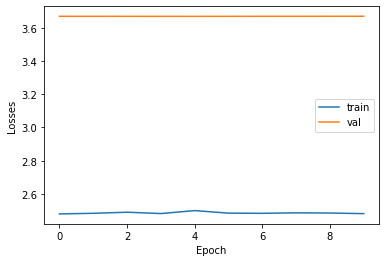

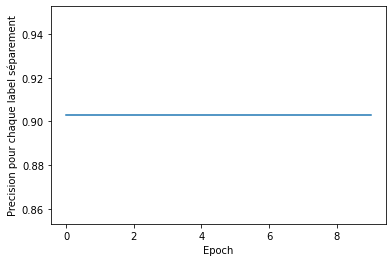

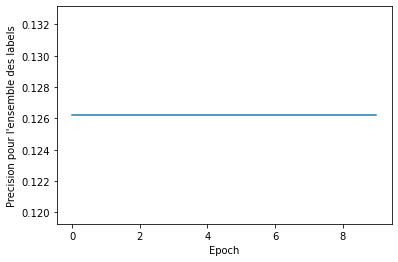

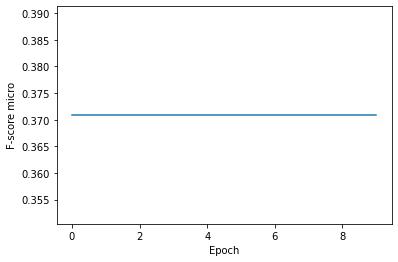



* * * Fine tuning Bert * * *
 f-score :  0.5629139072847682


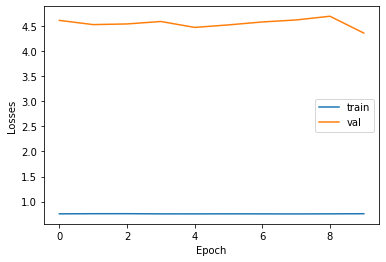

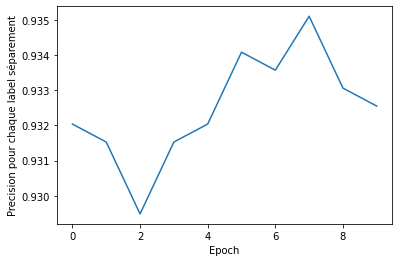

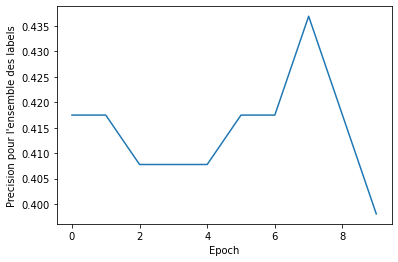

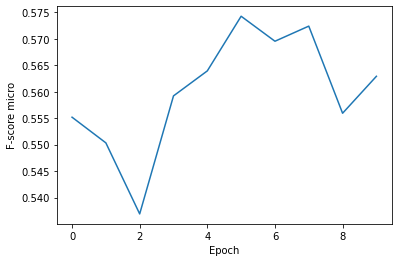



Titres


* * * RNNClassifier * * * 
 f-score :  0.37579617834394907


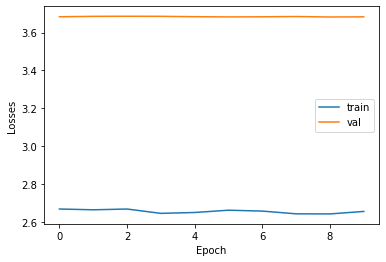

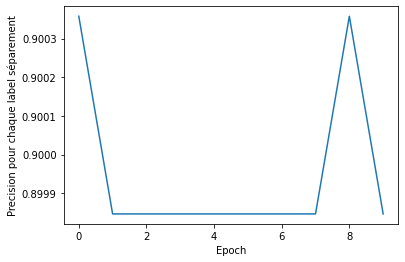

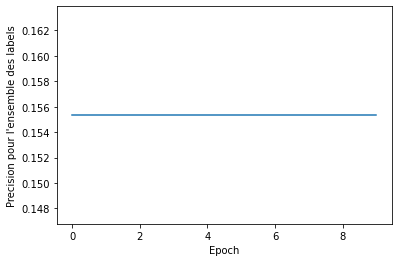

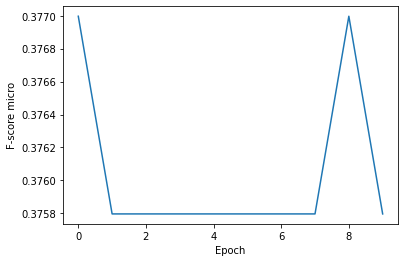



* * * Fine tuning Bert * * *
 f-score :  0.5448275862068965


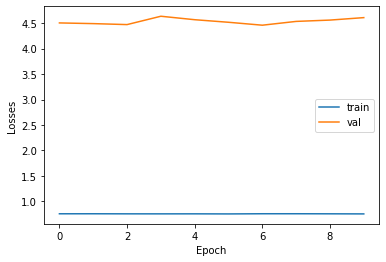

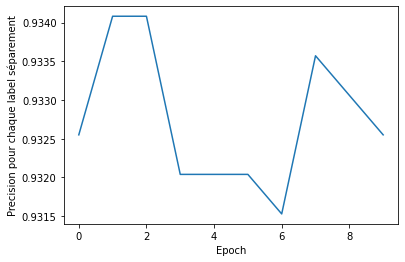

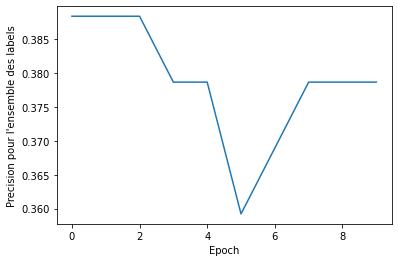

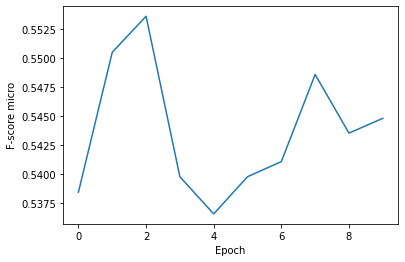

In [46]:
##RNN Classifier :
history_rnnclassif_ta = fit_rnn(rnn_model, train_loader_ta, valid_loader_ta, 10, lr=RNN_LR_TA, seuil=RNN_SEUIL_FIT_TA)
history_rnnclassif_t = fit_rnn(rnn_model, train_loader_t, valid_loader_t, 10, lr=RNN_LR_T, seuil=RNN_SEUIL_FIT_T)

##Fine tuning BioBERT :
history_bert_ta = fit(bert_model, 10, train_loader_ta, valid_loader_ta, lrbio=1e-05, lrdeci=BERT_LR_TA, freezebio=False, seuil=BERT_SEUIL_FIT_TA)
history_bert_t = fit(bert_model, 10, train_loader_t, valid_loader_t, lrbio=1e-05, lrdeci=BERT_LR_T, freezebio=False, seuil=BERT_SEUIL_FIT_T)


print("\n\n___________________________\n\n")
print("\n\nTitres + abstracts\n\n")
print('* * * RNNClassifier * * * ')
print(" f-score : ", history_rnnclassif_ta['f_micro'][9])
print_history(history_rnnclassif_ta)
print('\n\n* * * Fine tuning Bert * * *')
print(" f-score : ", history_bert_ta['f_micro'][9])
print_history(history_bert_ta)


print("\n\nTitres\n\n")
print('* * * RNNClassifier * * * ')
print(" f-score : ", history_rnnclassif_t['f_micro'][9])
print_history(history_rnnclassif_t)
print('\n\n* * * Fine tuning Bert * * *')
print(" f-score : ", history_bert_t['f_micro'][9])
print_history(history_bert_t)

### Test

In [47]:
def CrossEntropyLossOneHot(y_score=None, y=None):
    """CrossEntropy pour la multi classification
    """
    log_y_score = torch.log(y_score)
    cost = -torch.sum(y * log_y_score)
    return cost

def perf_test(model, loader, seuil:float=2e-1):
    """Evaluation en multi-label, le seuil désigne le niveau a partir duquel on considère une classe comme 'prédite'
    """
    criterion = CrossEntropyLossOneHot
    model.eval()
    total_loss = num = num_comp = correct = 0
    total_pred = true_y = None # concaténation des batchs
    for x, y in loader:
        with torch.no_grad():
            y_scores = model(x)
            loss = criterion(y_scores, y)
            y_pred = multi_hot(y_scores, seuil)
            if total_pred == None: # concat
                total_pred = y_pred
                true_y = y
            else:
                total_pred = torch.cat((total_pred,y_pred), dim=0)
                true_y = torch.cat((true_y,y), dim=0)
            correct += torch.sum(y_pred == y).item()
            total_loss += loss.item()
            num_comp += len(y) * len(LABELS)
            num += len(y)

    f_score_micro = f1_score(true_y.cpu(), total_pred.cpu(), average='micro')
    f_score_macro = f1_score(true_y.cpu(), total_pred.cpu(), average='macro')
    f_score_weighted = f1_score(true_y.cpu(), total_pred.cpu(), average='weighted')
    f_score_sample = f1_score(true_y.cpu(), total_pred.cpu(), average='samples')
    # accu_score = accuracy_score(true_y.cpu(), total_pred.cpu())
    return f_score_micro, f_score_macro, f_score_weighted, f_score_sample

In [48]:
print("titres + abstracts")
f_score_micro, f_score_macro, f_score_weighted, f_score_sample = perf_test(rnn_model, test_loader_ta, seuil=RNN_SEUIL_PERF_TA)
print('RNN Classifier -','f-score micro :', f_score_micro, '- f-score macro :', f_score_macro, '- f-score weighted :', f_score_weighted, '- f-score sample :', f_score_sample)
f_score_micro, f_score_macro, f_score_weighted, f_score_sample = perf_test(bert_model, test_loader_ta, seuil=BERT_SEUIL_PERF_TA)
print('BioBERT -','f-score micro :', f_score_micro, '- f-score macro :', f_score_macro, '- f-score weighted :', f_score_weighted, '- f-score sample :', f_score_sample)

print("titres")
f_score_micro, f_score_macro, f_score_weighted, f_score_sample = perf_test(rnn_model, test_loader_t, seuil=RNN_SEUIL_PERF_T)
print('RNN Classifier -','f-score micro :', f_score_micro, '- f-score macro :', f_score_macro, '- f-score weighted :', f_score_weighted, '- f-score sample :', f_score_sample)
f_score_micro, f_score_macro, f_score_weighted, f_score_sample = perf_test(bert_model, test_loader_t, seuil=BERT_SEUIL_PERF_T)
print('BioBERT -','f-score micro :', f_score_micro, '- f-score macro :', f_score_macro, '- f-score weighted :', f_score_weighted, '- f-score sample :', f_score_sample)

titres + abstracts
RNN Classifier - f-score micro : 0.42874543239951274 - f-score macro : 0.16801949608710184 - f-score weighted : 0.3963884938770516 - f-score sample : 0.421549243479068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


BioBERT - f-score micro : 0.6055045871559633 - f-score macro : 0.5699070068559156 - f-score weighted : 0.5943006148973616 - f-score sample : 0.6333054859370648
titres
RNN Classifier - f-score micro : 0.4218181818181818 - f-score macro : 0.16294519009980438 - f-score weighted : 0.3914869282121584 - f-score sample : 0.4185417246820755
BioBERT - f-score micro : 0.6153846153846153 - f-score macro : 0.570663047607707 - f-score weighted : 0.6031424239438671 - f-score sample : 0.6376218323586744


# Conclusion

Les performances avec le model Bert sont meilleurs qu'avec le model Rnn Classifier. On peut supposer que le manque de données explique les résultats si faibles. Pour la prédiction de spécialités c'est le modèle BioBert qui obtient le meilleur f1-score (0.61). 